# Part0 - 前言與資料集準備
   - 組別： 第7組
   - 組員： 廖禹竣、王泓暐、林哲寬
   - 主題： [6] Data Science for COVID-19 (DS4C)
   - 使用的資料集：https://www.kaggle.com/kimjihoo/coronavirusdataset ，其中並不包含SearchTrend及Weather，因為在初步評估時認為其分析的價值較低而捨棄。Time及Case已包含在各資料集中，故不額外進行分析。
   - 分析方法： 視覺化、資料處理、數值性預測


In [1]:
import datetime, time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'PatientRoute.csv', 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv','Ground.csv']
datasets = []
for f in file_names:
    datasets.append('dataset/' + f)
print(datasets)

['dataset/TimeAge.csv', 'dataset/TimeProvince.csv', 'dataset/Region.csv', 'dataset/TimeGender.csv', 'dataset/Time.csv', 'dataset/Case.csv', 'dataset/Weather.csv', 'dataset/PatientInfo.csv', 'dataset/PatientRoute.csv', 'dataset/SeoulFloating.csv', 'dataset/SearchTrend.csv', 'dataset/Policy.csv', 'dataset/Ground.csv']


In [3]:
age = pd.read_csv(datasets[0])
province = pd.read_csv(datasets[1])
region = pd.read_csv(datasets[2])
gender = pd.read_csv(datasets[3])
time = pd.read_csv(datasets[4])
case = pd.read_csv(datasets[5])
weather = pd.read_csv(datasets[6])
patientInfo = pd.read_csv(datasets[7])
patientRoute = pd.read_csv(datasets[8])
sfloat = pd.read_csv(datasets[9])
search = pd.read_csv(datasets[10])
policy = pd.read_csv(datasets[11])
ground = pd.read_csv(datasets[12])


# PartI 區域性層面分析
-----------------------------------
   ## 使用的資料集：
   
 ### Region
  
 資料集說明：
 本資料集的目的在於提供個別的小區域指標性的資料，而並不包括確診數等資訊
 - province : 州
 - city : 州下的次級子區域，也是區域資料的最細項
 - elementary_school_count : 該區域內小學的數量
 - kindergarten_count ： 該區域內幼稚園的數量
 - university_count ： 該區域內大學的數量
 - academy_ratio ：該區域內擁有學院的比例
 - elderly_population_ratio ：該區域內老年人口的比例
 - elderly_alone_ratio ： 該區域內獨居老人人口的比例
 - nursing_home_count ： 該區域內療養院的比例
   
   
###    TimeProvince
資料集說明：
 - date : 該筆資料被記錄的日期
 - time : 該筆資料被記錄的時間
 - province : 該筆資料發生的所在地（州）
 - confirmed : 截止該筆資料的時間為止，該province所累積的確診人數
 - released : 截止該筆資料的時間為止，該province所累積的被釋放的隔離人數
 - deceased : 截止該筆資料的時間為止，該province所累積的死亡人數
 
 
 ### Patient
資料集說明：
- infection_order: 第幾號傳染者，1號代表來自武漢，N號代表是被N-1號傳染
- contact_number:確診者接觸人數
- state:
  - isolated:在醫院中隔離
  - released:康復
  - deceased:死亡
- age:年齡
- disease: TRUE: underlying disease / FALSE: no disease
  
     
 ###    PatientRoute
資料集說明：
 - date : 該筆足跡被記錄的日期
 - province : 該筆足跡發生的所在地（州）
 - city : 該筆足跡發生的所在地（城）
 - type : 前往場所的分類，如無法分類或不詳則以etc表示
 
 
  ## 主要分析法：
 - 視覺化區域內各項數值的概況，從占比、累積趨勢及當日趨勢等三個面向進行討論
 - 研究各大區域疫情的狀況對比，並分群進行進一步的比對
 - 比較各個大區域老年人口、教育水平、獨居老人比例及療養院的比例，並尋求與各區域確診數差異的關聯性
 - 將區域人口及密度等因子加入考量
 - 分析足跡地理位置的分布，並研判與疫情的發展有何相關性
 - 檢視單一病患擁有履歷數的分布
 - 探討前往場所的比例
 - 研究記錄多寡的變動量與確診數變化的關聯性
 - 統計最早足跡時間和確診時間的差距
 

### 1-1 各Province的概況 

### confirmed data(統計至2020-5-14日)

**組成比例**

(-1.1093421156697443,
 1.1004448747722126,
 -1.1055672134023797,
 1.1078921045876047)

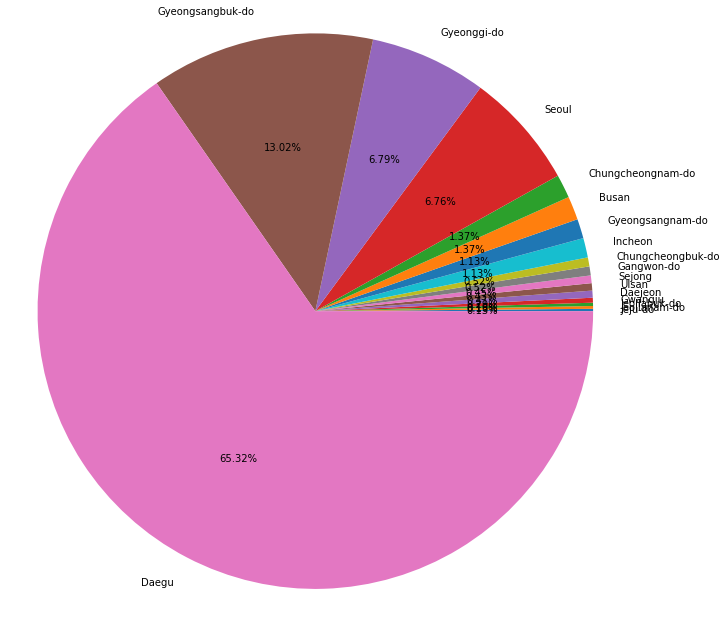

In [4]:
# last day confirmed percentage
order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'confirmed'])
order['size'] = size
order = order.sort_values(by=['size'])

fig, ax = plt.subplots(figsize=(11,11))
ax.pie(order['size'], labels=order['province'], autopct='%.2f%%')
plt.axis('equal')

分析結果：從確診數的區域佔比讓我們初步認知到爆發新天地教會事件的大邱是最嚴重的，與慶尚北道加起來就佔了全部確診的將近五分之四。接下來除了京畿道和首爾次之之外，其他的省分感染情況相對的並不明顯。

**累積性成長趨勢**

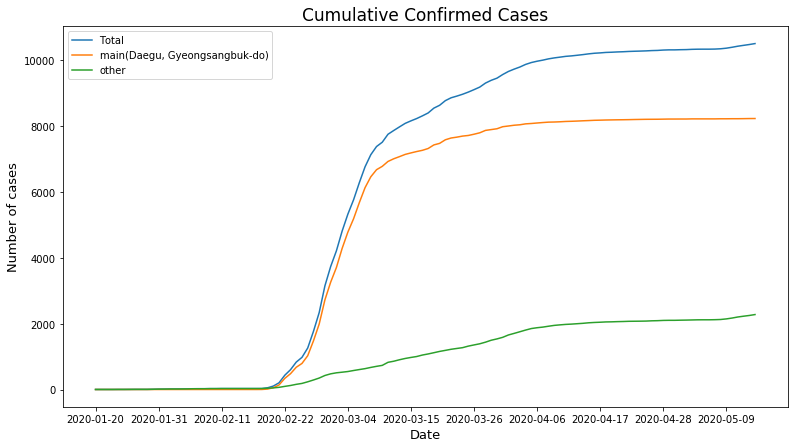

In [5]:
# Cumulative Confirmed Cases
# Total
total_list = province.groupby('date').sum().confirmed
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), province.groupby('date').sum().confirmed , label='Total')

# main
loc = province[(province.province=='Daegu') | (province.province=='Gyeongsangbuk-do')].groupby('date').sum().confirmed
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='main(Daegu, Gyeongsangbuk-do)')

# other
loc = province[(province.province!='Daegu') & (province.province!='Gyeongsangbuk-do')].groupby('date').sum().confirmed
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='other')
ax.set_xticks(ax.get_xticks()[::11])

plt.legend(loc='upper left')

分析結果：2月底特定地區大量指數型爆發，而其他地區線性增長，造成總確診數跟著指數型爆發。最後隨著疫情的平緩，總確診數上揚與其他地區確診數上揚較為相關。

**單日確診成長趨勢**

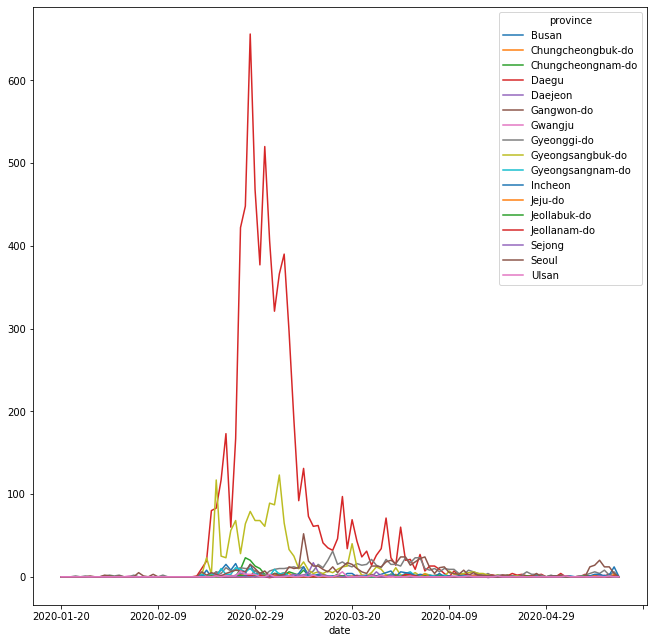

In [6]:
# daily confirmed
for title in province['province'].unique():
    day = province.loc[province['province']==title, 'confirmed']
    province.loc[province['province']==title, 'daily_confirmed'] = day.shift(-1) - day

province.groupby(['date','province'])['daily_confirmed'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(11,11))

分析結果：每日確診數，高峰期後地區增長率相差不大。最後首爾地區每日確診數突然爆發與上圖累計確診數相關。

### deceased data(統計至2020-5-14日)

**組成比例**

(-1.1139873190707088,
 1.1006660705941442,
 -1.1095146451338227,
 1.1240400815671001)

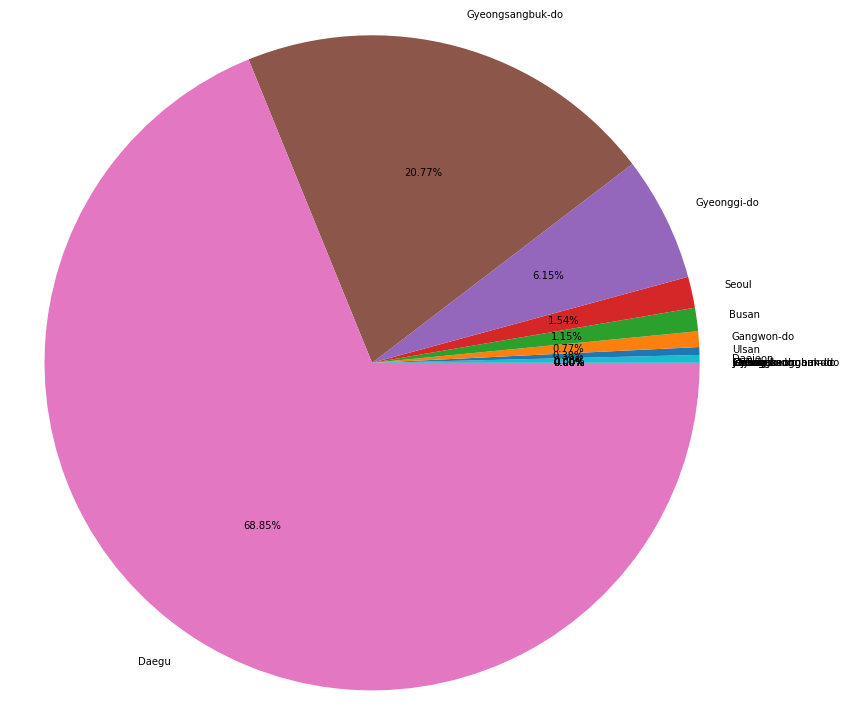

In [7]:
order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'deceased'])
order['size'] = size
order = order.sort_values(by=['size'])

fig, ax = plt.subplots(figsize=(13,13))
ax.pie(order['size'], labels=order['province'], autopct='%.2f%%')
plt.axis('equal')

分析結果：大致上各區域的分布情形與確診數差不多，畢竟得病的人越多也會有越多人死亡。值得注意的是京畿道的比例增加，而首爾的比例顯著減少，或許是醫療環境不同或有其他的因素在。

**累積性成長趨勢**

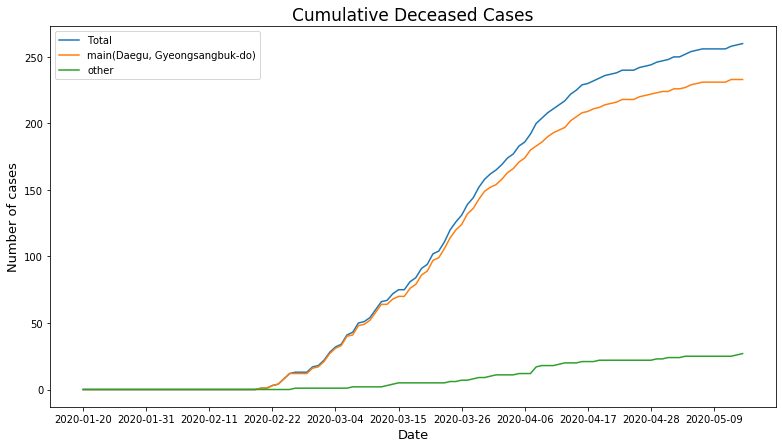

In [8]:
# Cumulative deceased Cases
# Total
total_list = province.groupby('date').sum().deceased
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), province.groupby('date').sum().deceased , label='Total')

# main
loc = province[(province.province=='Daegu') | (province.province=='Gyeongsangbuk-do')].groupby('date').sum().deceased
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='main(Daegu, Gyeongsangbuk-do)')

# other
loc = province[(province.province!='Daegu') & (province.province!='Gyeongsangbuk-do')].groupby('date').sum().deceased
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='other')
ax.set_xticks(ax.get_xticks()[::11])

plt.legend(loc='upper left')

分析結果：總死亡數幾乎隨著主要爆發地區趨勢增長，而最後的上揚同樣是其他地區影響。

**單日死亡成長趨勢**

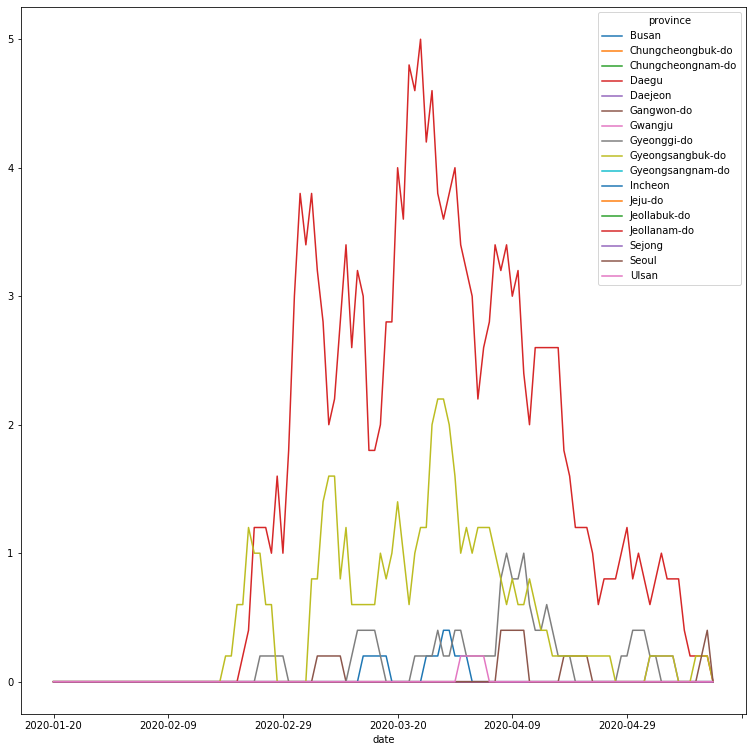

In [9]:

# daily deceased
for title in province['province'].unique():
    day = province.loc[province['province']==title, 'deceased']
    province.loc[province['province']==title, 'daily_deceased'] = day.shift(-1) - day
    province.loc[province['province']==title, 'deceased_5sma']=province.loc[province['province']==title, 'daily_deceased'].rolling(5).mean()


province.groupby(['date','province'])['deceased_5sma'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(13,13))

分析結果：最後死亡數上揚和病情爆發的首爾地區有關聯。此外可以從各線段與紫色水平線的交點看出感染情況嚴重的區域死亡數，該日每人死亡的頻率也較低。並不是累積在同一時間附近死亡的模式。

### release data(統計至2020-5-14日)

**組成比例**

(-1.1030120209484613,
 1.1001434295689743,
 -1.1019600087418704,
 1.1088019997781309)

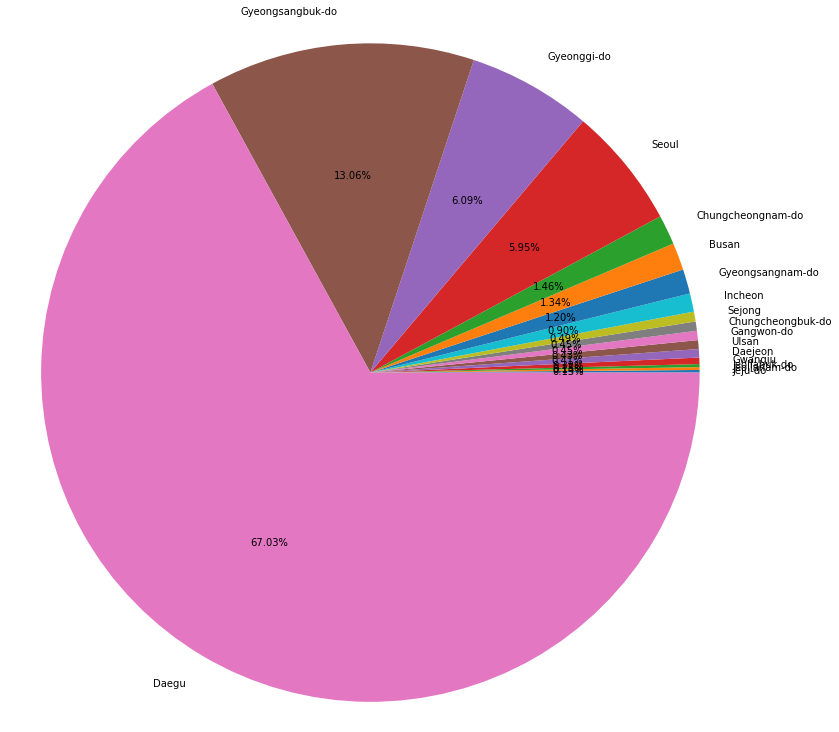

In [10]:
order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'released'])
order['size'] = size
order = order.sort_values(by=['size'])

fig, ax = plt.subplots(figsize=(13,13))
ax.pie(order['size'], labels=order['province'], autopct='%.2f%%')
plt.axis('equal')

分析結果：隔離釋放人數也是爆發地區占多數，可能與爆發地區大規模篩檢有關。比起死亡比例，被釋放的比例和確診比例較為相似。

**累積性成長趨勢**

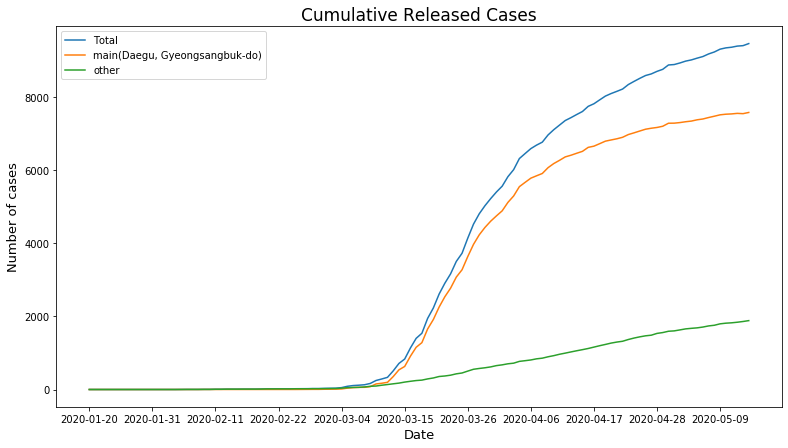

In [11]:
# Cumulative released Cases
# Total
total_list = province.groupby('date').sum().released
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Released Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), province.groupby('date').sum().released , label='Total')

# main
loc = province[(province.province=='Daegu') | (province.province=='Gyeongsangbuk-do')].groupby('date').sum().released
plt.title('Cumulative Released Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='main(Daegu, Gyeongsangbuk-do)')

# other
loc = province[(province.province!='Daegu') & (province.province!='Gyeongsangbuk-do')].groupby('date').sum().released
plt.title('Cumulative Released Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='other')
ax.set_xticks(ax.get_xticks()[::11])

plt.legend(loc='upper left')

分析結果：和前面兩個一樣幾乎是主要爆發區主宰整體趨勢的傾向。

**單日釋放數成長趨勢**

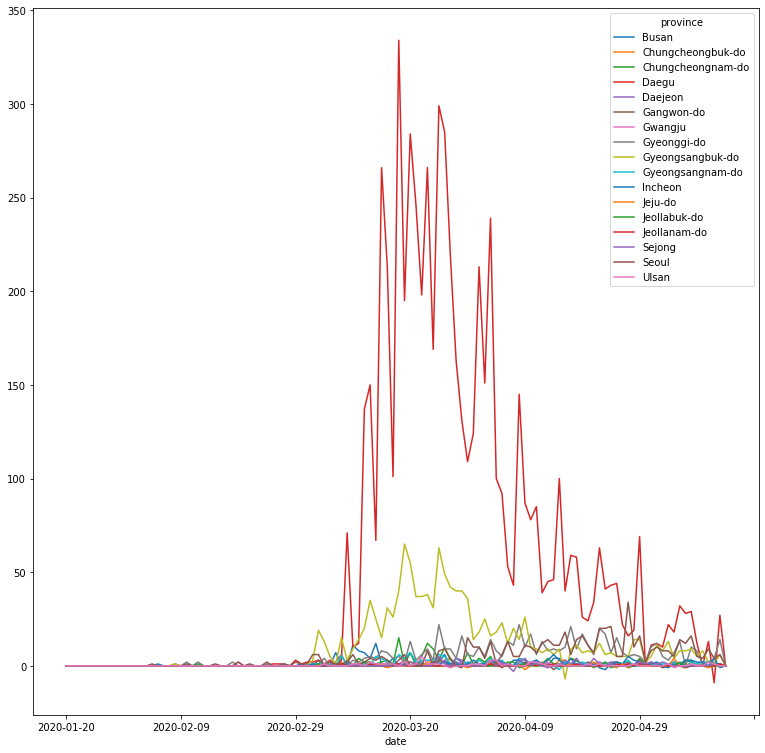

In [12]:
# daily released
for title in province['province'].unique():
    day = province.loc[province['province']==title, 'released']
    province.loc[province['province']==title, 'daily_released'] = day.shift(-1) - day

province.groupby(['date','province'])['daily_released'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(13,13))

分析結果：表為每日從隔離中釋放人數，其中負數代表復陽的情況或是統計錯誤或是該病患死亡，單純從時間上不得而知。

### Mortality Rate(死亡率)

             province  mortality_rate
14   Gyeongsangbuk-do        3.947368
9          Gangwon-do        3.636364
2               Daegu        2.607429
5             Daejeon        2.325581
8         Gyeonggi-do        2.240896
6               Ulsan        2.222222
1               Busan        2.083333
0               Seoul        0.562588
7              Sejong        0.000000
4             Gwangju        0.000000
10  Chungcheongbuk-do        0.000000
11  Chungcheongnam-do        0.000000
12       Jeollabuk-do        0.000000
13       Jeollanam-do        0.000000
3             Incheon        0.000000
15   Gyeongsangnam-do        0.000000
16            Jeju-do        0.000000


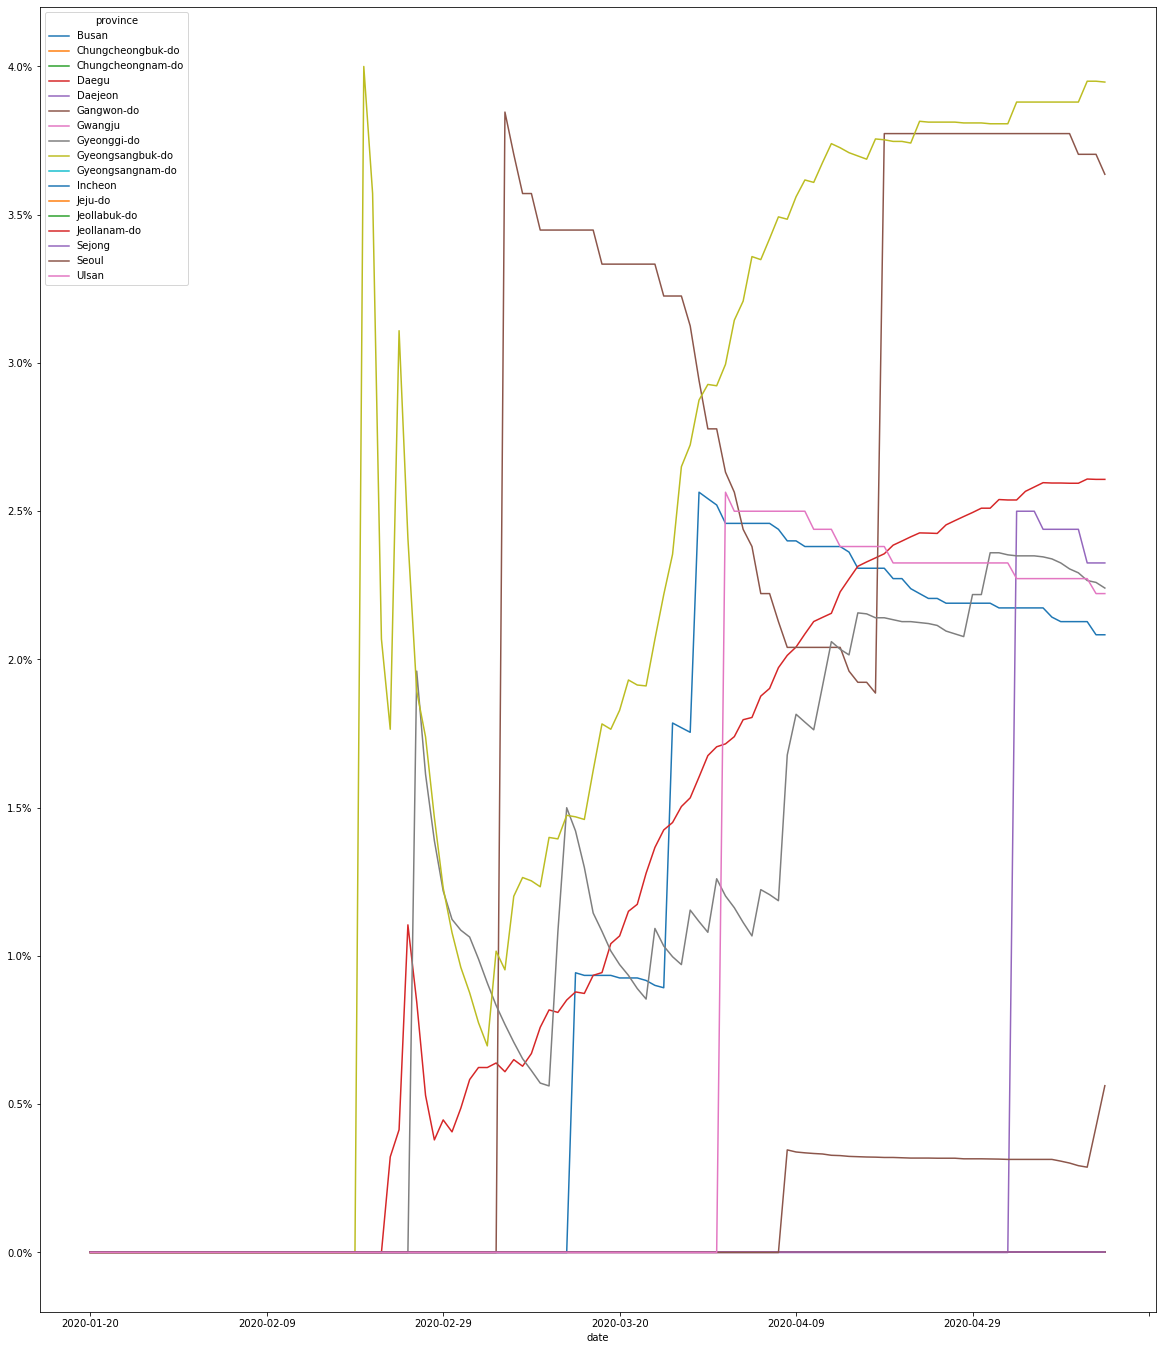

In [13]:
province['mortality_rate'] = province['deceased']/province['confirmed'] * 100
province.groupby(['date','province'])['mortality_rate'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(20,24))
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'mortality_rate'])
order['mortality_rate'] = size
order = order.sort_values(by=['mortality_rate'],ascending=False)
print(order)

分析結果：表為約2個月間的每100人死亡數，勉強能看出各省分都是疫情突然爆發來不及應對而造成高死亡率。
圖為每日(累計死亡數/累計確診數)比率，即每日男女每百人死亡數。  
以下將死亡率較高的地區分成，先爆發地區和後爆發地區分開看

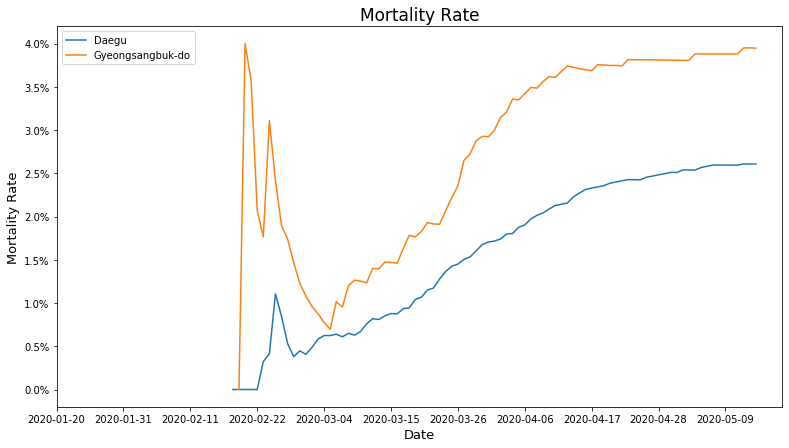

In [14]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Mortality Rate', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Mortality Rate', size=13)
plt.plot(province.date.unique(),  province.loc[(province.province=='Daegu'), 'mortality_rate'], label='Daegu')
plt.plot(province.date.unique(),  province.loc[(province.province=='Gyeongsangbuk-do'), 'mortality_rate'], label='Gyeongsangbuk-do')
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks()[::11])

分析結果：死亡率爆發增長後漸趨平緩，沒有再2次失控。

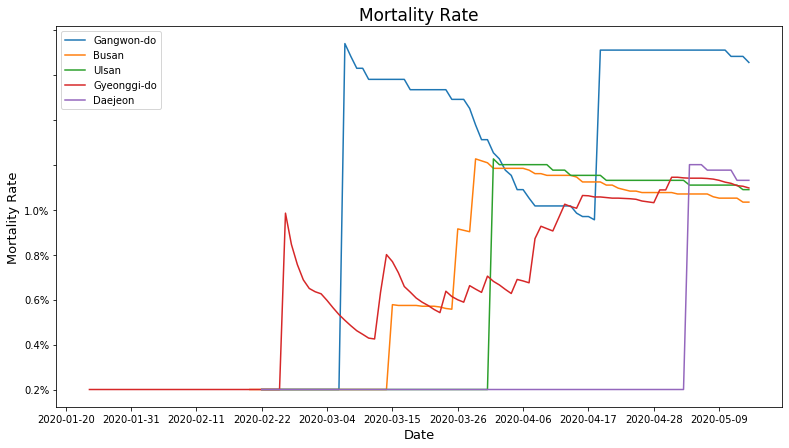

In [15]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Mortality Rate', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Mortality Rate', size=13)
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

plt.plot(province.date.unique(),  province.loc[(province.province=='Gangwon-do'), 'mortality_rate'], label='Gangwon-do')
plt.plot(province.date.unique(),  province.loc[(province.province=='Busan'), 'mortality_rate'], label='Busan')
plt.plot(province.date.unique(),  province.loc[(province.province=='Ulsan'), 'mortality_rate'], label='Ulsan')
plt.plot(province.date.unique(),  province.loc[(province.province=='Gyeonggi-do'), 'mortality_rate'], label='Gyeonggi-do')
plt.plot(province.date.unique(),  province.loc[(province.province=='Daejeon'), 'mortality_rate'], label='Daejeon')
plt.legend(loc='upper left')

ax.set_xticks(ax.get_xticks()[::11])

分析結果：Gangwon-do地區死亡率多次爆發增長，顯然當地缺乏警戒。其餘地區則沒有再2次失控。

### 以分群的方式觀察各地區感染情況

從前面的部分可以非常懸殊的可以大邱就是被感染最嚴重的區域。但由於它的一枝獨秀，其它區域的結果都被擠扁了。我們把區域分為感染嚴重和不嚴重的兩類，以更好地觀察它們之間的差異。

**嚴重區域**

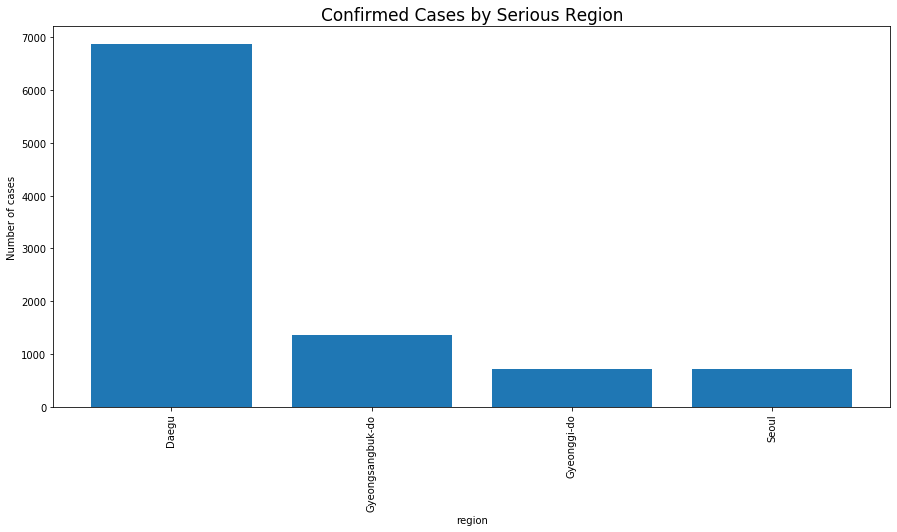

In [16]:
df_province = province
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='confirmed',ascending=False)[0:4]

fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Confirmed Cases by Serious Region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(df_province_max.index
        , df_province_max.confirmed
         )
plt.xlabel('region')
plt.ylabel('Number of cases')
plt.show()

**不嚴重區域**

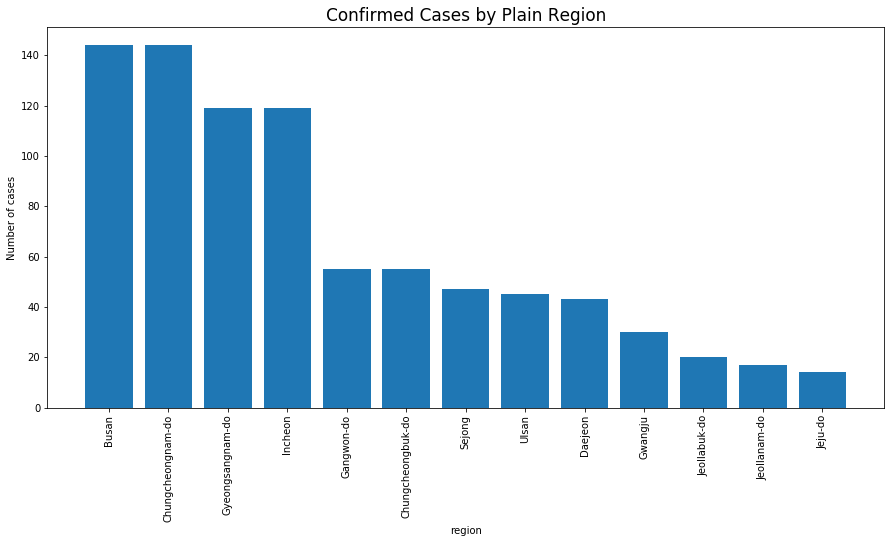

In [17]:
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='confirmed',ascending=False)[4:]

fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Confirmed Cases by Plain Region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(df_province_max.index
        , df_province_max.confirmed
         )
plt.xlabel('region')
plt.ylabel('Number of cases')
plt.show()

分析結果：比較不嚴重的區域又可分成兩群的樣子。接下來將藉由網路(http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007) 查到的區域人口以及面積的資訊來算出人口密度，來判斷區域稠密度與疫情的關聯性。

### 人口與各地區感染情況之關聯性

**人口密度**

In [18]:
pop_dense = df_province.groupby('province').max()


pop_dense = pop_dense.sort_values(by='confirmed',ascending=False)
# density = 千人 / km²
pop_dense['density'] = [2773, 141, 1279, 16034, 265, 4416
                        , 318, 653, 2764, 1088, 219, 90
                        , 2813, 2980, 226, 145, 353]


pop_dense

date  time  confirmed  released  deceased  \
province                                                             
Daegu              2020-05-14    16       6865      6349       179   
Gyeongsangbuk-do   2020-05-14    16       1368      1237        54   
Gyeonggi-do        2020-05-14    16        714       577        16   
Seoul              2020-05-14    16        711       564         4   
Busan              2020-05-14    16        144       127         3   
Chungcheongnam-do  2020-05-14    16        144       138         0   
Gyeongsangnam-do   2020-05-14    16        119       114         0   
Incheon            2020-05-14    16        119        86         0   
Gangwon-do         2020-05-14    16         55        43         2   
Chungcheongbuk-do  2020-05-14    16         55        43         0   
Sejong             2020-05-14    16         47        46         0   
Ulsan              2020-05-14    16         45        41         1   
Daejeon            2020-05-14    16         43        39         1   
Gwangju            2020-05-14    16         30        30         0   
Jeollabuk-do       2020-05-14    16         20        14         0   
Jeollanam-do       2020-05-14    16         17        13         0   
Jeju-do            2020-05-14    16         14        13         0   

                   daily_confirmed  daily_deceased  deceased_5sma  \
province                                                            
Daegu                        656.0             7.0            5.0   
Gyeongsangbuk-do             123.0             4.0            2.2   
Gyeonggi-do                   31.0             3.0            1.0   
Seoul                         52.0             2.0            0.4   
Busan                         16.0             1.0            0.4   
Chungcheongnam-do             23.0             0.0            0.0   
Gyeongsangnam-do              11.0             0.0            0.0   
Incheon                       12.0             0.0            0.0   
Gangwon-do                     8.0             1.0            0.2   
Chungcheongbuk-do              5.0             0.0            0.0   
Sejong                        17.0             0.0            0.0   
Ulsan                          7.0             1.0            0.2   
Daejeon                        6.0             1.0            0.2   
Gwangju                        4.0             0.0            0.0   
Jeollabuk-do                   2.0             0.0            0.0   
Jeollanam-do                   3.0             0.0            0.0   
Jeju-do                        3.0             0.0            0.0   

                   daily_released  mortality_rate  density  
province                                                    
Daegu                       334.0        2.608569     2773  
Gyeongsangbuk-do             65.0        4.000000      141  
Gyeonggi-do                  22.0        2.359882     1279  
Seoul                        34.0        0.562588    16034  
Busan                        12.0        2.564103      265  
Chungcheongnam-do            15.0        0.000000     4416  
Gyeongsangnam-do              7.0        0.000000      318  
Incheon                       6.0        0.000000      653  
Gangwon-do                    3.0        3.846154     2764  
Chungcheongbuk-do             4.0        0.000000     1088  
Sejong                        5.0        0.000000      219  
Ulsan                         5.0        2.564103       90  
Daejeon                       4.0        2.500000     2813  
Gwangju                       3.0        0.000000     2980  
Jeollabuk-do                  2.0        0.000000      226  
Jeollanam-do                  1.0        0.000000      145  
Jeju-do                       4.0        0.000000      353

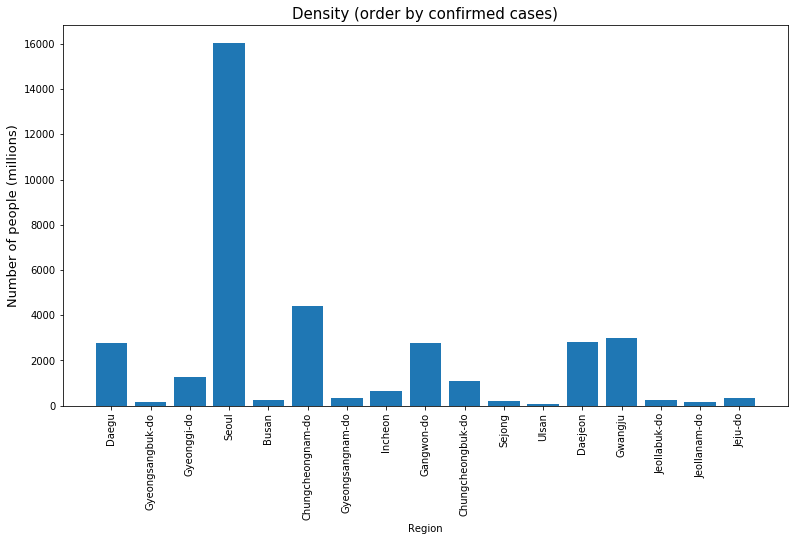

In [19]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Density (order by confirmed cases)', fontsize=15)
plt.bar(pop_dense.index, pop_dense.density)
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Number of people (millions)', size=13)
plt.show()

分析結果：剔除掉一些特例的話，明顯是一種密度越高致病性也越高的微弱正相關性。特別是作為指標性的首爾。不過那也可能是人口數的放大效應，而非密度。因此接下來將研究一下各區域人口數及傳染性的關係。

**人口數**

In [20]:
pop_dense['population'] = np.divide(
    [2450, 2674, 13031, 9705, 2180, 3400
     , 3356, 304, 2939, 1154, 1619, 1521
     , 1518, 1493, 1820, 1790, 653]
    , 1000 # thousand to million
)

pop_dense

date  time  confirmed  released  deceased  \
province                                                             
Daegu              2020-05-14    16       6865      6349       179   
Gyeongsangbuk-do   2020-05-14    16       1368      1237        54   
Gyeonggi-do        2020-05-14    16        714       577        16   
Seoul              2020-05-14    16        711       564         4   
Busan              2020-05-14    16        144       127         3   
Chungcheongnam-do  2020-05-14    16        144       138         0   
Gyeongsangnam-do   2020-05-14    16        119       114         0   
Incheon            2020-05-14    16        119        86         0   
Gangwon-do         2020-05-14    16         55        43         2   
Chungcheongbuk-do  2020-05-14    16         55        43         0   
Sejong             2020-05-14    16         47        46         0   
Ulsan              2020-05-14    16         45        41         1   
Daejeon            2020-05-14    16         43        39         1   
Gwangju            2020-05-14    16         30        30         0   
Jeollabuk-do       2020-05-14    16         20        14         0   
Jeollanam-do       2020-05-14    16         17        13         0   
Jeju-do            2020-05-14    16         14        13         0   

                   daily_confirmed  daily_deceased  deceased_5sma  \
province                                                            
Daegu                        656.0             7.0            5.0   
Gyeongsangbuk-do             123.0             4.0            2.2   
Gyeonggi-do                   31.0             3.0            1.0   
Seoul                         52.0             2.0            0.4   
Busan                         16.0             1.0            0.4   
Chungcheongnam-do             23.0             0.0            0.0   
Gyeongsangnam-do              11.0             0.0            0.0   
Incheon                       12.0             0.0            0.0   
Gangwon-do                     8.0             1.0            0.2   
Chungcheongbuk-do              5.0             0.0            0.0   
Sejong                        17.0             0.0            0.0   
Ulsan                          7.0             1.0            0.2   
Daejeon                        6.0             1.0            0.2   
Gwangju                        4.0             0.0            0.0   
Jeollabuk-do                   2.0             0.0            0.0   
Jeollanam-do                   3.0             0.0            0.0   
Jeju-do                        3.0             0.0            0.0   

                   daily_released  mortality_rate  density  population  
province                                                                
Daegu                       334.0        2.608569     2773       2.450  
Gyeongsangbuk-do             65.0        4.000000      141       2.674  
Gyeonggi-do                  22.0        2.359882     1279      13.031  
Seoul                        34.0        0.562588    16034       9.705  
Busan                        12.0        2.564103      265       2.180  
Chungcheongnam-do            15.0        0.000000     4416       3.400  
Gyeongsangnam-do              7.0        0.000000      318       3.356  
Incheon                       6.0        0.000000      653       0.304  
Gangwon-do                    3.0        3.846154     2764       2.939  
Chungcheongbuk-do             4.0        0.000000     1088       1.154  
Sejong                        5.0        0.000000      219       1.619  
Ulsan                         5.0        2.564103       90       1.521  
Daejeon                       4.0        2.500000     2813       1.518  
Gwangju                       3.0        0.000000     2980       1.493  
Jeollabuk-do                  2.0        0.000000      226       1.820  
Jeollanam-do                  1.0        0.000000      145       1.790  
Jeju-do                       4.0        0.000000      353       0.6

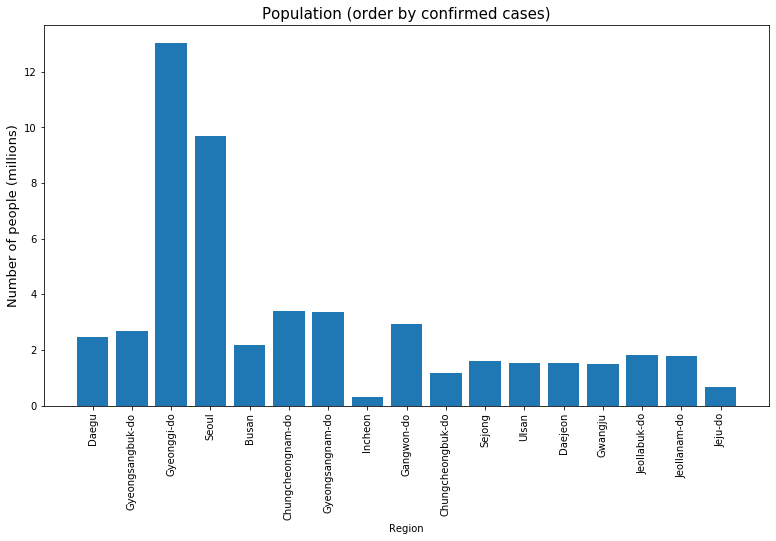

In [21]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population (order by confirmed cases)', fontsize=15)
plt.bar(pop_dense.index, pop_dense.population)
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Number of people (millions)', size=13)
plt.show()

分析結果：區域人口就滿符合人越多生病的人也會越多的特性。因此我們可以斷言首爾會有那麼多的確診數比起密度，跟人口數比較有關係。

### 1-2 區域間的各項指標比較

**概覽**

In [22]:
df_region = region

display(df_region.head(5).append(df_region.tail(5)).T)

0           1            2           3    \
code                        10000       10010        10020       10030   
province                    Seoul       Seoul        Seoul       Seoul   
city                        Seoul  Gangnam-gu  Gangdong-gu  Gangbuk-gu   
latitude                   37.567     37.5184      37.5305     37.6399   
longitude                 126.978     127.047      127.124     127.026   
elementary_school_count       607          33           27          14   
kindergarten_count            830          38           32          21   
university_count               48           0            0           0   
academy_ratio                1.44        4.18         1.54        0.67   
elderly_population_ratio    15.38       13.17        14.55       19.49   
elderly_alone_ratio           5.8         4.3          5.4         8.5   
nursing_home_count          22739        3088         1023         628   

                                 4                 239               240  \
code                           10040             61160             61170   
province                       Seoul  Gyeongsangnam-do  Gyeongsangnam-do   
city                      Gangseo-gu         Haman-gun       Hamyang-gun   
latitude                     37.5512           35.2725           35.5205   
longitude                     126.85           128.407           127.725   
elementary_school_count           36                16                13   
kindergarten_count                56                20                12   
university_count                   1                 0                 0   
academy_ratio                   1.17              1.19              1.01   
elderly_population_ratio       14.39             23.74             32.65   
elderly_alone_ratio              5.7              14.7              20.9   
nursing_home_count              1080                94                83   

                                       241      242      243  
code                                 61180    70000    80000  
province                  Gyeongsangnam-do  Jeju-do    Korea  
city                          Hapcheon-gun  Jeju-do    Korea  
latitude                           35.5667  33.4889   37.567  
longitude                          128.166    126.5  126.978  
elementary_school_count                 17      113     6087  
kindergarten_count                      15      123     8837  
university_count                         0        4      340  
academy_ratio                         0.71     1.53     1.56  
elderly_population_ratio             38.44     15.1    15.67  
elderly_alone_ratio                   24.7      6.4      7.2  
nursing_home_count                      96     1245    94865

In [23]:
print('Province 總數:', len(df_region.province.unique()))
print(df_region.province.unique())

Province 總數: 18
['Seoul' 'Busan' 'Daegu' 'Gwangju' 'Incheon' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do' 'Korea']


南韓一共有十七個州，其中最後一個「Korea」為全局的統計資訊

In [24]:
df_region[df_region.province=='Korea'].T

243
code                        80000
province                    Korea
city                        Korea
latitude                   37.567
longitude                 126.978
elementary_school_count      6087
kindergarten_count           8837
university_count              340
academy_ratio                1.56
elderly_population_ratio    15.67
elderly_alone_ratio           7.2
nursing_home_count          94865

### 老年人口

**分布情形**

In [25]:
region_elder = pd.DataFrame()
region_elder['elder_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().elderly_population_ratio
region_elder = region_elder.sort_values(ascending=False, by = 'elder_ratio')
region_elder

elder_ratio
province                      
Jeollanam-do         28.142174
Gyeongsangbuk-do     27.556250
Jeollabuk-do         27.470667
Gyeongsangnam-do     24.749474
Chungcheongnam-do    23.844375
Chungcheongbuk-do    23.192500
Gangwon-do           22.890526
Busan                19.357647
Daegu                17.031111
Incheon              16.399091
Seoul                15.738077
Jeju-do              15.100000
Gwangju              14.815000
Gyeonggi-do          14.429688
Daejeon              14.376667
Ulsan                11.773333
Sejong                9.480000

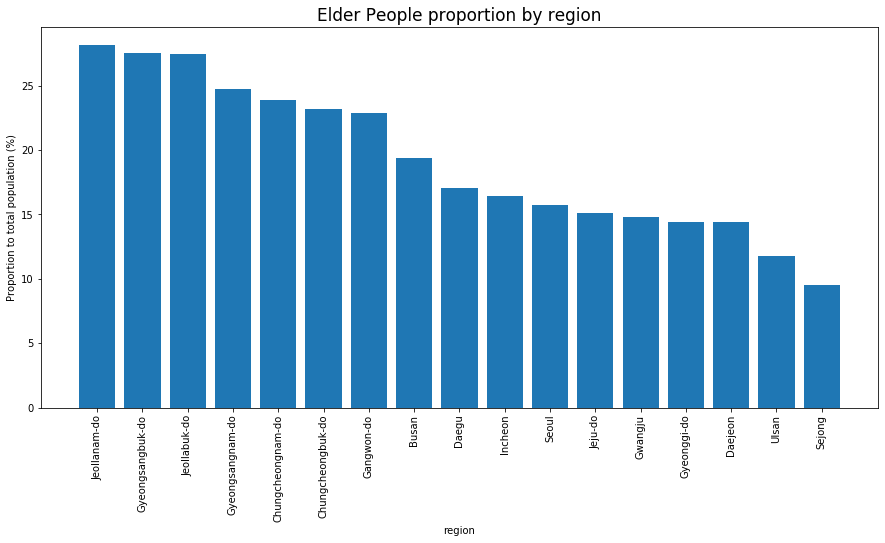

In [26]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Elder People proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_elder.index, region_elder.elder_ratio)
plt.xlabel('region')
plt.ylabel('Proportion to total population (%)')
plt.show()

分析結果：上面是各區域的老人分布情形，通常大都會區的老人比例會較低，由此可推測各個區域的都市化程度。或是該都市的工業化程度也會影響老人的比例。例如倒數第二的蔚山即為韓國著名的工業區。

**與確診數之關聯**

接下來將對各區域以確診數的方式排序，以確認兩者之間的相關性。排序的依據是從前面觀察到的結果

In [27]:
df_province = province
display(df_province.head(5).append(df_province.tail(5)))

date  time          province  confirmed  released  deceased  \
0     2020-01-20    16             Seoul          0         0         0   
1     2020-01-20    16             Busan          0         0         0   
2     2020-01-20    16             Daegu          0         0         0   
3     2020-01-20    16           Incheon          1         0         0   
4     2020-01-20    16           Gwangju          0         0         0   
1967  2020-05-14     0      Jeollabuk-do         20        14         0   
1968  2020-05-14     0      Jeollanam-do         17        13         0   
1969  2020-05-14     0  Gyeongsangbuk-do       1368      1237        54   
1970  2020-05-14     0  Gyeongsangnam-do        119       114         0   
1971  2020-05-14     0           Jeju-do         14        12         0   

      daily_confirmed  daily_deceased  deceased_5sma  daily_released  \
0                 0.0             0.0            NaN             0.0   
1                 0.0             0.0            NaN             0.0   
2                 0.0             0.0            NaN             0.0   
3                 0.0             0.0            NaN             0.0   
4                 0.0             0.0            NaN             0.0   
1967              NaN             NaN            NaN             NaN   
1968              NaN             NaN            NaN             NaN   
1969              NaN             NaN            NaN             NaN   
1970              NaN             NaN            NaN             NaN   
1971              NaN             NaN            NaN             NaN   

      mortality_rate  
0                NaN  
1                NaN  
2                NaN  
3           0.000000  
4                NaN  
1967        0.000000  
1968        0.000000  
1969        3.947368  
1970        0.000000  
1971        0.000000

In [28]:
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='confirmed',ascending=False)
confirm_order = list(df_province_max.index)


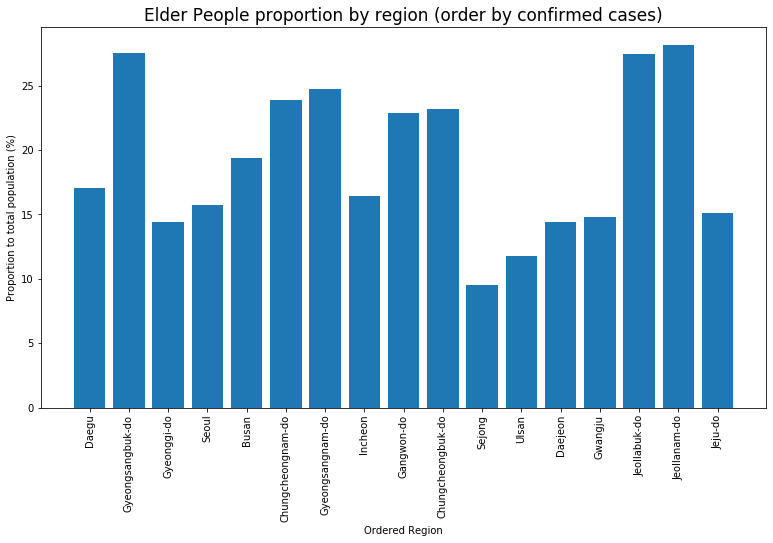

In [29]:
region_elder_order = pd.DataFrame()
for order in confirm_order:
    new_row = {'province':order, 'elder_ratio':region_elder.at[order,'elder_ratio']}
    region_elder_order = region_elder_order.append(new_row,ignore_index=True)
region_elder_order = region_elder_order[['province','elder_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Elder People proportion by region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Proportion to total population (%)')
plt.bar(region_elder_order.province, region_elder_order.elder_ratio)
plt.show()

分析結果：一如全國性的觀察，老人的確診率並未擁有支配性的地位，導致各區域間的長青人口比率以及確診率很明顯的並無相關性。下面將以死亡率重新排序，來看看是否會有不一樣的結果。

**與死亡數之關聯**

In [30]:
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='deceased',ascending=False)
deceased_rank = list(df_province_max.index)


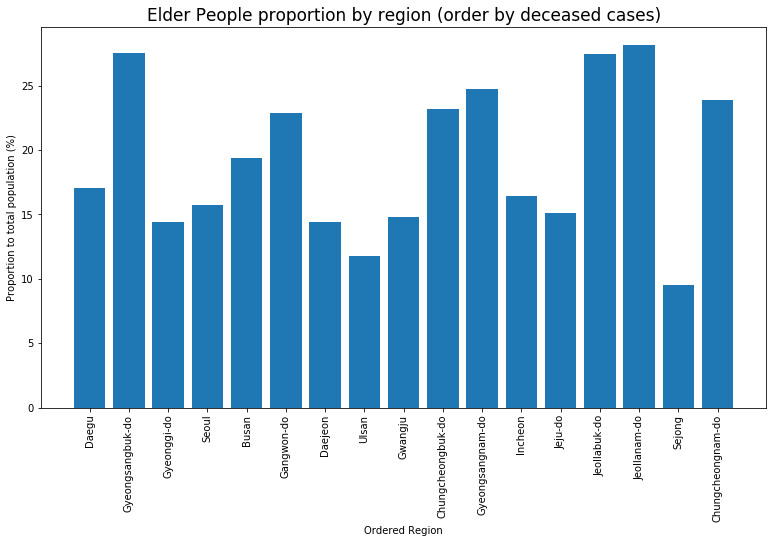

In [31]:
region_elder_order = pd.DataFrame()
death_order = deceased_rank
for order in death_order:
    new_row = {'province':order, 'elder_ratio':region_elder.at[order,'elder_ratio']}
    region_elder_order = region_elder_order.append(new_row,ignore_index=True)
region_elder_order = region_elder_order[['province','elder_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Elder People proportion by region (order by deceased cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Proportion to total population (%)')
plt.bar(region_elder_order.province, region_elder_order.elder_ratio)
plt.show()


分析結果：如圖，以死亡率排序給予的提示也並不明顯，而且有很多區域都是零，參考性並不明確，本節剩下的部分將不再研究死亡率。接著從各地區的教育程度著手。

### 教育情形

**各地教育情形對比**

In [32]:
region_educate = pd.DataFrame()
region_educate['academy_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().academy_ratio
region_educate = region_educate.sort_values(ascending=False, by = 'academy_ratio')
region_educate

academy_ratio
province                        
Gwangju                 2.473333
Ulsan                   2.111667
Sejong                  1.780000
Daegu                   1.713333
Jeju-do                 1.530000
Daejeon                 1.425000
Gyeonggi-do             1.420625
Gyeongsangnam-do        1.363158
Seoul                   1.360000
Jeollabuk-do            1.330000
Busan                   1.327647
Chungcheongnam-do       1.122500
Gangwon-do              1.116842
Jeollanam-do            1.065217
Incheon                 1.054545
Chungcheongbuk-do       1.023333
Gyeongsangbuk-do        0.948750

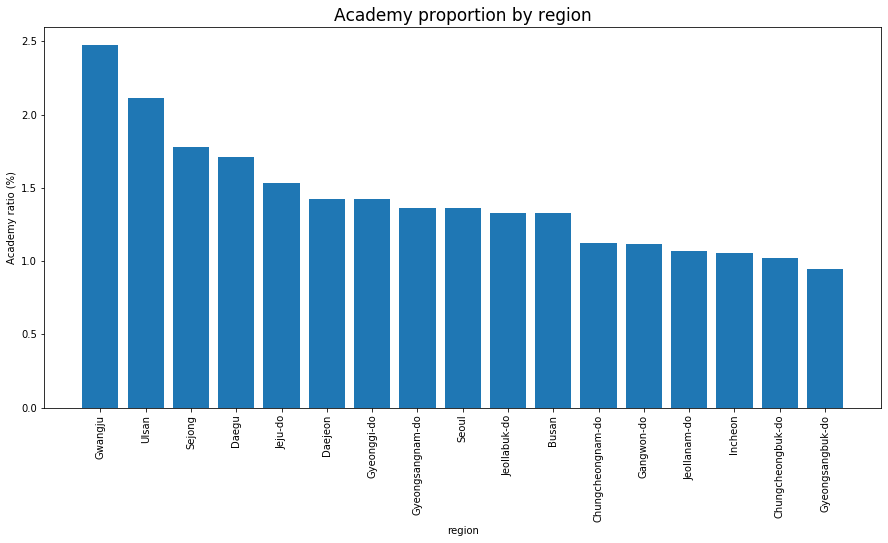

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Academy proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_educate.index, region_educate.academy_ratio)
plt.xlabel('region')
plt.ylabel('Academy ratio (%)')
plt.show()

分析結果：排名的依據是各區所有次級區域academy ratio的平均。作為首都並且擁有局部最大值的首爾因為有而很多數值小的區域而被拖累，只排在中段。但從數據變化量可看出大家的差距都不會很多。

**與確診數之關聯**

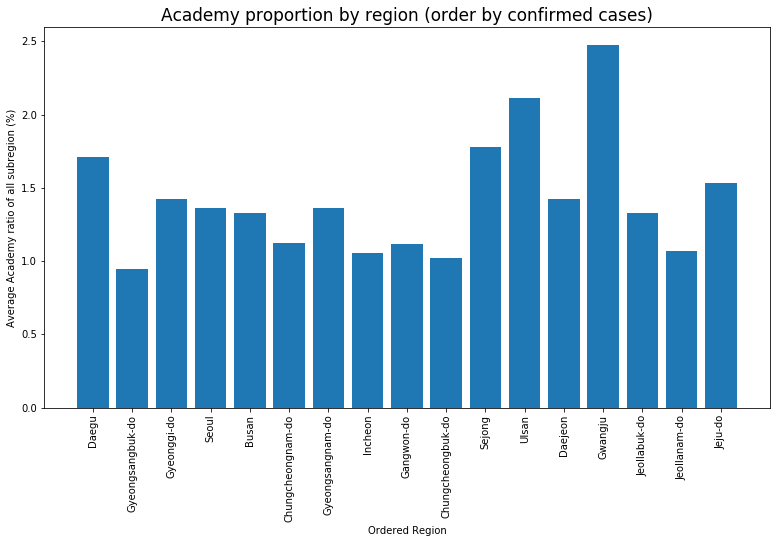

In [34]:
region_edu_order = pd.DataFrame()
for order in confirm_order:
    new_row = {'province':order, 'academy_ratio':region_educate.at[order,'academy_ratio']}
    region_edu_order  = region_edu_order .append(new_row,ignore_index=True)
region_edu_order  = region_edu_order [['province','academy_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Academy proportion by region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Average Academy ratio of all subregion (%)')
plt.bar(region_edu_order.province, region_edu_order.academy_ratio)
plt.show()


分析結果：排除作為outlier的大邱後，可以注意到某些平均教育比例較高的區域的確屬於比較不嚴重的區域。像是光州。或許人民的教育水平還是有一點點的影響。

### 獨居老人層面

**各地獨居老人情形對比**

In [35]:
region_alone = pd.DataFrame()
region_alone['alone_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().elderly_alone_ratio
region_alone = region_alone.sort_values(ascending=False, by = 'alone_ratio')
region_alone

alone_ratio
province                      
Jeollanam-do         17.030435
Jeollabuk-do         15.533333
Gyeongsangbuk-do     15.133333
Gyeongsangnam-do     14.721053
Chungcheongbuk-do    11.825000
Chungcheongnam-do    11.706250
Gangwon-do           11.578947
Busan                 9.094118
Daegu                 7.966667
Incheon               7.236364
Gwangju               6.716667
Jeju-do               6.400000
Daejeon               6.200000
Gyeonggi-do           6.084375
Seoul                 5.923077
Ulsan                 5.166667
Sejong                3.800000

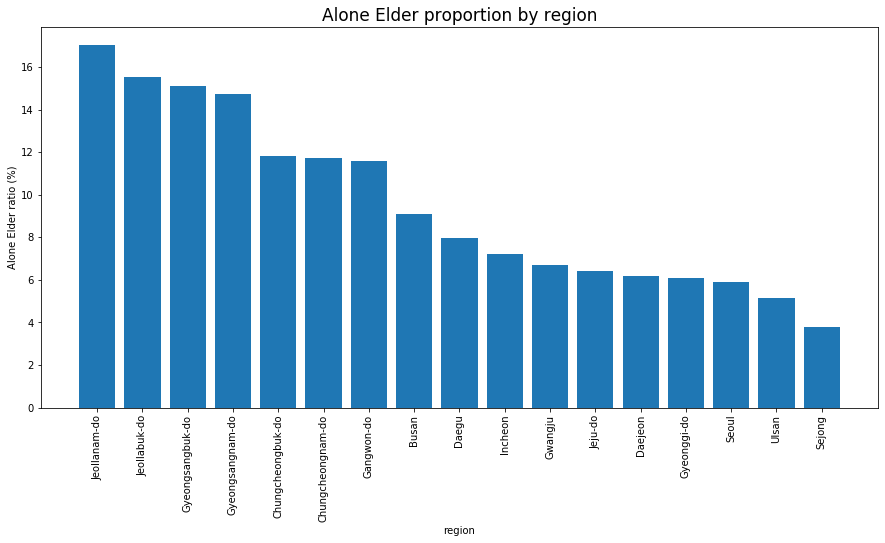

In [36]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Alone Elder proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_alone.index, region_alone.alone_ratio)
plt.xlabel('region')
plt.ylabel('Alone Elder ratio (%)')
plt.show()

分析結果：獨居老人的區域差異就比教育情形來得顯著許多。為了作出合理的假設，可能需要先釐清獨居老人的數量與都市化程度的關係。外部資料來源一樣是[http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007]

**獨居老人與人口之關係**

In [37]:
pop = [1790, 1820, 2674, 3356, 1619, 2180, 1521, 3400, 2450, 2939, 1493, 653, 1518, 13031, 9705, 1154, 304]
dense = [145, 226, 141, 318, 219, 265, 90, 4416, 2773, 2764, 2980, 353, 2813, 1279, 16034, 1088, 653]
region_alone['pop'] = pop
region_alone['dense'] = dense
display(region_alone)

alone_ratio    pop  dense
province                                    
Jeollanam-do         17.030435   1790    145
Jeollabuk-do         15.533333   1820    226
Gyeongsangbuk-do     15.133333   2674    141
Gyeongsangnam-do     14.721053   3356    318
Chungcheongbuk-do    11.825000   1619    219
Chungcheongnam-do    11.706250   2180    265
Gangwon-do           11.578947   1521     90
Busan                 9.094118   3400   4416
Daegu                 7.966667   2450   2773
Incheon               7.236364   2939   2764
Gwangju               6.716667   1493   2980
Jeju-do               6.400000    653    353
Daejeon               6.200000   1518   2813
Gyeonggi-do           6.084375  13031   1279
Seoul                 5.923077   9705  16034
Ulsan                 5.166667   1154   1088
Sejong                3.800000    304    653

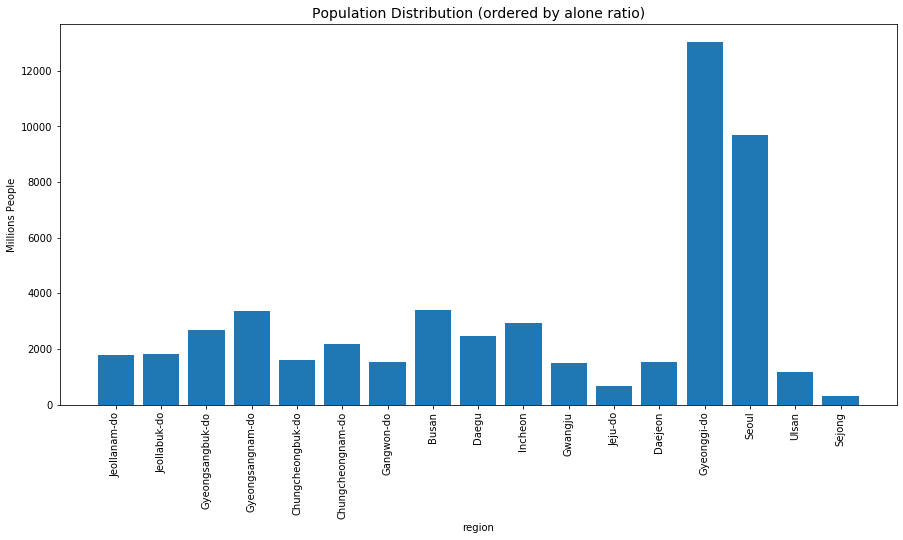

In [38]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Population Distribution (ordered by alone ratio)', fontsize=14)
plt.xticks(rotation=90)
plt.bar(region_alone.index, region_alone['pop'])
plt.xlabel('region')
plt.ylabel('Millions People')
plt.show()

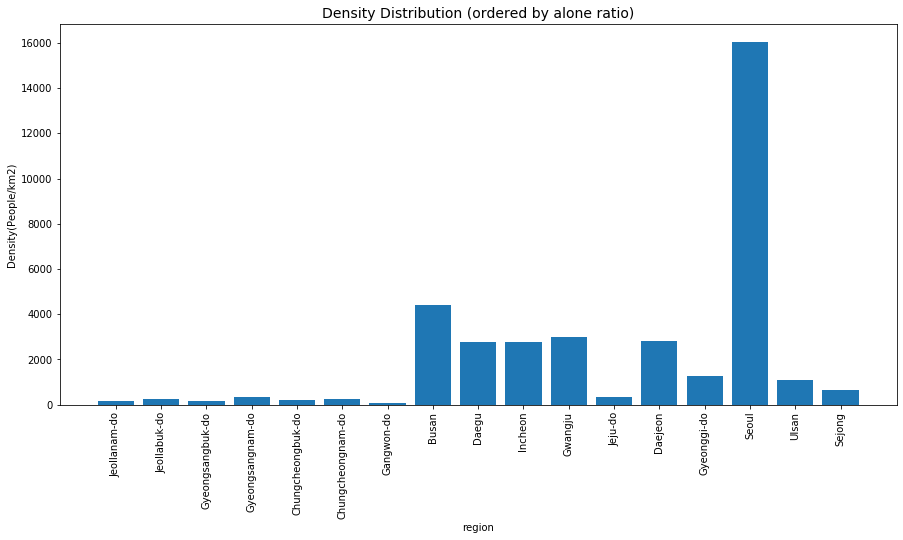

In [39]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Density Distribution (ordered by alone ratio)', fontsize=14)
plt.xticks(rotation=90)
plt.bar(region_alone.index, region_alone['dense'])
plt.xlabel('region')
plt.ylabel('Density(People/km2)')
plt.show()

分析結果：單從密度分布已可推斷大都市的獨居老人比例都是普遍偏低的，比較密集也意味著減少獨居的機會。利用這個特點假設確診數高的區域傾向為獨居老人多的區域。初步的猜想是獨居的老人不太會跟別人互動，進而降低傳染機會。

**與確診數之關係**

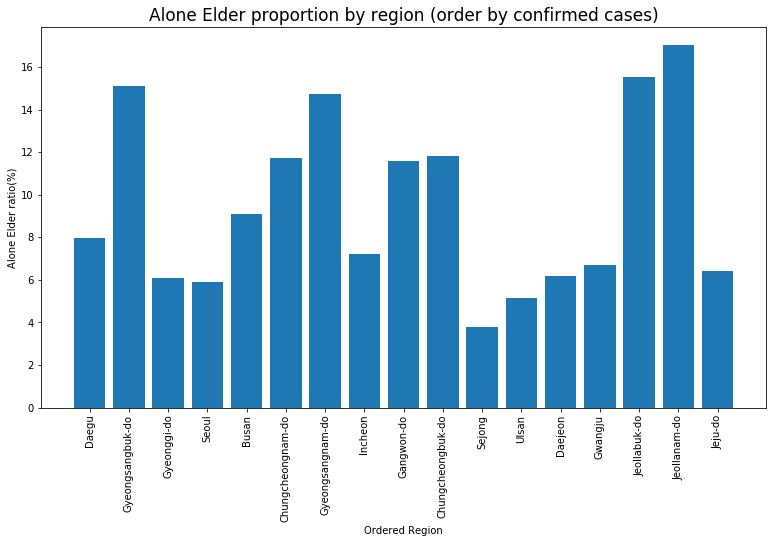

In [40]:
region_alone_order = pd.DataFrame()
for order in confirm_order:
    new_row = {'province':order, 'alone_ratio':region_alone.at[order,'alone_ratio']}
    region_alone_order  = region_alone_order.append(new_row,ignore_index=True)
region_alone_order  = region_alone_order [['province','alone_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Alone Elder proportion by region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Alone Elder ratio(%)')
plt.bar(region_alone_order.province, region_alone_order.alone_ratio)
plt.show()

分析結果：似乎沒有展示出太大的相關性，顯示獨居老人的比率並不是什麼很有力的證據。

### 療養院數量層面

**各地療養院情形對比**

In [41]:
region_nurse = pd.DataFrame()
region_nurse['nurse_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().nursing_home_count
region_nurse['nurse_ratio'] =region_nurse['nurse_ratio'] / region_nurse['nurse_ratio'].sum() * 100
region_nurse = region_nurse.sort_values(ascending=False, by = 'nurse_ratio')
region_nurse

nurse_ratio
province                      
Seoul                13.485947
Gyeonggi-do           9.874080
Jeju-do               9.598929
Daegu                 8.708855
Daejeon               7.668864
Gwangju               7.329624
Incheon               6.303963
Busan                 6.124448
Ulsan                 4.628560
Gyeongsangnam-do      4.353300
Jeollabuk-do          3.879664
Sejong                3.785602
Chungcheongbuk-do     3.558157
Chungcheongnam-do     3.509006
Gyeongsangbuk-do      2.874539
Jeollanam-do          2.272099
Gangwon-do            2.044363

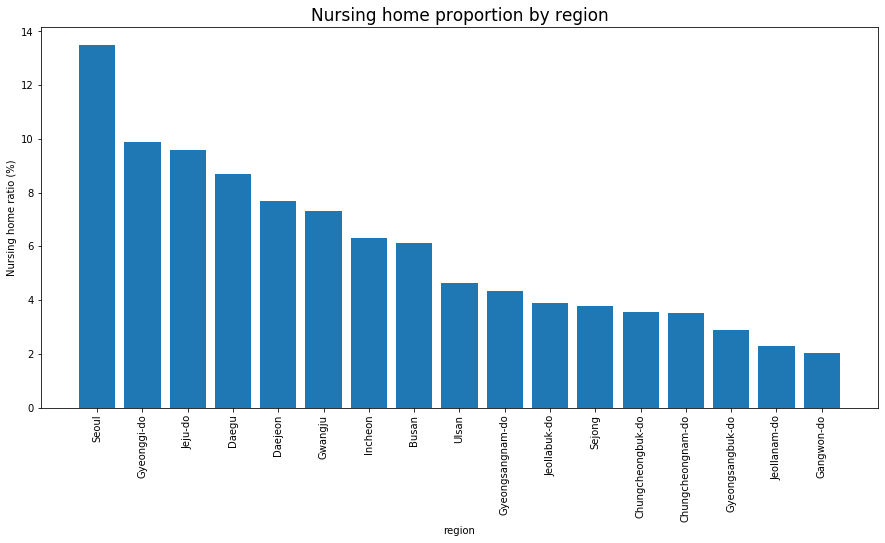

In [42]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Nursing home proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_nurse.index, region_nurse.nurse_ratio)
plt.xlabel('region')
plt.ylabel('Nursing home ratio (%)')
plt.show()

分析結果：對這個的特徵著手的動機是對各地區的醫療水準與確診數的相對數量呈現怎麼樣的一個相關。而療養院的數量應該可以作為參考性的指標。

**與確診數之關係**

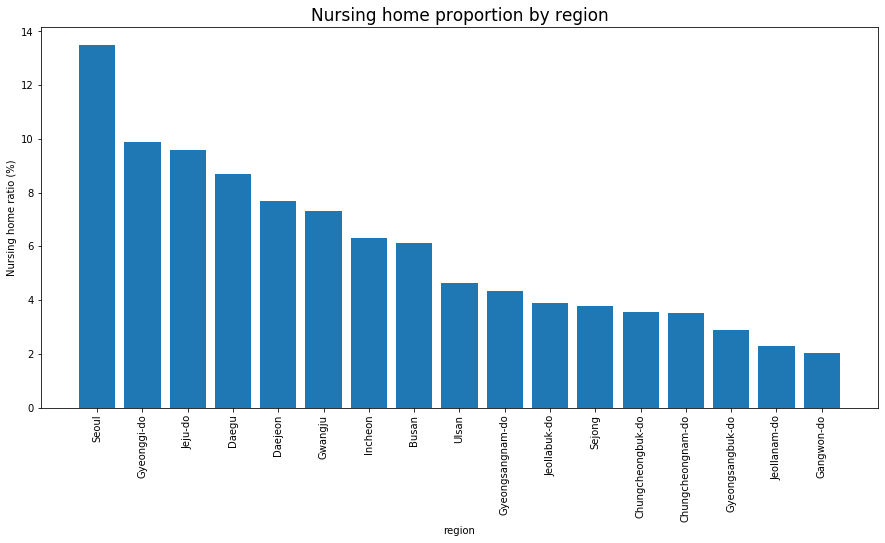

In [43]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Nursing home proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_nurse.index, region_nurse.nurse_ratio)
plt.xlabel('region')
plt.ylabel('Nursing home ratio (%)')
plt.show()

分析結果：一樣是十分紛亂無法看出強的相關性。不過慶尚北道的療養院數偏低，確診數卻排在前面，或許是一個警訊。

### 1-3 地區性之足跡分析

**各地足跡之分布**

In [44]:
df_route = patientRoute
display(df_route.head(5).append(df_route.tail(5)))

patient_id  global_num        date          province          city  \
0     1000000001         2.0  2020-01-22       Gyeonggi-do      Gimpo-si   
1     1000000001         2.0  2020-01-24             Seoul       Jung-gu   
2     1000000002         5.0  2020-01-25             Seoul   Seongbuk-gu   
3     1000000002         5.0  2020-01-26             Seoul   Seongbuk-gu   
4     1000000002         5.0  2020-01-26             Seoul  Seongdong-gu   
7274  6100000090         NaN  2020-03-24             Seoul    Gangseo-gu   
7275  6100000090         NaN  2020-03-24             Busan    Gangseo-gu   
7276  6100000090         NaN  2020-03-25  Gyeongsangnam-do    Yangsan-si   
7277  6100000090         NaN  2020-03-25  Gyeongsangnam-do    Yangsan-si   
7278  6100000090         NaN  2020-03-25  Gyeongsangnam-do    Yangsan-si   

                       type   latitude   longitude  
0                   airport  37.615246  126.715632  
1                  hospital  37.567241  127.005659  
2                       etc  37.592560  127.017048  
3                     store  37.591810  127.016822  
4     public_transportation  37.563992  127.029534  
7274                airport  37.558654  126.794474  
7275                airport  35.173220  128.946459  
7276                  store  35.336944  129.026389  
7277               hospital  35.335757  129.025003  
7278                  store  35.336944  129.026389

In [45]:
route_region = pd.DataFrame()
route_count = df_route.groupby('province').count()
display(route_count)
route_region['region'] = route_count.index
route_region['records'] = route_count.patient_id.values
route_region = route_region.sort_values('records', ascending=False)
route_region

patient_id  global_num  date  city  type  latitude  \
province                                                                
Busan                     728           5   728   728   728       728   
Chungcheongbuk-do         149           8   149   149   149       149   
Chungcheongnam-do         685          15   685   685   685       685   
Daegu                     266          87   266   266   266       266   
Daejeon                    46           6    46    46    46        46   
Gangwon-do                324          24   324   324   324       324   
Gwangju                   122         110   122   122   122       122   
Gyeonggi-do               262         179   262   262   262       262   
Gyeongsangbuk-do          856         208   856   856   856       856   
Gyeongsangnam-do          239           5   239   239   239       239   
Incheon                   434         385   434   434   434       434   
Jeju-do                    16          13    16    16    16        16   
Jeollabuk-do               17          14    17    17    17        17   
Jeollanam-do               43          37    43    43    43        43   
Seoul                    3029        2934  3029  3029  3029      3029   
Ulsan                      63           4    63    63    63        63   

                   longitude  
province                      
Busan                    728  
Chungcheongbuk-do        149  
Chungcheongnam-do        685  
Daegu                    266  
Daejeon                   46  
Gangwon-do               324  
Gwangju                  122  
Gyeonggi-do              262  
Gyeongsangbuk-do         856  
Gyeongsangnam-do         239  
Incheon                  434  
Jeju-do                   16  
Jeollabuk-do              17  
Jeollanam-do              43  
Seoul                   3029  
Ulsan                     63

region  records
14              Seoul     3029
8    Gyeongsangbuk-do      856
0               Busan      728
2   Chungcheongnam-do      685
10            Incheon      434
5          Gangwon-do      324
3               Daegu      266
7         Gyeonggi-do      262
9    Gyeongsangnam-do      239
1   Chungcheongbuk-do      149
6             Gwangju      122
15              Ulsan       63
4             Daejeon       46
13       Jeollanam-do       43
12       Jeollabuk-do       17
11            Jeju-do       16

由於地區的數量過多，而且某些區的記錄少到幾乎看不太出來，因此將記錄比較少(<=200)的區域合併成 `Others`

In [46]:
new_row = {'region':'Others', 'records':route_region.iloc[8:,1].sum()}
#append row to the dataframe
route_region = route_region.append(new_row, ignore_index=True).sort_values('records', ascending=False)[0:10]
route_region


region  records
0               Seoul     3029
1    Gyeongsangbuk-do      856
2               Busan      728
16             Others      695
3   Chungcheongnam-do      685
4             Incheon      434
5          Gangwon-do      324
6               Daegu      266
7         Gyeonggi-do      262
8    Gyeongsangnam-do      239

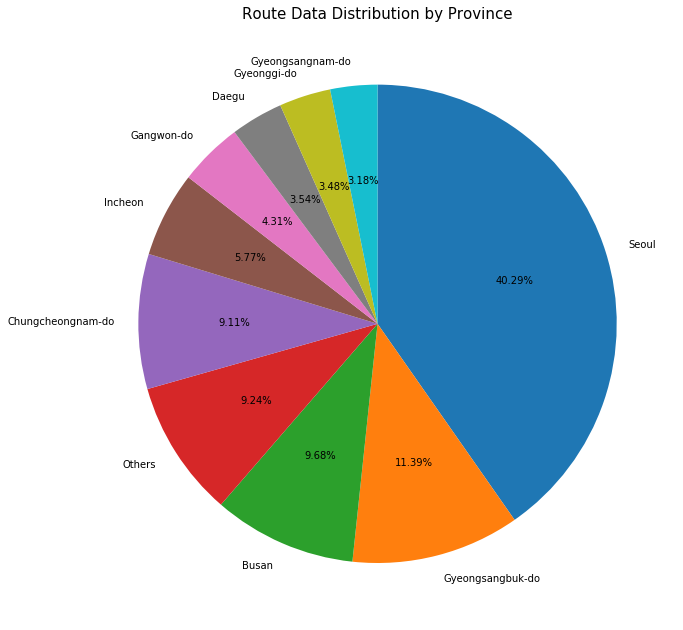

In [47]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Route Data Distribution by Province', fontsize=15)
plt.pie(route_region.records
        , labels=route_region.region
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()

- 分析結果:
    從上面的圓餅圖我們可看到首爾擁有相對最大宗的記錄，然而和最嚴重的爆發區相比數量幾乎是其十倍。這說明了有歸檔的足跡數與確診數沒有太大的關聯
    ，只能說明首爾是最大的都市，追蹤的系統最完善因此擁有的記錄也最多。

**單一病人擁有記錄統計**

In [48]:
route_patient = pd.DataFrame()
patient_count = df_route.groupby('patient_id').count()
display(patient_count.head(10))
route_patient['patient'] = patient_count.index
route_patient['records'] = patient_count.type.values
route_patient = route_patient.sort_values('records', ascending=False)
route_patient.head(5).append(route_patient.tail(5))


global_num  date  province  city  type  latitude  longitude
patient_id                                                             
1000000001           2     2         2     2     2         2          2
1000000002          13    13        13    13    13        13         13
1000000003           2     2         2     2     2         2          2
1000000004           1     1         1     1     1         1          1
1000000005           1     1         1     1     1         1          1
1000000006           1     1         1     1     1         1          1
1000000007           1     1         1     1     1         1          1
1000000008           1     1         1     1     1         1          1
1000000009          10    10        10    10    10        10         10
1000000010           4     4         4     4     4         4          4

patient  records
376   1000000417       45
906   3009000014       42
799   1400000021       38
905   3009000013       37
1178  6016000012       36
55    1000000059        1
565   1000000635        1
813   1400000040        1
815   1400000042        1
835   1600000021        1

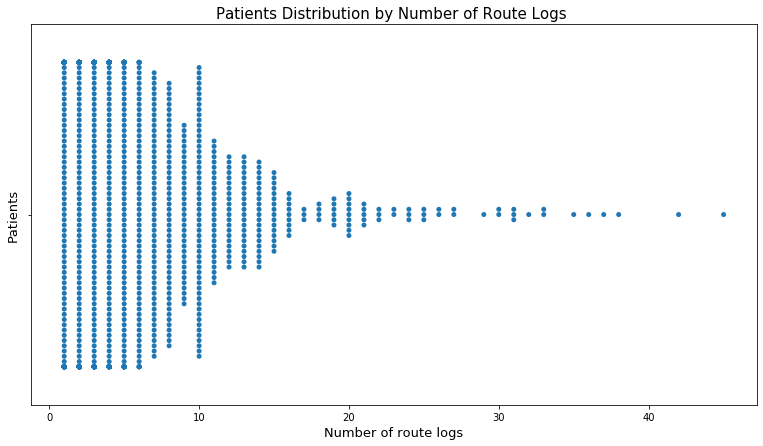

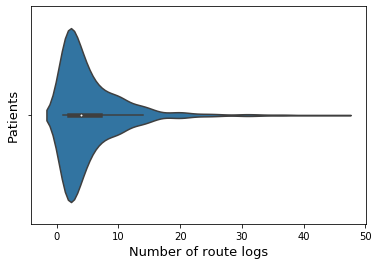

In [49]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Patients Distribution by Number of Route Logs ', fontsize=15)
ax.set_xlabel('Number of route logs', size=13)
ax.set_ylabel('Patients', size=13)
sns.swarmplot(route_patient.records.values)
plt.show()
ax = sns.violinplot(x=route_patient.records.values)
ax.set_xlabel('Number of route logs', size=13)
ax.set_ylabel('Patients', size=13)
plt.show()

分析結果：由上面兩張圖可看出一名病患擁有的行蹤履歷主要集中在1到10位左右，但還是有零星的記錄特別多的病患。以下將對這些outlier仔細檢查其特徵。

**擁有過多足跡病患之特徵分析**

In [50]:
stat = route_patient.records.describe()
print(stat)
outlier_num = int(stat['75%'] + 1.5 * (stat['75%'] - stat['25%']))
outlier_count = len(route_patient[route_patient.records > outlier_num])
print(f'outlier為超過{outlier_num}人以上，共有{outlier_count}人')

count    1319.000000
mean        5.518575
std         5.592192
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        45.000000
Name: records, dtype: float64
outlier為超過14人以上，共有82人


In [51]:
patient_org = pd.read_csv(datasets[7])
print('擁有最多足跡的五名病患')
edge_ids = route_patient.head(5).patient.values
patient_most = pd.DataFrame()
for ids in edge_ids:
    temp = patient_org[patient_org.patient_id == ids]
    temp['records'] = route_patient[route_patient.patient == ids].records.values[0]
    patient_most = patient_most.append(temp)
    
display(patient_most.T)


擁有最多足跡的五名病患


416                 1908                 968   \
patient_id               1000000417          3009000014           1400000021   
global_num                     9644                 NaN                 7628   
sex                          female                male                 male   
birth_year                     1992                1969                 1992   
age                             20s                 50s                  20s   
country                       Korea               Korea                Korea   
province                      Seoul          Gangwon-do              Incheon   
city                        Mapo-gu            Wonju-si           Namdong-gu   
disease                         NaN                 NaN                  NaN   
infection_case      overseas inflow  Shincheonji Church  Guro-gu Call Center   
infection_order                 NaN                 NaN                  NaN   
infected_by                     NaN                 NaN                  NaN   
contact_number                  NaN                  17                  NaN   
symptom_onset_date              NaN                 NaN                  NaN   
confirmed_date           2020-03-29          2020-03-04           2020-03-09   
released_date                   NaN          2020-03-28           2020-04-05   
deceased_date                   NaN                 NaN                  NaN   
state                      released            released             released   
records                          45                  42                   38   

                                    1907                  3169  
patient_id                    3009000013            6016000012  
global_num                           NaN                   NaN  
sex                                 male                  male  
birth_year                          1954                  2000  
age                                  60s                   20s  
country                            Korea                 Korea  
province                      Gangwon-do      Gyeongsangbuk-do  
city                            Wonju-si           Yecheon-gun  
disease                              NaN                   NaN  
infection_case      contact with patient  contact with patient  
infection_order                      NaN                   NaN  
infected_by                          NaN             6.016e+09  
contact_number                         8                   NaN  
symptom_onset_date                   NaN                   NaN  
confirmed_date                2020-03-04            2020-04-10  
released_date                        NaN                   NaN  
deceased_date                        NaN                   NaN  
state                           released              isolated  
records                               37                    36

註：Outlier的算法為 Q3 + 1.5 * (Q3 − Q1)

分析結果:從上面的圓餅圖我們可看到足跡最廣的過半數都是年輕人，而且他們幾乎都出院了，或許這是因為免疫力比較強的人比較會到處趴趴走。並且顯示出男性遠超過女性的比例（有可能是男性比較喜歡出去外面，或比較誠實匯報自己的行蹤），另外病患的接觸數非空值的都不低，可以合理推斷那些沒有資料的也應該與不少病患接觸過。

**最常去的地點統計**

In [52]:
patient_type = pd.DataFrame()
type_count = df_route.groupby('type').count()
display(type_count)

patient_type['type'] = type_count.index
patient_type['records'] = type_count.date.values
patient_type = patient_type.sort_values('records', ascending=False)
patient_type.set_index('type' , inplace=True)
display(patient_type)


patient_id  global_num  date  province  city  \
type                                                                        
academy                              15           6    15        15    15   
administrative_area_level_1          14           0    14        14    14   
airport                             262         204   262       262   262   
bakery                               27          13    27        27    27   
bank                                 33          17    33        33    33   
bar                                  26          23    26        26    26   
beauty_salon                         21           9    21        21    21   
cafe                                123          75   123       123   123   
church                              152          93   152       152   152   
etc                                2152         955  2152      2152  2152   
gas_station                          12           4    12        12    12   
gym                                  24          13    24        24    24   
hospital                           2106        1329  2106      2106  2106   
karaoke                              11           5    11        11    11   
lodging                              45          25    45        45    45   
park                                 10           4    10        10    10   
pc_cafe                              84          38    84        84    84   
pharmacy                            240         107   240       240   240   
post_office                          18          12    18        18    18   
public_transportation               550         397   550       550   550   
real_estate_agency                   19          19    19        19    19   
restaurant                          576         332   576       576   576   
school                               58          18    58        58    58   
store                               687         332   687       687   687   
university                           14           4    14        14    14   

                             latitude  longitude  
type                                              
academy                            15         15  
administrative_area_level_1        14         14  
airport                           262        262  
bakery                             27         27  
bank                               33         33  
bar                                26         26  
beauty_salon                       21         21  
cafe                              123        123  
church                            152        152  
etc                              2152       2152  
gas_station                        12         12  
gym                                24         24  
hospital                         2106       2106  
karaoke                            11         11  
lodging                            45         45  
park                               10         10  
pc_cafe                            84         84  
pharmacy                          240        240  
post_office                        18         18  
public_transportation             550        550  
real_estate_agency                 19         19  
restaurant                        576        576  
school                             58         58  
store                             687        687  
university                         14         14

records
type                                
etc                             2152
hospital                        2106
store                            687
restaurant                       576
public_transportation            550
airport                          262
pharmacy                         240
church                           152
cafe                             123
pc_cafe                           84
school                            58
lodging                           45
bank                              33
bakery                            27
bar                               26
gym                               24
beauty_salon                      21
real_estate_agency                19
post_office                       18
academy                           15
administrative_area_level_1       14
university                        14
gas_station                       12
karaoke                           11
park                              10

由於類別過多，以下將整併為食衣住行育樂，再加上以些特別的場所以利圖形的繪製。

In [53]:
route_type = pd.DataFrame()
directs = ['hospital','etc','store','pharmacy','church']
for direct in directs:
    new_row = {'type':direct, 'records':patient_type.at[direct,'records']}
    route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0   2106.0  hospital
1   2152.0       etc
2    687.0     store
3    240.0  pharmacy
4    152.0    church

將 `restaurant`、`cafe`、 `pc_cafe`、`bakery` 合併為 `食(Eat)`

In [54]:
eat_types = ['restaurant','cafe','pc_cafe','bakery']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Eat', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0   2106.0  hospital
1   2152.0       etc
2    687.0     store
3    240.0  pharmacy
4    152.0    church
5    810.0       Eat

將 `lodging`、`real_estate_agency` 合併為 `住(Lodge)`

In [55]:
eat_types = ['lodging','real_estate_agency']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Lodge', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0   2106.0  hospital
1   2152.0       etc
2    687.0     store
3    240.0  pharmacy
4    152.0    church
5    810.0       Eat
6     64.0     Lodge

將 `public_transportation`、`airport`、 `gas_station`合併為 `行(Traffic)`

In [56]:
eat_types = ['public_transportation','airport','gas_station']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Traffic', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0   2106.0  hospital
1   2152.0       etc
2    687.0     store
3    240.0  pharmacy
4    152.0    church
5    810.0       Eat
6     64.0     Lodge
7    824.0   Traffic

將 `school`、`academy`、 `university`合併為 `育(School)`

In [57]:
eat_types = ['school','academy','university']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'School', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0   2106.0  hospital
1   2152.0       etc
2    687.0     store
3    240.0  pharmacy
4    152.0    church
5    810.0       Eat
6     64.0     Lodge
7    824.0   Traffic
8     87.0    School

將 `gym`、`beauty_salon`、 `karaoke`、`park` 合併為 `樂(Fun)`

In [58]:
eat_types = ['gym','beauty_salon','karaoke','park']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Fun', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0   2106.0  hospital
1   2152.0       etc
2    687.0     store
3    240.0  pharmacy
4    152.0    church
5    810.0       Eat
6     64.0     Lodge
7    824.0   Traffic
8     87.0    School
9     66.0       Fun

將 `bank`、`post_office`、 `administrative_area_level_1` 合併為 `工作(Office)`

In [59]:
eat_types = ['bank','post_office','administrative_area_level_1']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Office', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

records      type
0    2106.0  hospital
1    2152.0       etc
2     687.0     store
3     240.0  pharmacy
4     152.0    church
5     810.0       Eat
6      64.0     Lodge
7     824.0   Traffic
8      87.0    School
9      66.0       Fun
10     65.0    Office

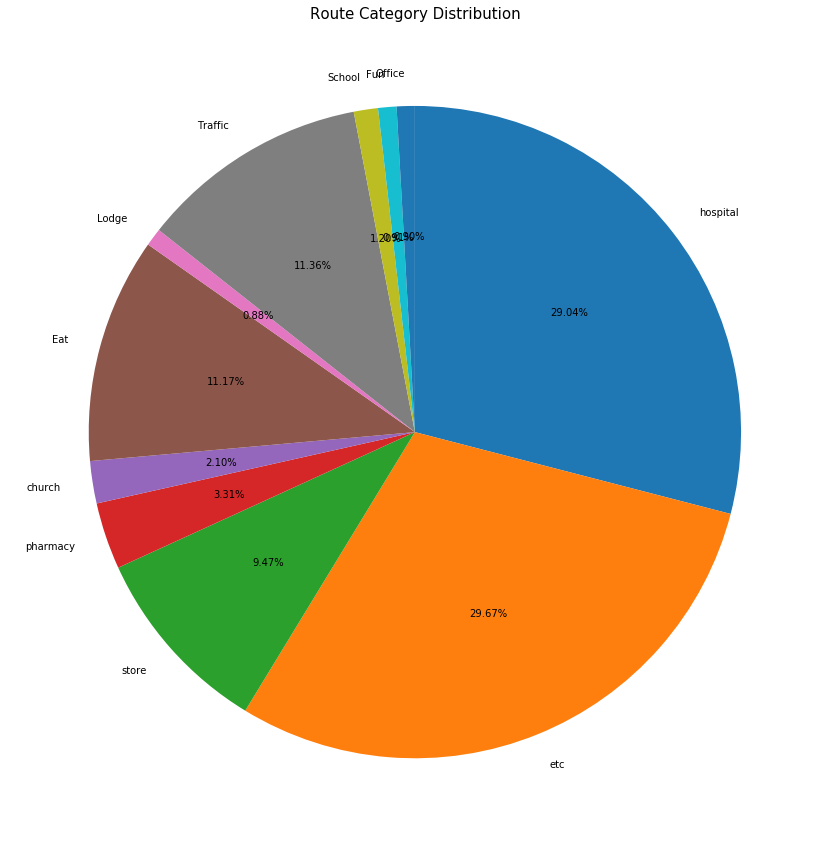

In [60]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title(f'Route Category Distribution', fontsize=15)
plt.pie(route_type.records
        , labels=route_type.type
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()

分析結果：從上圖可得知去醫院的記錄比重還是最大的（畢竟被送到醫院去一定有記錄），再來是生活必須的「食」、「行」部分。造成疫情大爆發的教堂沒有想像中的多，也沒看出有很多人去藥局領藥的這個傾向。育樂的比例也很低，和學校、公司等差不多。不過需要注意的是無法歸類的也佔很大的一部分，很可能需要分配一些給育樂類以及工作類，畢竟這兩個類別最有隱匿的可能性。

**足跡變動量趨勢分析**

本小節的目的在於探討每日病患記錄總量的變動趨勢與新增確診數之關係。記錄越多，很有可能人民和政府的憂患意識也越大，能達到抑制確診數的效果也說不定。首先將資料以每日統計並標準化。

In [61]:
df_daily_log = df_route.groupby('date').count()[:-13]
df_daily_log['total'] = df_daily_log['patient_id']
df_daily_log = df_daily_log[['total']]
df_daily_log = df_daily_log.reset_index()
display(df_daily_log.head(5).append(df_daily_log.tail(5)))

df_daily_log['total'].unique()

date  total
0    2020-01-20      1
1    2020-01-21      1
2    2020-01-22      2
3    2020-01-23      2
4    2020-01-24      5
97   2020-04-26     12
98   2020-04-27      4
99   2020-04-28      4
100  2020-04-29      1
101  2020-04-30      6

array([  1,   2,   5,  14,  10,   9,   7,   4,  16,   6,   8,  13,  11,
        18,  23,  26, 109, 134, 170, 236, 267, 319, 254, 197, 328, 216,
       241, 226, 199, 165, 106, 154, 126, 115, 123, 172, 140, 114, 161,
       122,  77,  60,  54,  56,  59,  74,  85,  83,  72,  62,  33,  57,
        89,  90,  88,  44,  70,  42,  76,  65,  71,  40,  28,  24,  22,
        17,  15,  12], dtype=int64)

In [62]:
#計算每日新增確診數
for index, row in df_daily_log.iterrows():
    
    if index == 0:
        df_daily_log.at[index,'new_logged'] = 1
    else:
        df_daily_log.at[index,'new_logged'] = df_daily_log.at[index,'total'] - df_daily_log.at[index - 1,'total']
display(df_daily_log.head(5).append(df_daily_log.tail(5)))

date  total  new_logged
0    2020-01-20      1         1.0
1    2020-01-21      1         0.0
2    2020-01-22      2         1.0
3    2020-01-23      2         0.0
4    2020-01-24      5         3.0
97   2020-04-26     12         6.0
98   2020-04-27      4        -8.0
99   2020-04-28      4         0.0
100  2020-04-29      1        -3.0
101  2020-04-30      6         5.0

In [63]:
#正規化每日新增確診數
df_daily_log_describe = df_daily_log['new_logged'].describe()
display(df_daily_log_describe)
mean = (df_daily_log_describe.loc['mean'])
std = (df_daily_log_describe.loc['std'])
df_daily_log['std_new_logged'] = df_daily_log['new_logged'].apply(lambda x : (x - mean) / std)
display(df_daily_log.head(5).append(df_daily_log.tail(5)))

count    102.000000
mean       0.058824
std       29.288535
min     -112.000000
25%       -9.500000
50%        0.000000
75%        5.750000
max      131.000000
Name: new_logged, dtype: float64

date  total  new_logged  std_new_logged
0    2020-01-20      1         1.0        0.032135
1    2020-01-21      1         0.0       -0.002008
2    2020-01-22      2         1.0        0.032135
3    2020-01-23      2         0.0       -0.002008
4    2020-01-24      5         3.0        0.100421
97   2020-04-26     12         6.0        0.202850
98   2020-04-27      4        -8.0       -0.275153
99   2020-04-28      4         0.0       -0.002008
100  2020-04-29      1        -3.0       -0.104438
101  2020-04-30      6         5.0        0.168707

In [64]:
df_time = pd.read_csv(datasets[4])
df_float_time = df_time[:-14]
display(df_float_time.head(5).append(df_float_time.tail(5)))

date  time    test  negative  confirmed  released  deceased
0    2020-01-20    16       1         0          1         0         0
1    2020-01-21    16       1         0          1         0         0
2    2020-01-22    16       4         3          1         0         0
3    2020-01-23    16      22        21          1         0         0
4    2020-01-24    16      27        25          2         0         0
97   2020-04-26     0  598285    578558      10728      8717       242
98   2020-04-27     0  601660    582027      10738      8764       243
99   2020-04-28     0  608514    588559      10752      8854       244
100  2020-04-29     0  614197    595129      10761      8922       246
101  2020-04-30     0  619881    600482      10765      9059       247

In [65]:
#計算每日新增確診數
for index, row in df_float_time.iterrows():
    
    if index == 0:
        df_float_time.at[index,'new_confirmed'] = 1
    else:
        df_float_time.at[index,'new_confirmed'] = df_float_time.at[index,'confirmed'] - df_float_time.at[index - 1,'confirmed']
display(df_float_time.head(5).append(df_float_time.tail(5)))

date  time    test  negative  confirmed  released  deceased  \
0    2020-01-20    16       1         0          1         0         0   
1    2020-01-21    16       1         0          1         0         0   
2    2020-01-22    16       4         3          1         0         0   
3    2020-01-23    16      22        21          1         0         0   
4    2020-01-24    16      27        25          2         0         0   
97   2020-04-26     0  598285    578558      10728      8717       242   
98   2020-04-27     0  601660    582027      10738      8764       243   
99   2020-04-28     0  608514    588559      10752      8854       244   
100  2020-04-29     0  614197    595129      10761      8922       246   
101  2020-04-30     0  619881    600482      10765      9059       247   

     new_confirmed  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              1.0  
97            10.0  
98            10.0  
99            14.0  
100            9.0  
101            4.0

In [66]:
#正規化每日新增確診數
new_confirmed_describe = df_float_time['new_confirmed'].describe()
display(new_confirmed_describe)
mean = (new_confirmed_describe.loc['mean'])
std = (new_confirmed_describe.loc['std'])
df_float_time['std_new_confirmed'] = df_float_time['new_confirmed'].apply(lambda x : (x - mean) / std)
display(df_float_time.head(5).append(df_float_time.tail(5)))

count    102.000000
mean     105.539216
std      166.330023
min        0.000000
25%        2.250000
50%       31.000000
75%      109.250000
max      813.000000
Name: new_confirmed, dtype: float64

date  time    test  negative  confirmed  released  deceased  \
0    2020-01-20    16       1         0          1         0         0   
1    2020-01-21    16       1         0          1         0         0   
2    2020-01-22    16       4         3          1         0         0   
3    2020-01-23    16      22        21          1         0         0   
4    2020-01-24    16      27        25          2         0         0   
97   2020-04-26     0  598285    578558      10728      8717       242   
98   2020-04-27     0  601660    582027      10738      8764       243   
99   2020-04-28     0  608514    588559      10752      8854       244   
100  2020-04-29     0  614197    595129      10761      8922       246   
101  2020-04-30     0  619881    600482      10765      9059       247   

     new_confirmed  std_new_confirmed  
0              1.0          -0.628505  
1              0.0          -0.634517  
2              0.0          -0.634517  
3              0.0          -0.634517  
4              1.0          -0.628505  
97            10.0          -0.574395  
98            10.0          -0.574395  
99            14.0          -0.550347  
100            9.0          -0.580408  
101            4.0          -0.610468

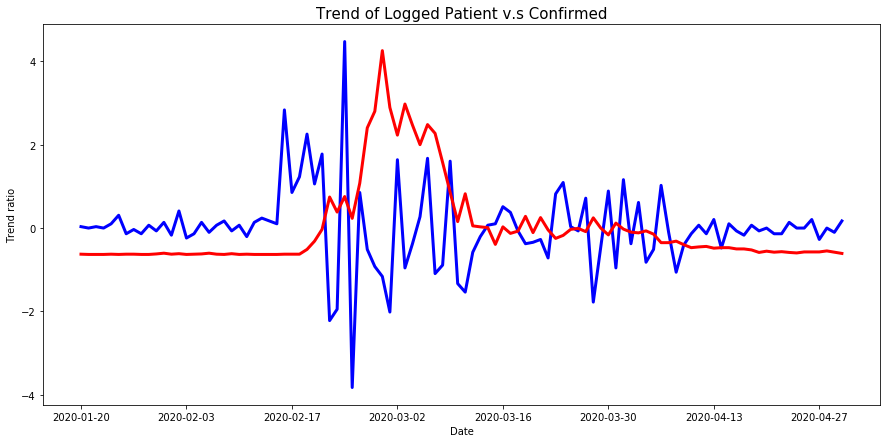

In [67]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Trend of Logged Patient v.s Confirmed', size=15)
plt.plot(df_daily_log['date'], df_daily_log['std_new_logged']
         , color='blue'
         , lw=3)

plt.plot(df_float_time['date'], df_float_time['std_new_confirmed']
         , color='red'
         , lw=3)

ax.set_xticks(ax.get_xticks()[::14])
plt.xlabel('Date')
plt.ylabel('Trend ratio')
plt.show()

分析結果：2月20幾號那個極端的波峰是個很好的預兆，果然幾天後確診數就來到了高點。隨著確診數趨於平淡，記錄的變化值是產生了震盪才趨於平緩，說明人們警戒的狀況需要一段時間才能平復。值得一提的是好幾次足跡的記錄來到局部最低值時，後面確診數常常都有上升的趨勢，這提醒了我們不能輕易對疫情鬆懈。

**最早記錄日期與確認日期差距分析**

這個小節並不作視覺化而是單純的統計，主要是探討一個病人被診出後平均可追溯的記錄是幾天。並試著分析某些特別的個案其共同擁有的特性。

In [68]:
df_route_diff = df_route.groupby('patient_id').min().reset_index()
display(df_route_diff)

patient_id  global_num        date          province           city  \
0     1000000001         2.0  2020-01-22       Gyeonggi-do       Gimpo-si   
1     1000000002         5.0  2020-01-25             Seoul  Dongdaemun-gu   
2     1000000003         6.0  2020-01-26             Seoul      Jongno-gu   
3     1000000004         7.0  2020-01-30             Seoul    Jungnang-gu   
4     1000000005         9.0  2020-01-31             Seoul    Jungnang-gu   
...          ...         ...         ...               ...            ...   
1314  6100000086         NaN  2020-03-14             Daegu    Changwon-si   
1315  6100000087         NaN  2020-03-15  Gyeongsangnam-do    Changwon-si   
1316  6100000088         NaN  2020-03-05  Gyeongsangnam-do    Changwon-si   
1317  6100000089         NaN  2020-03-21  Gyeongsangnam-do      Haman-gun   
1318  6100000090         NaN  2020-03-24             Busan     Gangseo-gu   

          type   latitude   longitude  
0      airport  37.567241  126.715632  
1          etc  37.523674  127.009766  
2       church  37.572950  126.979358  
3     hospital  37.612772  127.098167  
4     hospital  37.612772  127.098167  
...        ...        ...         ...  
1314      bank  35.219921  128.466686  
1315       etc  35.226772  128.639094  
1316    bakery  35.222376  128.642847  
1317       etc  35.275725  128.410312  
1318   airport  35.173220  126.440696  

[1319 rows x 8 columns]

In [69]:
df_pat = pd.read_csv(datasets[7])
df_pat = df_pat[['patient_id','confirmed_date']]
display(df_pat.head(5).append(df_pat.tail(5)))

patient_id confirmed_date
0     1000000001     2020-01-23
1     1000000002     2020-01-30
2     1000000003     2020-01-30
3     1000000004     2020-01-30
4     1000000005     2020-01-31
3514  7000000010     2020-04-03
3515  7000000011     2020-04-03
3516  7000000012     2020-04-03
3517  7000000013     2020-04-14
3518  7000000014     2020-05-09

In [70]:
df_merge_diff = pd.merge(df_route_diff,df_pat, on='patient_id')
display(df_merge_diff)

patient_id  global_num        date          province           city  \
0     1000000001         2.0  2020-01-22       Gyeonggi-do       Gimpo-si   
1     1000000002         5.0  2020-01-25             Seoul  Dongdaemun-gu   
2     1000000003         6.0  2020-01-26             Seoul      Jongno-gu   
3     1000000004         7.0  2020-01-30             Seoul    Jungnang-gu   
4     1000000005         9.0  2020-01-31             Seoul    Jungnang-gu   
...          ...         ...         ...               ...            ...   
1314  6100000086         NaN  2020-03-14             Daegu    Changwon-si   
1315  6100000087         NaN  2020-03-15  Gyeongsangnam-do    Changwon-si   
1316  6100000088         NaN  2020-03-05  Gyeongsangnam-do    Changwon-si   
1317  6100000089         NaN  2020-03-21  Gyeongsangnam-do      Haman-gun   
1318  6100000090         NaN  2020-03-24             Busan     Gangseo-gu   

          type   latitude   longitude confirmed_date  
0      airport  37.567241  126.715632     2020-01-23  
1          etc  37.523674  127.009766     2020-01-30  
2       church  37.572950  126.979358     2020-01-30  
3     hospital  37.612772  127.098167     2020-01-30  
4     hospital  37.612772  127.098167     2020-01-31  
...        ...        ...         ...            ...  
1314      bank  35.219921  128.466686     2020-03-19  
1315       etc  35.226772  128.639094     2020-03-21  
1316    bakery  35.222376  128.642847     2020-03-22  
1317       etc  35.275725  128.410312     2020-03-23  
1318   airport  35.173220  126.440696     2020-03-26  

[1319 rows x 9 columns]

In [71]:
#Redundancy Check
df_merge_diff['confirmed_date'].describe()

count           1319
unique            94
top       2020-02-28
freq              56
Name: confirmed_date, dtype: object

In [72]:
df_merge_diff['TimeDiff'] = pd.to_datetime(df_merge_diff['confirmed_date']) - pd.to_datetime(df_merge_diff['date'])
df_merge_diff['TimeDiff'] = df_merge_diff['TimeDiff'].apply(lambda x : x.days)
df_merge_diff

patient_id  global_num        date          province           city  \
0     1000000001         2.0  2020-01-22       Gyeonggi-do       Gimpo-si   
1     1000000002         5.0  2020-01-25             Seoul  Dongdaemun-gu   
2     1000000003         6.0  2020-01-26             Seoul      Jongno-gu   
3     1000000004         7.0  2020-01-30             Seoul    Jungnang-gu   
4     1000000005         9.0  2020-01-31             Seoul    Jungnang-gu   
...          ...         ...         ...               ...            ...   
1314  6100000086         NaN  2020-03-14             Daegu    Changwon-si   
1315  6100000087         NaN  2020-03-15  Gyeongsangnam-do    Changwon-si   
1316  6100000088         NaN  2020-03-05  Gyeongsangnam-do    Changwon-si   
1317  6100000089         NaN  2020-03-21  Gyeongsangnam-do      Haman-gun   
1318  6100000090         NaN  2020-03-24             Busan     Gangseo-gu   

          type   latitude   longitude confirmed_date  TimeDiff  
0      airport  37.567241  126.715632     2020-01-23         1  
1          etc  37.523674  127.009766     2020-01-30         5  
2       church  37.572950  126.979358     2020-01-30         4  
3     hospital  37.612772  127.098167     2020-01-30         0  
4     hospital  37.612772  127.098167     2020-01-31         0  
...        ...        ...         ...            ...       ...  
1314      bank  35.219921  128.466686     2020-03-19         5  
1315       etc  35.226772  128.639094     2020-03-21         6  
1316    bakery  35.222376  128.642847     2020-03-22        17  
1317       etc  35.275725  128.410312     2020-03-23         2  
1318   airport  35.173220  126.440696     2020-03-26         2  

[1319 rows x 10 columns]

In [73]:
#Redundancy Check
stat = df_merge_diff['TimeDiff'].describe()
display(stat)
lower_bound = int(stat['25%'] - 1.5 * (stat['75%'] - stat['25%']))
upper_bound = int(stat['75%'] + 1.5 * (stat['75%'] - stat['25%']))
lower_count = len(df_merge_diff[df_merge_diff.TimeDiff < lower_bound])
upper_count = len(df_merge_diff[df_merge_diff.TimeDiff > upper_bound])
outlier_count = lower_count + upper_count
print(f'outlier為超過{upper_bound}天以上及低於{lower_bound}天以下，共有{outlier_count}人')

count    1319.000000
mean        4.921911
std         5.137484
min        -7.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        51.000000
Name: TimeDiff, dtype: float64

outlier為超過14天以上及低於-5天以下，共有59人


分析結果：從統計的報表我們在韓國平均可以對一個已經確診的病患追蹤到4天前的記錄。但極值則有點詭異。最多51天前就有資料以及確診了7天後才有記錄的患者，都值得我們注意。以下將進行進一步的分析。

**非常早就有記錄的病患分析**

In [74]:
display(df_merge_diff[df_merge_diff.TimeDiff >= 14].tail(5))

patient_id  global_num        date          province          city  \
1250  6023000047         NaN  2020-02-24             Daegu       Jung-gu   
1297  6100000065         NaN  2020-02-18             Daegu  Dalseong-gun   
1300  6100000068         NaN  2020-02-18  Gyeongsangnam-do  Hapcheon-gun   
1311  6100000083         NaN  2020-02-22             Daegu        Buk-gu   
1316  6100000088         NaN  2020-03-05  Gyeongsangnam-do   Changwon-si   

        type   latitude   longitude confirmed_date  TimeDiff  
1250     etc  35.871435  128.601445     2020-03-09        14  
1297     etc  34.871963  128.465523     2020-03-03        14  
1300     etc  35.568029  128.163666     2020-03-04        15  
1311     etc  34.856049  128.588890     2020-03-10        17  
1316  bakery  35.222376  128.642847     2020-03-22        17

分析結果：這些是確診前非常早就有記錄的人，推測是與當時疫情爆發時的病人有在同一個場所或接觸，受到監控後在兩週後被檢驗出陽性反應。而地點正好是佔確診80%的大邱及慶尚南道，顯然是和新天地事件有所關聯。至於行蹤的etc究竟是什麼耐人尋味。甚至有超過了二週的潛伏期才被發現的患者存在。

**非常晚才有記錄的病患分析**

In [75]:
display(df_merge_diff[df_merge_diff.TimeDiff < 0].tail(5))

patient_id  global_num        date          province          city  \
1202  6020100054        54.0  2020-02-23  Gyeongsangbuk-do  Cheongdo-gun   
1203  6020100055        55.0  2020-02-23  Gyeongsangbuk-do  Cheongdo-gun   
1204  6020100107       107.0  2020-02-24  Gyeongsangbuk-do  Cheongdo-gun   
1205  6020100286       286.0  2020-02-23  Gyeongsangbuk-do  Cheongdo-gun   
1206  6020100298       298.0  2020-02-25  Gyeongsangbuk-do  Cheongdo-gun   

          type   latitude   longitude confirmed_date  TimeDiff  
1202  hospital  35.648617  128.736829     2020-02-19        -4  
1203  hospital  35.648617  128.736829     2020-02-19        -4  
1204  hospital  35.648617  128.736829     2020-02-21        -3  
1205  hospital  35.648617  128.736829     2020-02-22        -1  
1206  hospital  35.648617  128.736829     2020-02-22        -3

分析結果：這些都是確診後過了幾天才開始有足跡記錄的。類別都是醫院，說明他們可能都已經在隔離中了。而地區正好都是在慶尚北路的清道郡，或許我們應該懷疑那個地方的管理出了什麼樣的問題。而這裡的確出現了國內首起的死亡案例，以及和大邱被設為特別照護區。

# PartII 病患特徵層面分析
-----------------------------------
   ## 使用的資料集：
   
  ### PatientInfo
   資料集說明：
  本資料集是針對性別病患個別所作的記錄
  
 - infection_case : 該病患罹病原因(地點相關)
 
 
  ### TimeAge
  資料集說明：
 本資料集是針對不同年齡層病患個別所作的記錄

 - date : 該筆記錄的日期
 - hour ： 該筆記錄的時間(hour), 採24小時制
 - age :  該群病患所屬的年齡層(20s代表20歲到29歲)
 - confirmed : 截止該筆資料的時間為止，該年齡層的人所累積的確診人數
 - deceased : 截止該筆資料的時間為止，該年齡層的人所累積的死亡人數
 

 ### TimeGender
  資料集說明：
 本資料集是針對性別病患個別所作的記錄

 - date : 該筆記錄的日期
 - hour ： 該筆記錄的時間(hour), 採24小時制
 - sex :  該群病患所屬的性別
 - confirmed : 截止該筆資料的時間為止，該性別的人所累積的確診人數
 - deceased : 截止該筆資料的時間為止，該性別的人所累積的死亡人數
   
   
   
 ### FloatingSoeul
  
資料集說明：
 本資料集是針對首爾市的浮動人口變化所作的記錄
 - date : 該筆記錄的日期
 - hour ： 該筆記錄的時間(hour), 採24小時制
 - province : 州（全部都是首爾）
 - city : 首爾下的各個子區域
 - birth_year : 該群浮動人口所屬的年齡層(20s代表20歲到29歲)
 - sex ： 該群浮動人口的性別
 - fp_num ： 該群浮動人口的人數
 
 
 
 
  ## 主要分析法：
 - 觀察性別、年齡等資訊，從分布、累積趨勢及每日趨勢三個面向著手
 - 觀察整體數據並修正異常值
 - 觀察浮動人口的組成份子(性別、年齡層)
 - 找出各子區域浮動人口的差異，並研判與當地確診數有何關聯
 - 研究浮動人口變動趨勢的成因與規律
 - 變動量分析，討論首爾的浮動人口變化對於確診數變化是否有指標性意義

### 2-0 感染原因分析

In [76]:
#印出各確診因素之人數
infectcase = pd.DataFrame()
patientInfo['infection_case']=patientInfo['infection_case'].fillna('etc')
count = patientInfo.groupby('infection_case').count()
infectcase['infection_case'] = count.index
infectcase['case'] = count.patient_id.values
infectcase = infectcase.sort_values('case', ascending=False)
infectcase

infection_case  case
20                                    etc  1343
19                   contact with patient   994
23                        overseas inflow   625
6                     Guro-gu Call Center   112
17                     Shincheonji Church   107
10                          Itaewon Clubs    81
13                          Onchun Church    33
0             Bonghwa Pureun Nursing Home    31
21                gym facility in Cheonan    30
12       Ministry of Oceans and Fisheries    28
2                Cheongdo Daenam Hospital    21
3                           Dongan Church    17
4           Eunpyeong St. Mary's Hospital    16
9           Gyeongsan Seorin Nursing Home    15
16                       Seongdong-gu APT    13
8              Gyeongsan Jeil Silver Town    12
11                          Milal Shelter    11
7   Gyeongsan Cham Joeun Community Center    10
5                         Geochang Church     6
1                Changnyeong Coin Karaoke     4
22                 gym facility in Sejong     4
18                Suyeong-gu Kindergarten     3
14                   Pilgrimage to Israel     2
15        River of Grace Community Church     1

In [77]:
new_row = {'infection_case':'Others', 'case':infectcase.iloc[5:,1].sum()-164}
new_row2 = {'infection_case':'Church', 'case':164}
infectcase = infectcase.append(new_row, ignore_index=True)
infectcase = infectcase.append(new_row2, ignore_index=True).sort_values('case', ascending=False)[0:6]
infectcase

infection_case  case
0                    etc  1343
1   contact with patient   994
2        overseas inflow   625
24                Others   174
25                Church   164
3    Guro-gu Call Center   112

**分布比例**

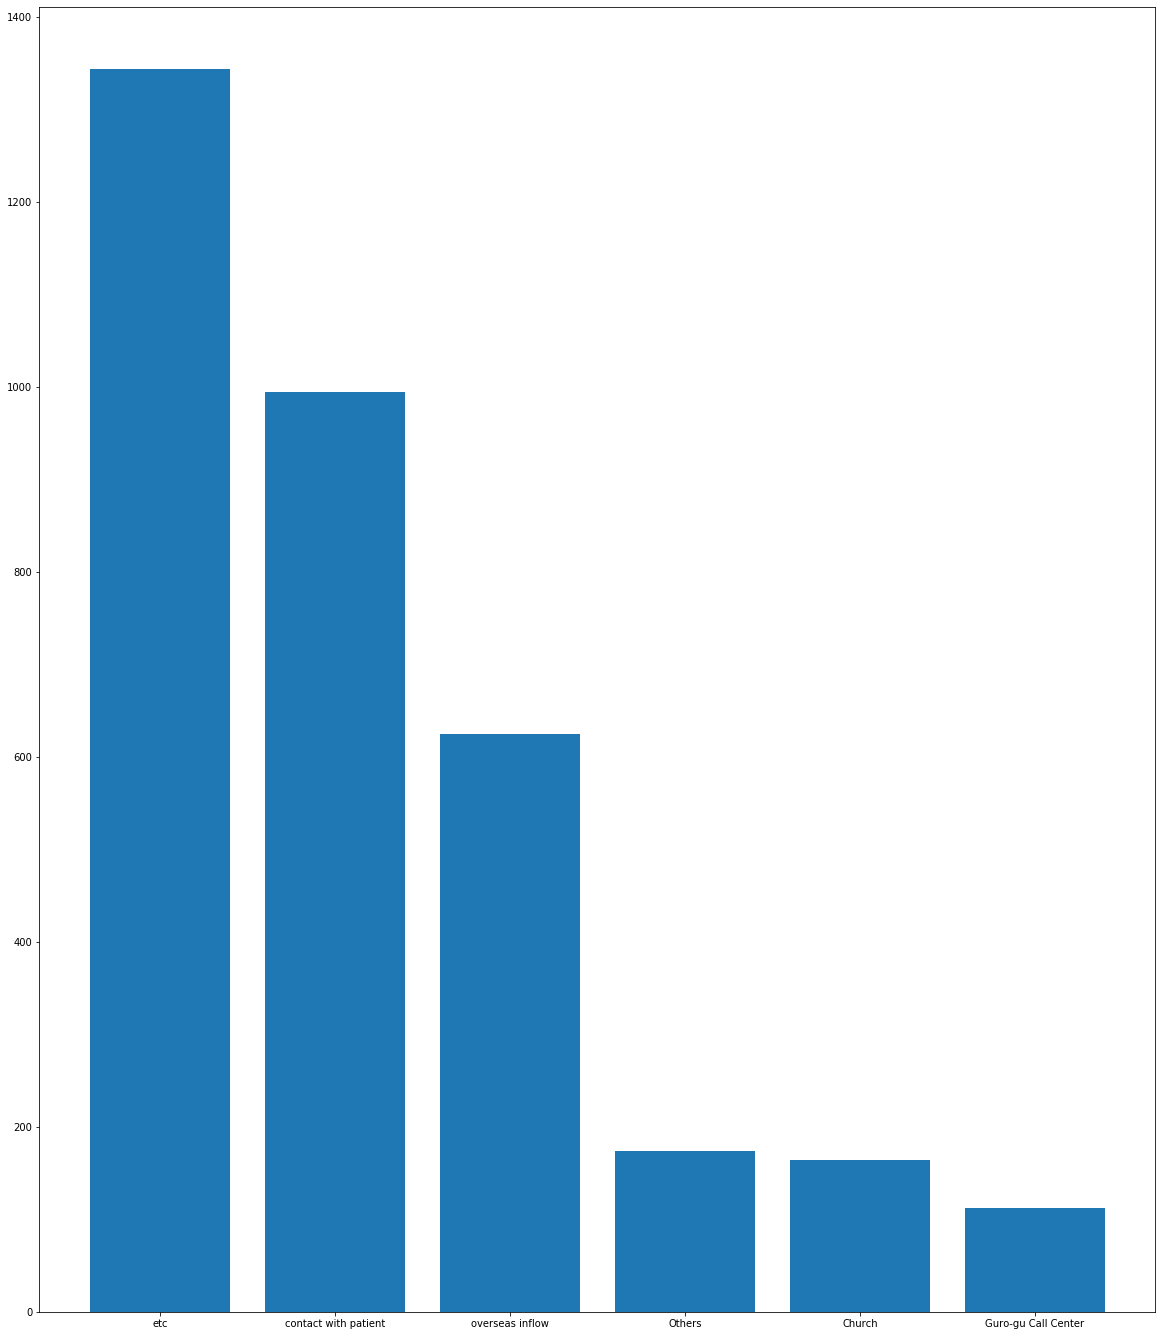

In [78]:
fig, ax = plt.subplots(figsize=(20,24))
sex_bar = ax.bar(infectcase['infection_case'], infectcase['case'] )

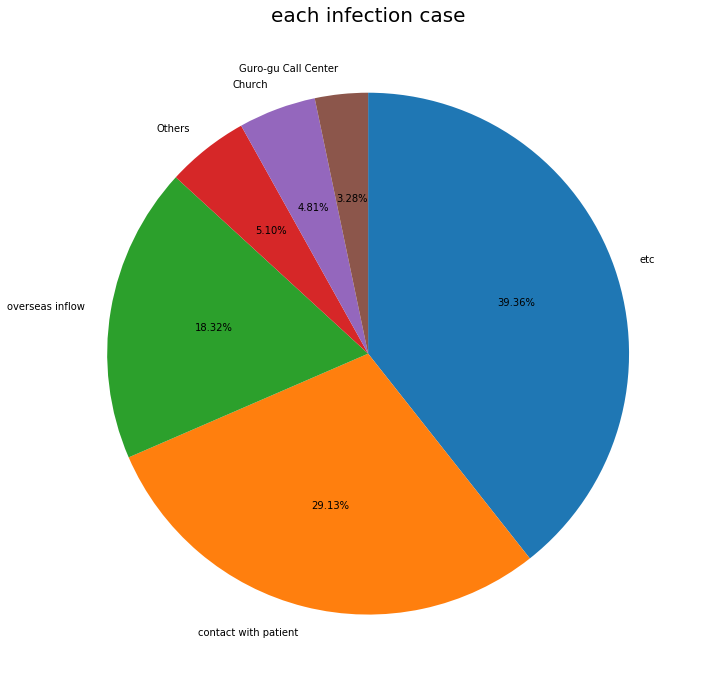

In [79]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.title(f'each infection case', fontsize=20)
plt.pie(infectcase.case
        , labels=infectcase.infection_case
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()

近4成的案例無法追查到確切的感染位置，除了直接接觸患者以及境外移入案例以外，教堂感染人數為最大宗，可知新天地教會群體感染事件影響極大。

### 2-1 性別層面之分析 

### 性別間確診率之比較(統計至2020-05-14)

**分布比例**

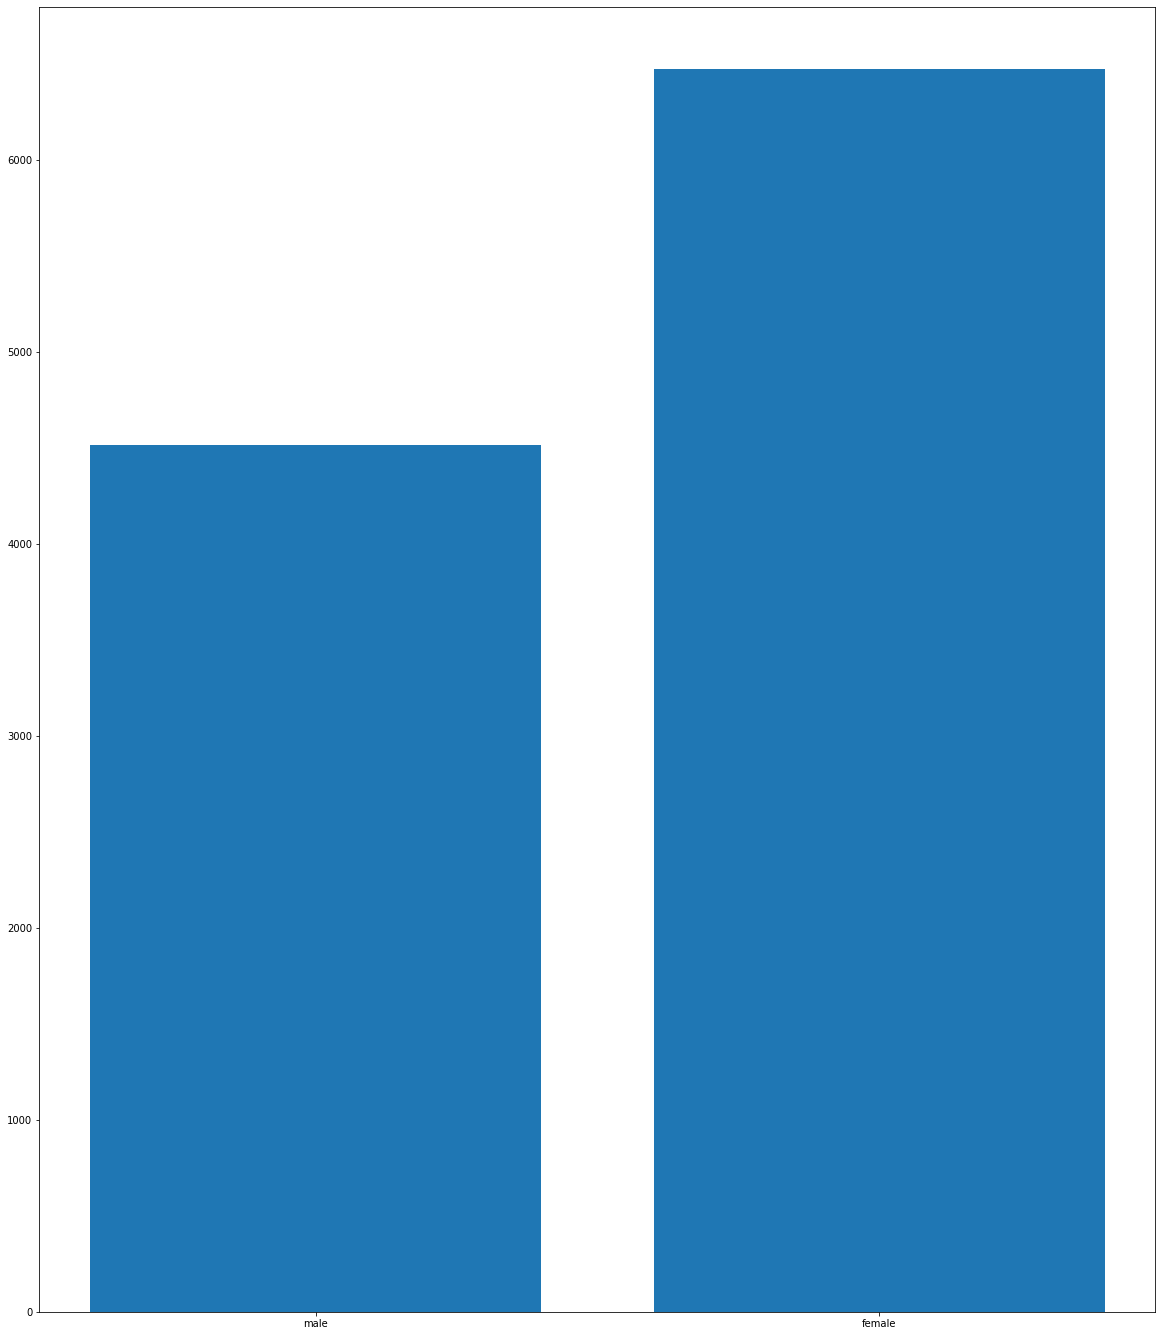

In [80]:
fig, ax = plt.subplots(figsize=(20,24))
sex_bar = ax.bar(gender['sex'], gender['confirmed'])

(-1.1108328494587658,
 1.100515849974227,
 -1.1131282540232492,
 1.122648825558023)

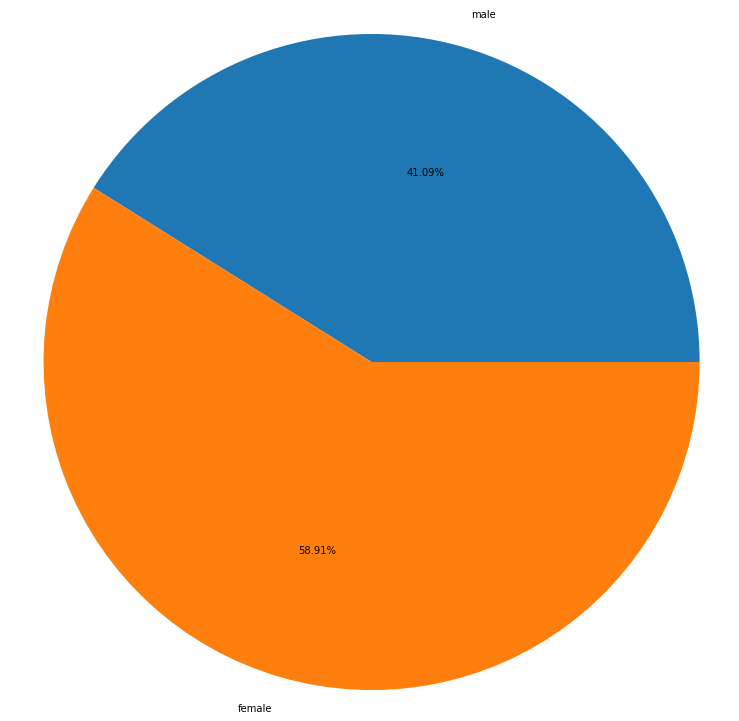

In [81]:
# pie plot
fig, ax = plt.subplots(figsize=(13,13))
order = pd.DataFrame()
order['age'] = gender['sex'].unique()
size = list(gender.loc[gender['date'] == '2020-05-14', 'confirmed'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：女性確診人數較男性高，可能與該地區性別比率影響。(http://www.koreaherald.com/view.php?ud=20191119000682)

**累積變動趨勢**

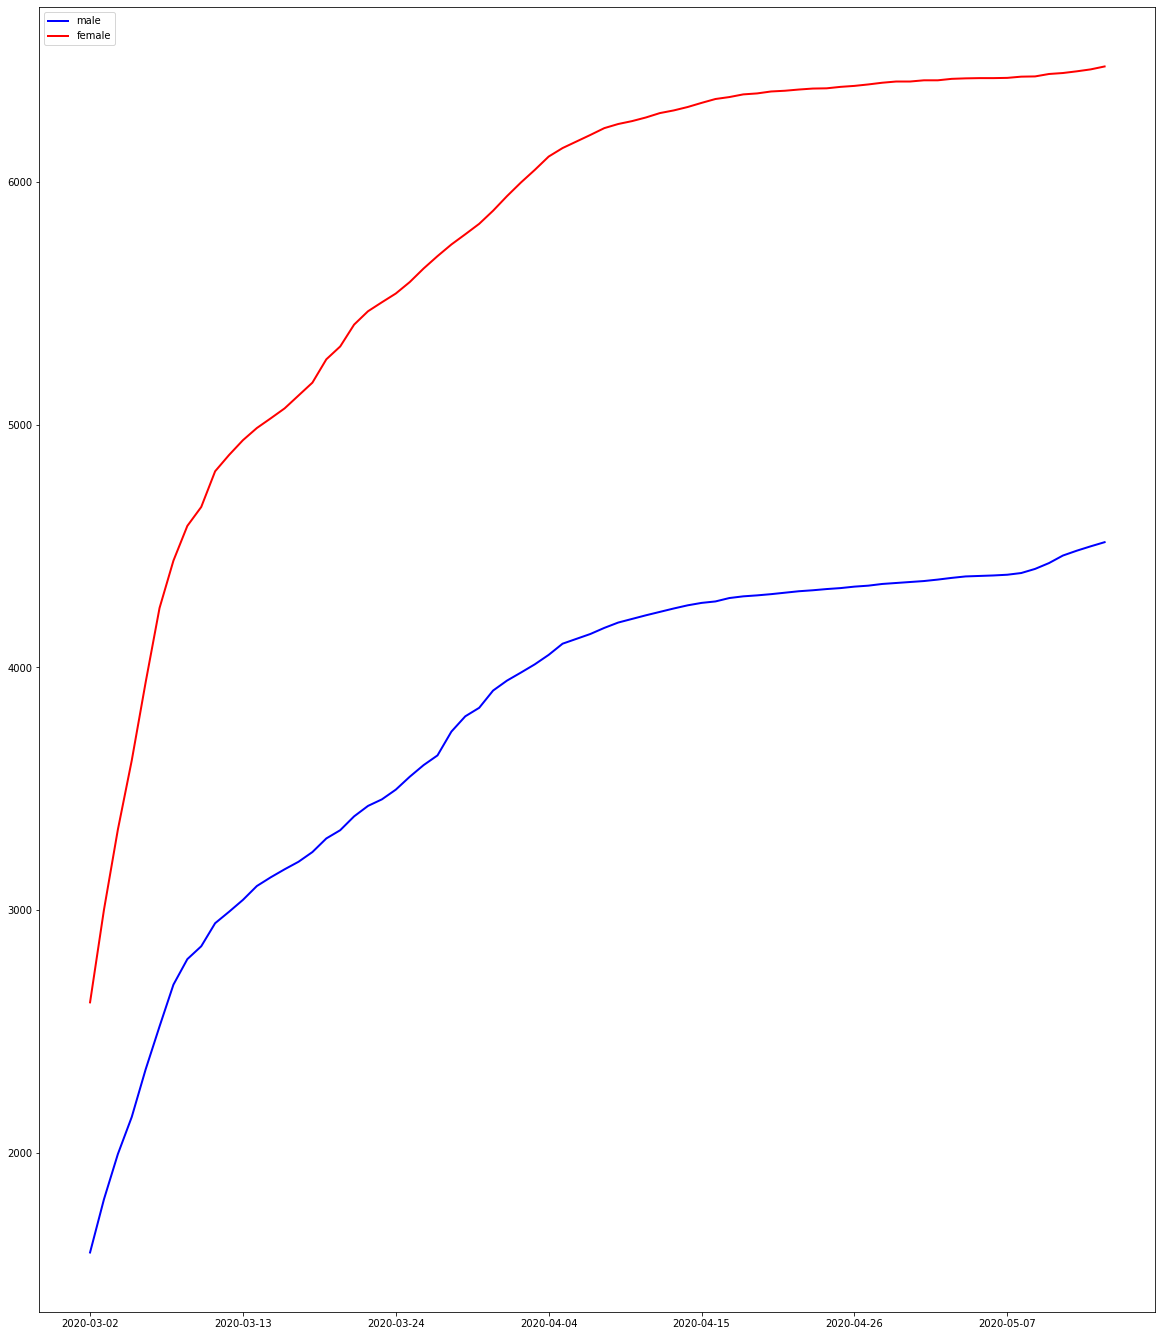

In [82]:
fig, ax = plt.subplots(figsize=(20,24))

# 連續圖
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'male', 'confirmed'], color = 'blue', linewidth = 2, label='male')
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'female', 'confirmed'], color = 'red', linewidth = 2, label='female')
plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks()[::11])

分析結果：女病患始終比男病患還多，而從末端的趨勢變化看到疫情穩定後確診數的增加主要來自於男性的貢獻。整體來說女性可能人多所以上升的比較急促，但變化比較平穩。

**每日變動趨勢**

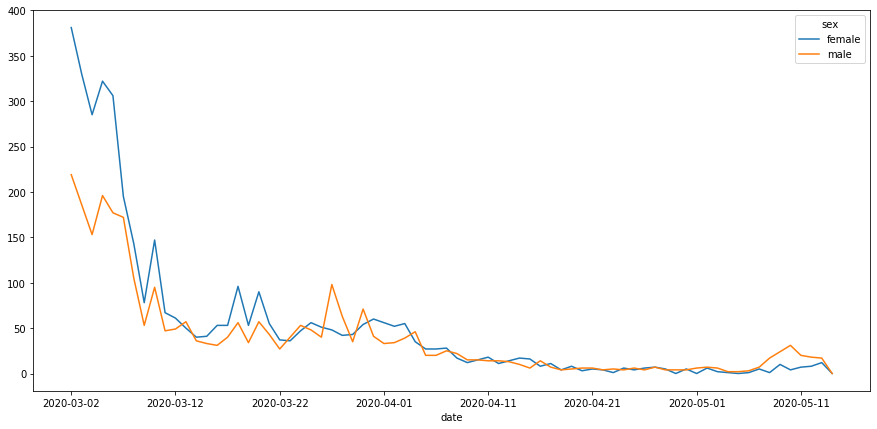

In [83]:

# daily confirmed
for title in gender['sex'].unique():
    day = gender.loc[gender['sex']==title, 'confirmed']
    gender.loc[gender['sex']==title, 'daily_confirmed'] = day.shift(-1) - day

gender.groupby(['date','sex'])['daily_confirmed'].sum() .unstack('sex', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：女性確診率較高，是因為爆發時女性確診數較多。每日病例可以觀察到並非女性較易確診。

### 性別間死亡率之比較(統計至2020-05-14)

**分布比例**

(-1.109608027519042,
 1.1004575251199544,
 -1.1074096077844104,
 1.1145510328176322)

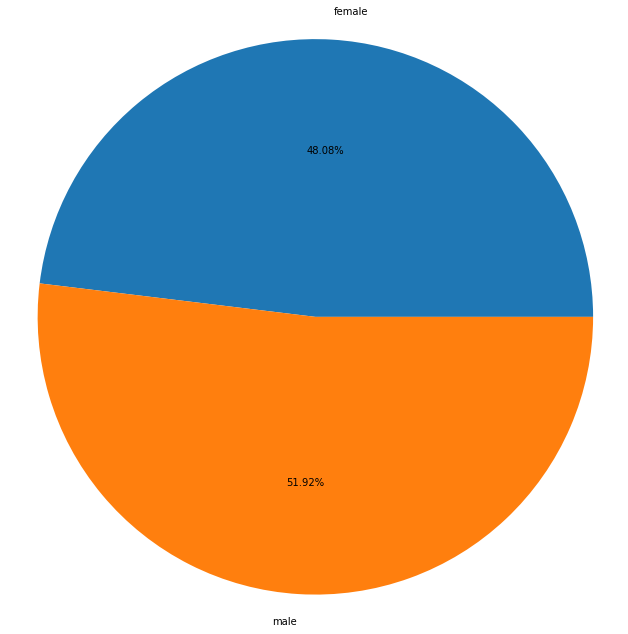

In [84]:
# pie plot
fig, ax = plt.subplots(figsize=(11,11))
order = pd.DataFrame()
order['age'] = gender['sex'].unique()
size = list(gender.loc[gender['date'] == '2020-05-14', 'deceased'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：死亡率2者相差不大，性別與死亡率無關。

**累積變動趨勢**

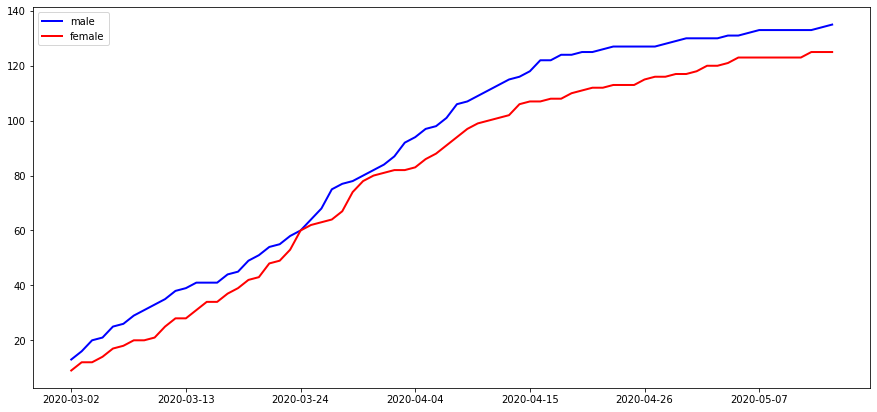

In [85]:
fig, ax = plt.subplots(figsize=(15,7))

# 連續圖
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'male', 'deceased'], color = 'blue', linewidth = 2, label='male')
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'female', 'deceased'], color = 'red', linewidth = 2, label='female')
plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks()[::11])

分析結果：男女累計死亡數，女性較男性高原因可能與女性確診人數較多有關。

**每日變動趨勢**

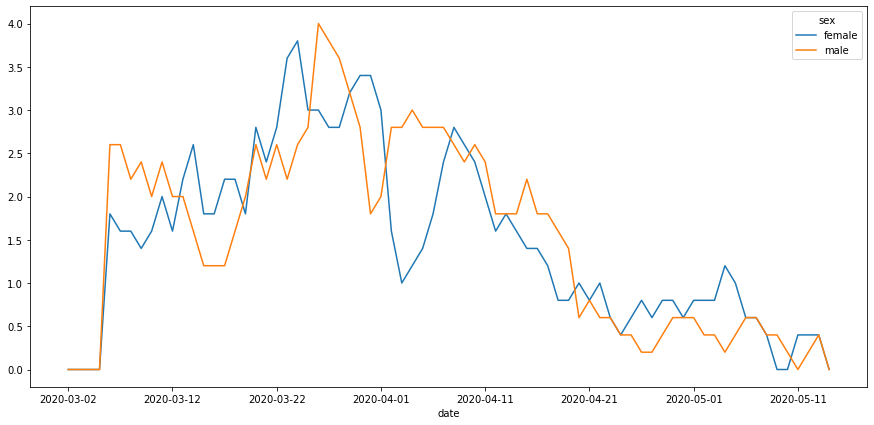

In [86]:
# daily deceased
for title in gender['sex'].unique():
    day = gender.loc[gender['sex']==title, 'deceased']
    gender.loc[gender['sex']==title, 'daily_deceased'] = day.shift(-1) - day
    gender.loc[gender['sex']==title, 'deceased_5sma']=gender.loc[gender['sex']==title, 'daily_deceased'].rolling(5).mean()


gender.groupby(['date','sex'])['deceased_5sma'].sum() .unstack('sex', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：男女齊高或一高一低的情況都有，難以看出規律性。只有再次顯示出末段男性病患普遍比較多，因此也較容易死亡的特性。

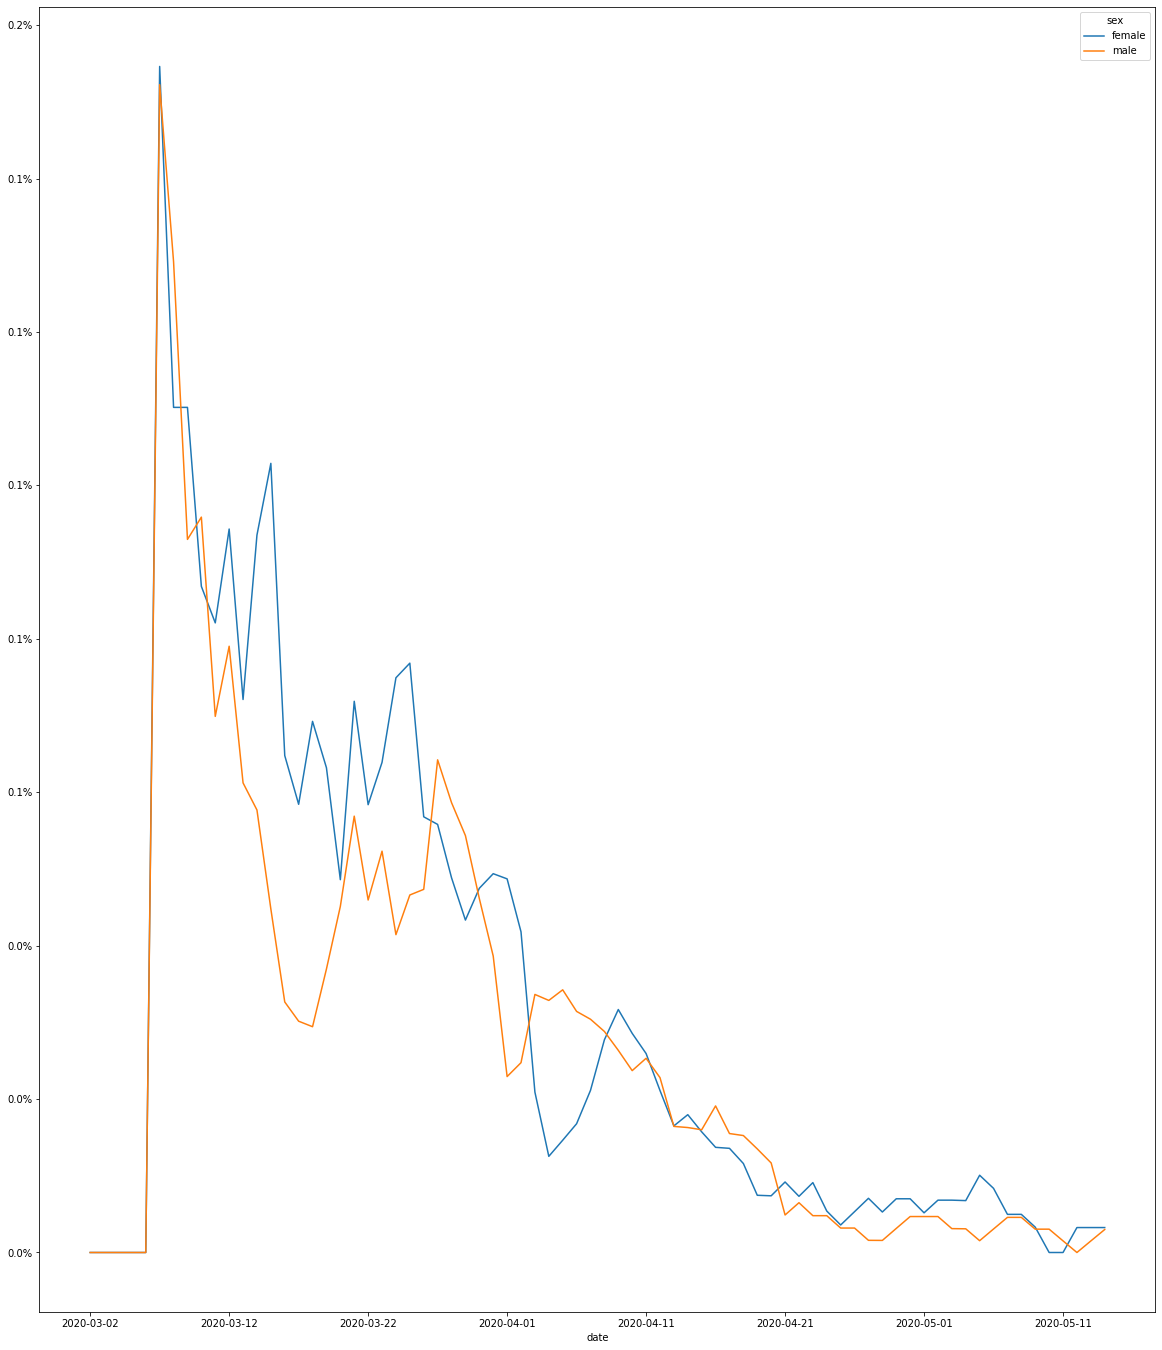

In [87]:
# deceased growth rate (logistic function)
for title in gender['sex'].unique():
    gender.loc[gender['sex']==title, 'deceased_GrowthRate']=gender.loc[gender['sex']==title, 'deceased'].pct_change()
    gender.loc[gender['sex']==title, 'deceased_GrowthRate_sma']=gender.loc[gender['sex']==title, 'deceased_GrowthRate'].rolling(5).mean()


gender.groupby(['date','sex'])['deceased_GrowthRate_sma'].sum() .unstack('sex', fill_value=0).plot(legend=True, figsize=(20,24))
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

ax.set_xticks(ax.get_xticks()[::11])

分析結果：deceased_GrowthRate，男女同時爆發增長。

### Mortality Rate(死亡率)

      sex  mortality_rate
0    male        2.989371
1  female        1.930502


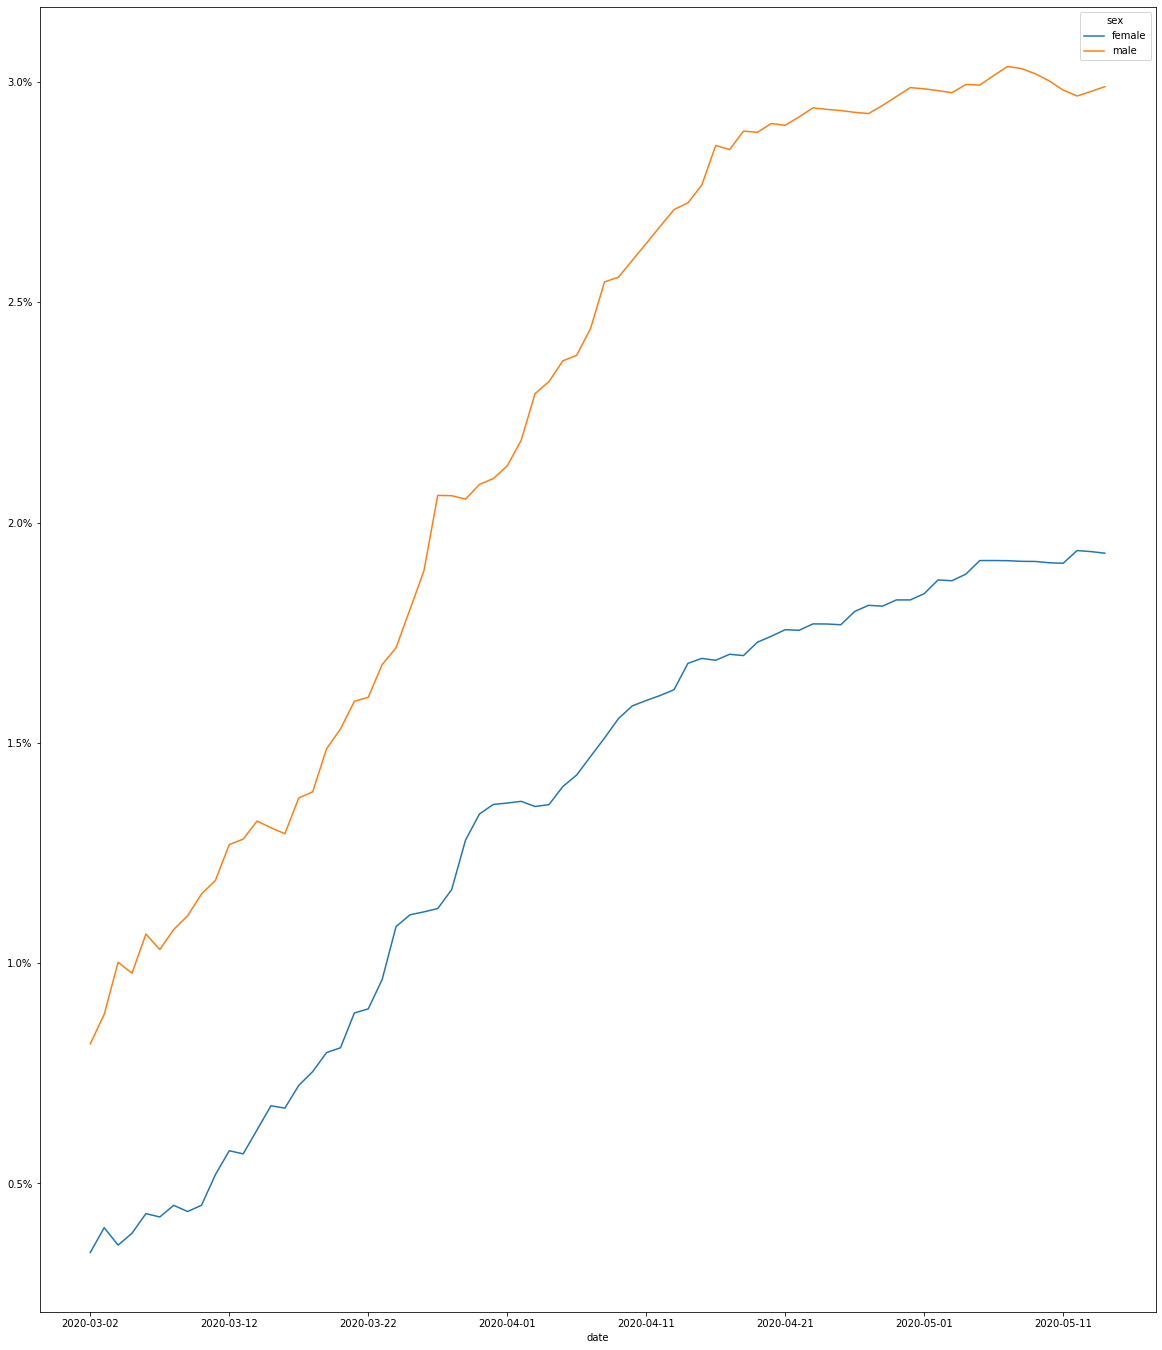

In [88]:
gender['mortality_rate'] = gender['deceased']/gender['confirmed'] * 100
gender.groupby(['date','sex'])['mortality_rate'].sum() .unstack('sex', fill_value=0).plot(legend=True, figsize=(20,24))
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

order = pd.DataFrame()
order['sex'] = gender['sex'].unique()
size = list(gender.loc[gender['date'] == '2020-05-14', 'mortality_rate'])
order['mortality_rate'] = size
order = order.sort_values(by=['mortality_rate'],ascending=False)
print(order)

分析結果：表為約2個月間的每100人死亡數，男性死亡率明顯高於女性，只從時間序列上無法觀察原因，可能推測是男性染病群整體年齡較大。
圖為每日(累計死亡數/累計確診數)比率，即每日男女每百人死亡數。

## 2-2 年齡層面之分析 

### 不同年齡層確診率之比較(統計至2020-05-14)

**分布比例**

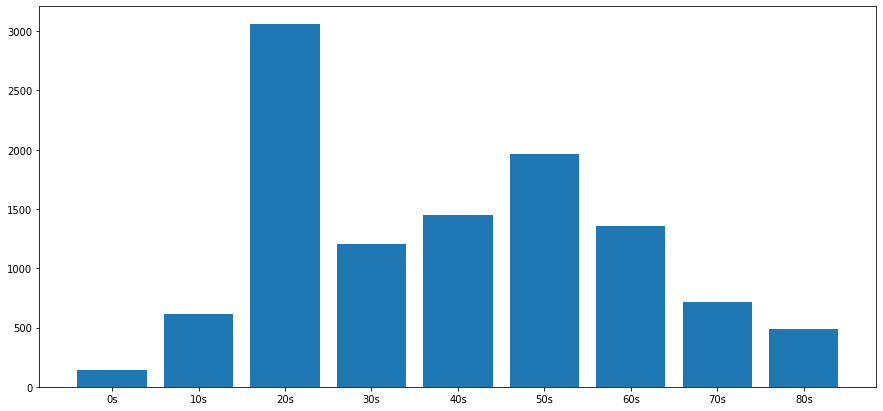

In [89]:
fig, ax = plt.subplots(figsize=(15,7))
bar = ax.bar(age['age'], age['confirmed'])

(-1.1100441190143997,
 1.100478296757703,
 -1.1109708543184509,
 1.1073780548094794)

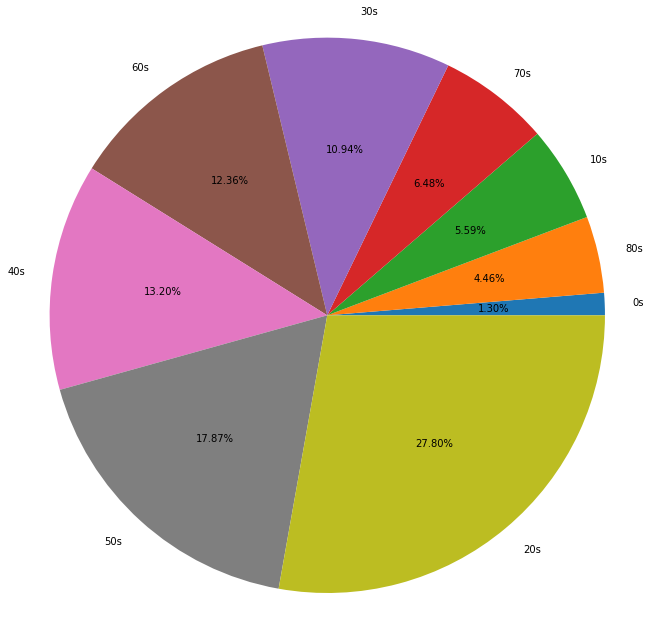

In [90]:
# pie plot
fig, ax = plt.subplots(figsize=(11,11))
order = pd.DataFrame()
order['age'] = age['age'].unique()
size = list(age.loc[age['date'] == '2020-05-14', 'confirmed'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：老人意外的並不是確診數最多的族群，儘管他們被認為免疫力比較差。而在20歲到30歲的年輕人發現更多的病原體。可能是因為年輕人比起老人，比較常到外面四處遊走，因些在這個疾病的高傳染力下有比較多的確診族群。也可能與生活習慣息息相關。

**累積變動趨勢**

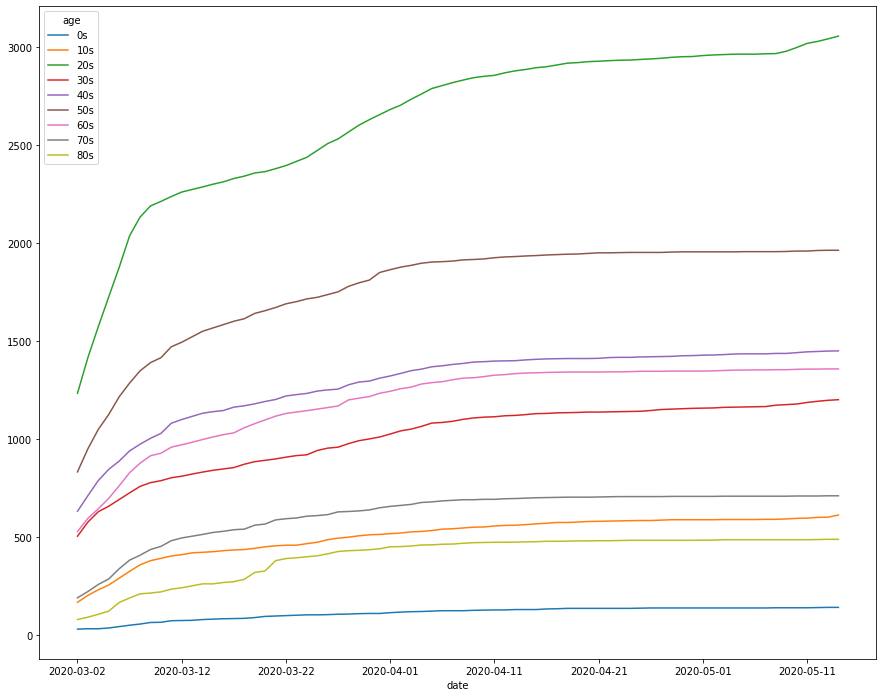

In [91]:
# 連續圖
# plot with each age
age.groupby(['date','age'])['confirmed'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,12))

分析結果：老年人或是年紀比較小的兒童的趨勢比較平緩，可能與相對確診數較少有關。我們可以看出確診出越多變化也越激烈的傾向。

**每日變動趨勢**

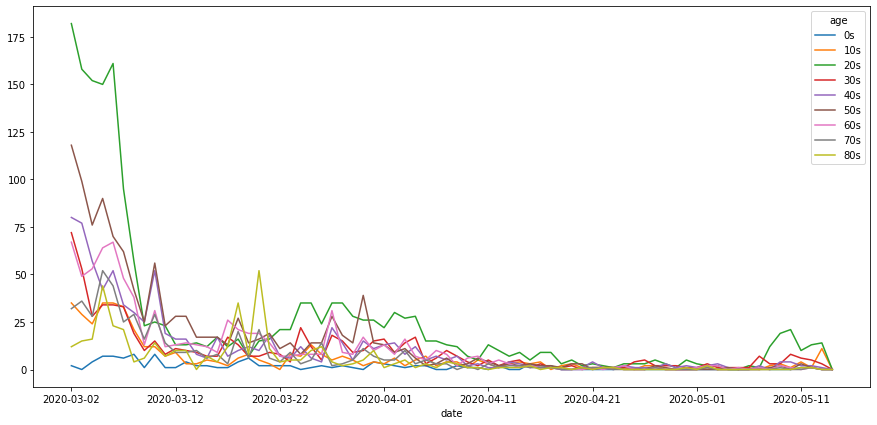

In [92]:
# daily confirmed
for title in age['age'].unique():
    day = age.loc[age['age']==title, 'confirmed']
    age.loc[age['age']==title, 'daily_confirmed'] = day.shift(-1) - day

age.groupby(['date','age'])['daily_confirmed'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：幾乎都是20s族群爆發，可能年輕人活動範圍較廣泛。

**增長速率**

[]

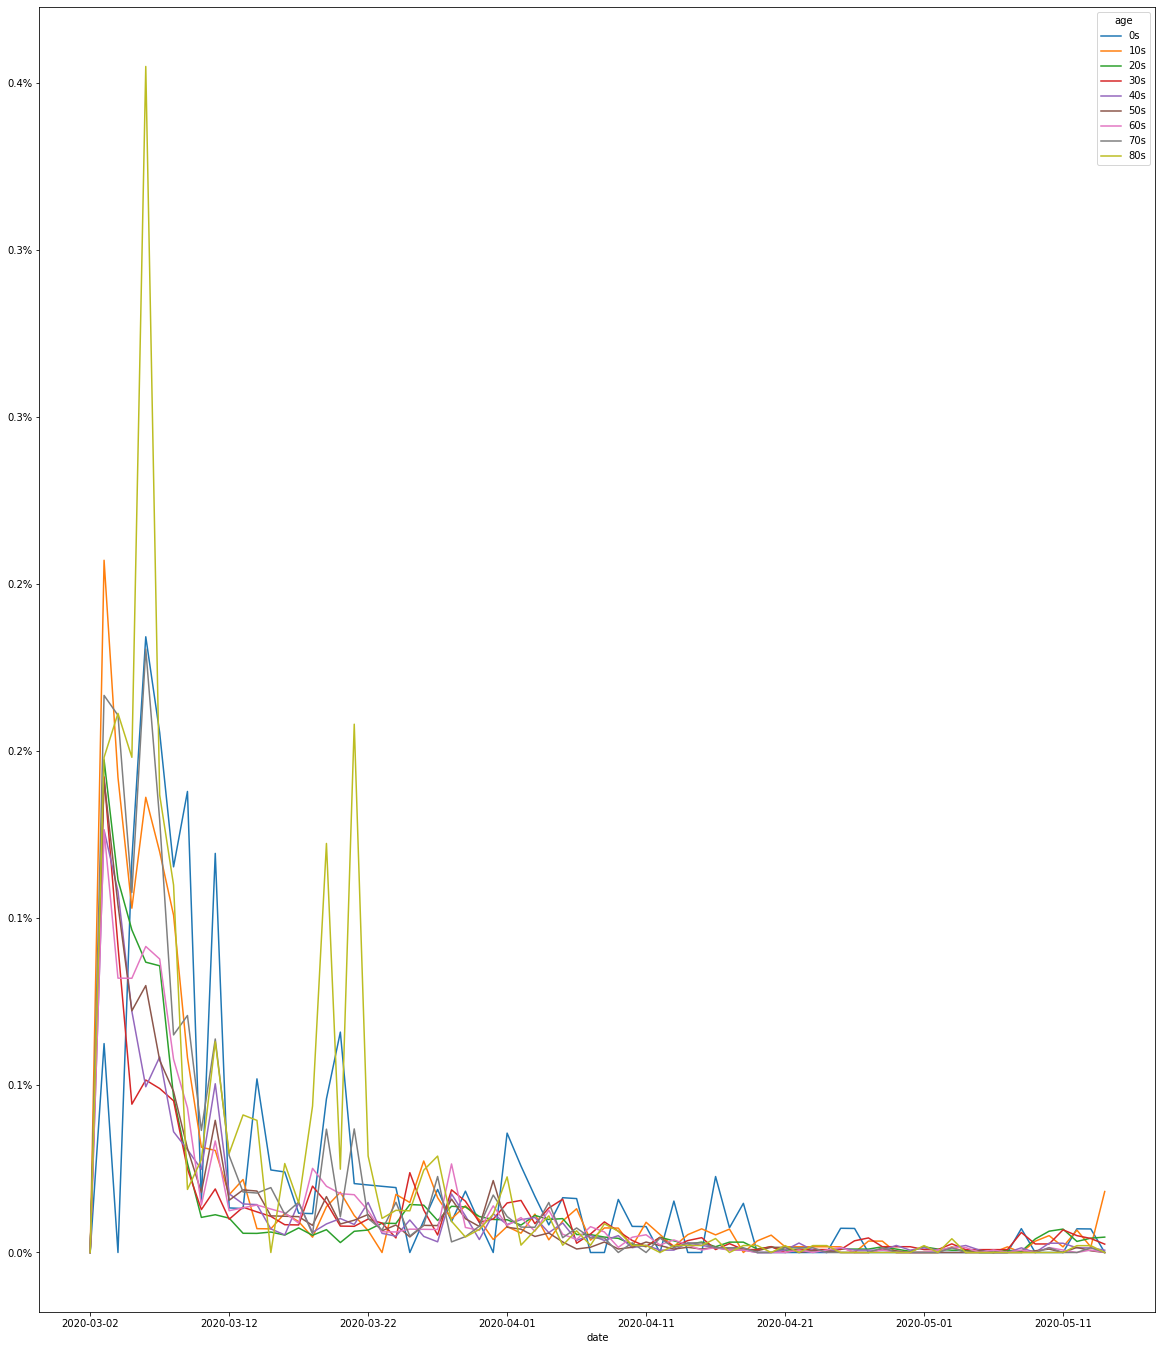

In [93]:
# confirmed growth rate
for title in age['age'].unique():
    age.loc[age['age']==title, 'confirmed_GrowthRate']=age.loc[age['age']==title, 'confirmed'].pct_change()

age.groupby(['date','age'])['confirmed_GrowthRate'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(20,24))
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

ax.set_xticks(ax.get_xticks()[::11])

分析結果：成長速率來象徵疫情的衰退程度。

### 不同年齡層死亡率之比較(統計至2020-05-14)

**分布比例**

(-1.1120580421091375,
 1.1005741924813874,
 -1.1148279318513958,
 1.1132247495111545)

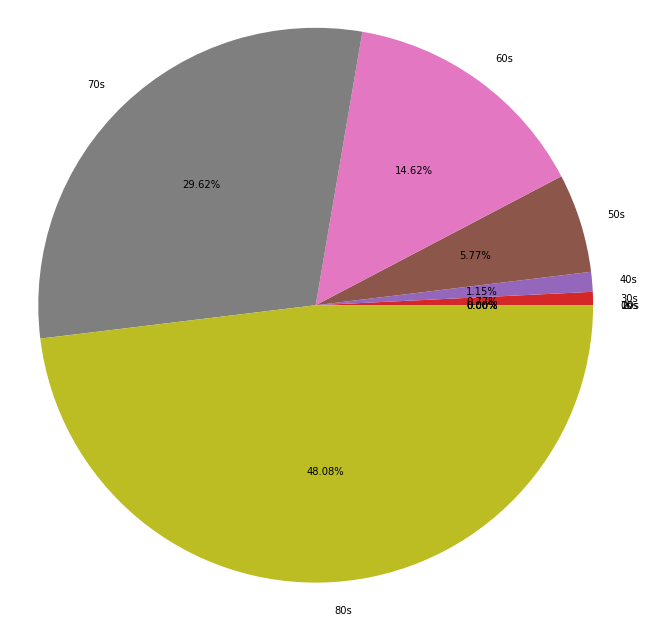

In [94]:
# pie plot
fig, ax = plt.subplots(figsize=(11,11))
order = pd.DataFrame()
order['age'] = age['age'].unique()
size = list(age.loc[age['date'] == '2020-05-14', 'deceased'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：老年人就佔了死亡人口的百分之七十，而年輕人確診數雖多，卻因為免疫力強的關係死亡率較低。綜合二者可推斷新冠肺炎是一種有高傳染力且對免疫力不好的人有嚴重威脅的疾病。

**累積變動趨勢**

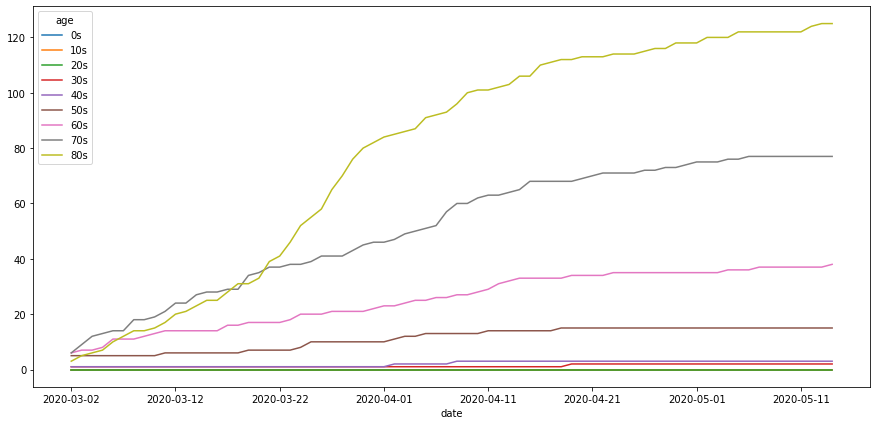

In [95]:
# 連續圖
# plot with each age
age.groupby(['date','age'])['deceased'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：年紀越大死亡率越高。

**每日變動趨勢**

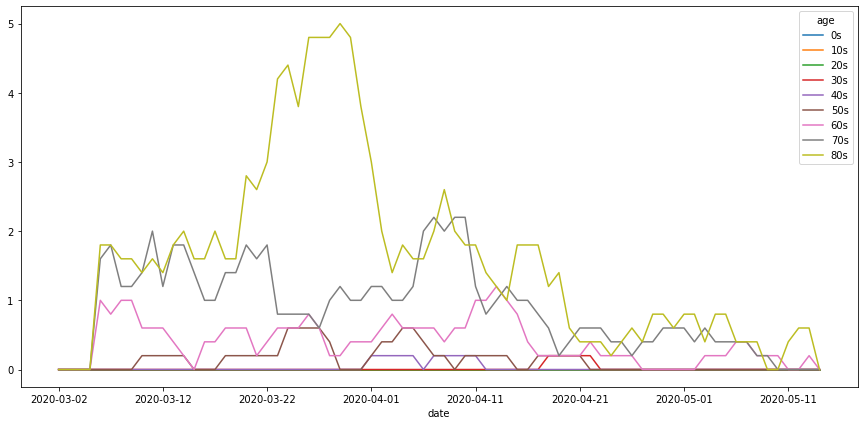

In [96]:
# daily deceased
for title in age['age'].unique():
    day = age.loc[age['age']==title, 'deceased']
    age.loc[age['age']==title, 'daily_deceased'] = day.shift(-1) - day
    age.loc[age['age']==title, 'daily_deceased']=age.loc[age['age']==title, 'daily_deceased'].rolling(5).mean()


age.groupby(['date','age'])['daily_deceased'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：3月22號到4月1號這段期間80歲左右的老人死亡數非常明顯的高於其它。而在前面的確診的圖的前幾天也可以發現其來到了峰值。這會是一個值得標註的事件。

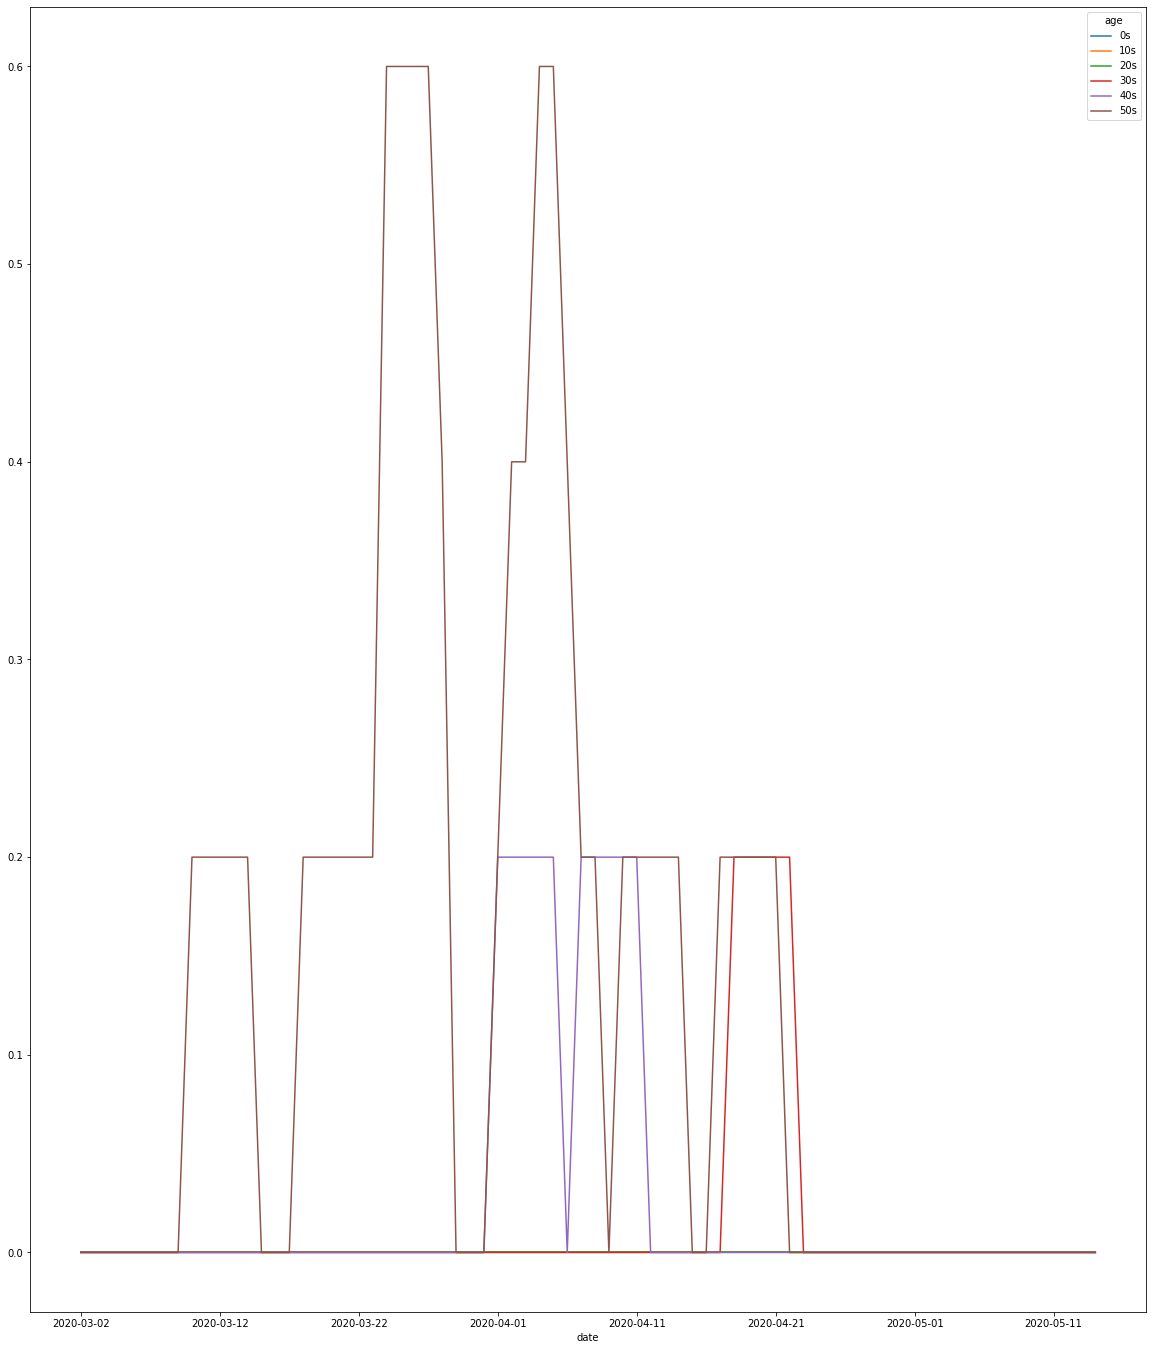

In [97]:
young = age[(age['age']!='80s') & (age['age']!='70s') & (age['age']!='60s')]
young.groupby(['date','age'])['daily_deceased'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(20,24))

分析結果：年輕族群daily deceased取5天的moving_average。年紀超過30之後開始有死亡病例。

### Mortality Rate(死亡率)

   age  mortality_rate
8  80s       25.510204
7  70s       10.814607
6  60s        2.796174
5  50s        0.763747
4  40s        0.206754
3  30s        0.166389
0   0s        0.000000
1  10s        0.000000
2  20s        0.000000


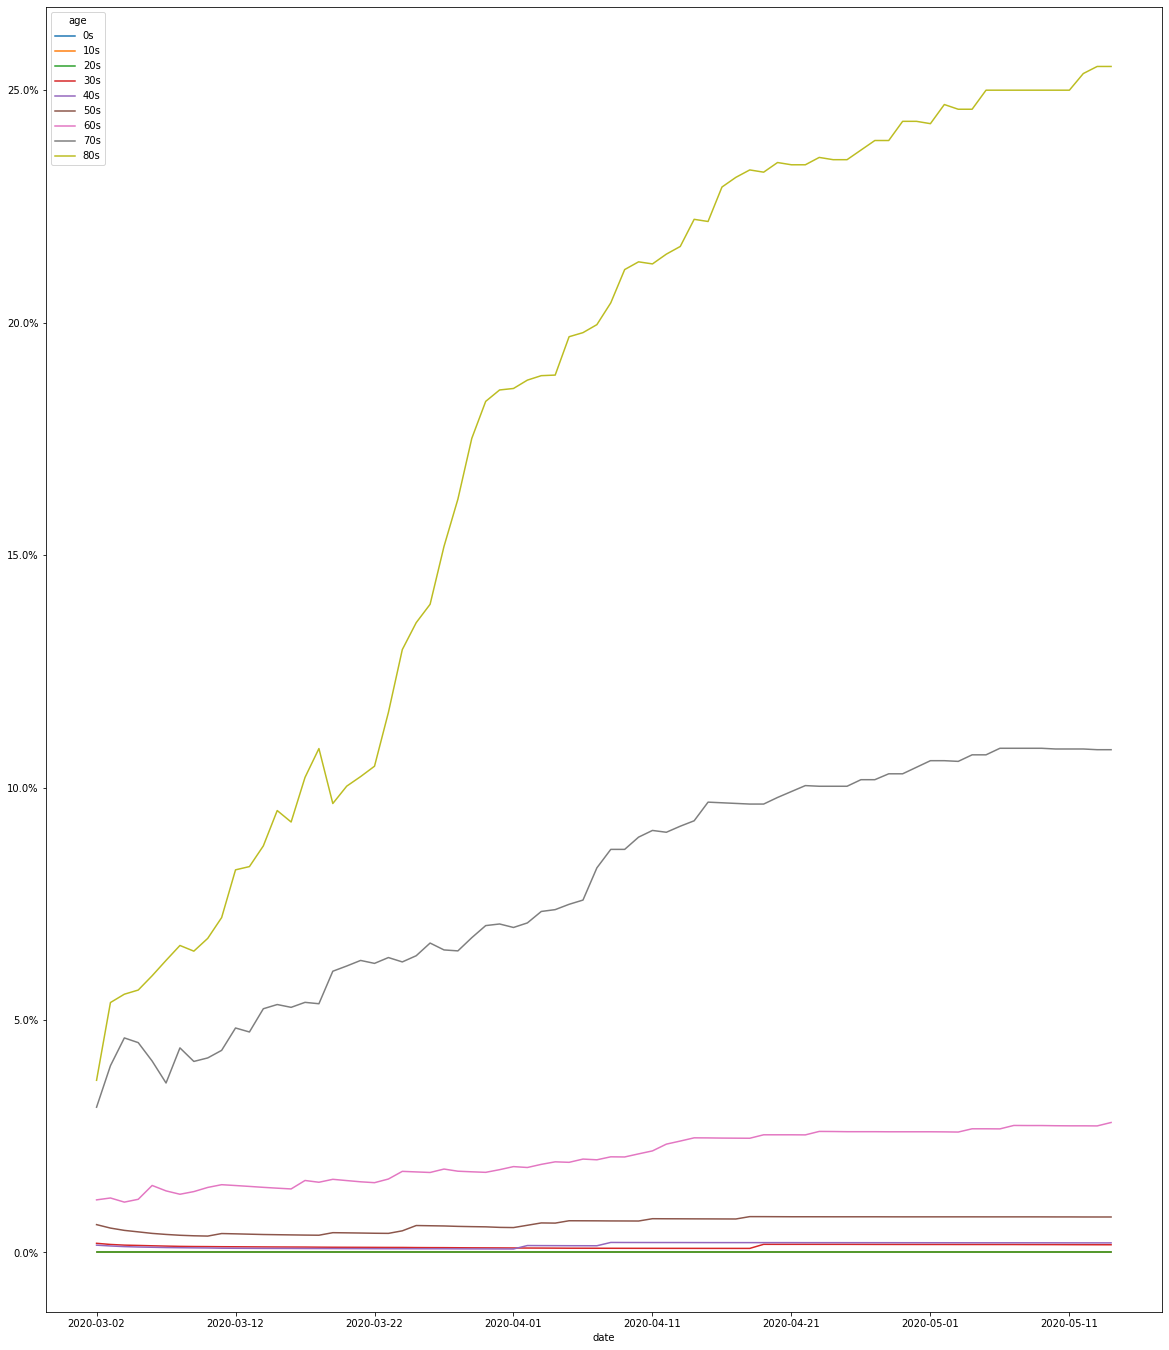

In [98]:
age['mortality_rate'] = age['deceased']/age['confirmed'] * 100
age.groupby(['date','age'])['mortality_rate'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(20,24))
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 

order = pd.DataFrame()
order['age'] = age['age'].unique()
size = list(age.loc[age['date'] == '2020-05-14', 'mortality_rate'])
order['mortality_rate'] = size
order = order.sort_values(by=['mortality_rate'],ascending=False)
print(order)

分析結果：表為約2個月間的每100人死亡數，可以看出年齡越大越易死亡，年輕族群甚至沒人在染病期間死亡。
圖為每日(累計死亡數/累計確診數)*100*，即每日各年齡層每百人死亡數。

### 2-3 浮動人口分析（以首爾為例）

In [99]:
df_float = pd.read_csv(datasets[9])
display(df_float.head(5).append(df_float.tail(5)))

date  hour  birth_year     sex province           city  fp_num
0       2020-01-01     0          20  female    Seoul      Dobong-gu   19140
1       2020-01-01     0          20    male    Seoul      Dobong-gu   19950
2       2020-01-01     0          20  female    Seoul  Dongdaemun-gu   25450
3       2020-01-01     0          20    male    Seoul  Dongdaemun-gu   27050
4       2020-01-01     0          20  female    Seoul     Dongjag-gu   28880
863995  2020-04-30    22          40  female    Seoul   Seongdong-gu   22150
863996  2020-04-30    22          50  female    Seoul   Seodaemun-gu   23270
863997  2020-04-30    23          20  female    Seoul     Yongsan-gu   18570
863998  2020-04-30    23          30  female    Seoul   Seodaemun-gu   21100
863999  2020-04-30    23          40    male    Seoul     Gangnam-gu   45730

### 基本調查與修正

**每日變動趨勢**

In [100]:
span_table = df_float.groupby(['date', 'hour']).sum()
display(span_table.head(5).append(span_table.tail(5))[['fp_num']])
date_average = span_table.groupby(['date']).mean()
date_average['fp_num'] = date_average['fp_num'].apply(lambda x: x / 1000000)
display(date_average.head(5).append(date_average.tail(5))[['fp_num']])


fp_num
date       hour         
2020-01-01 0     8131460
           1     8068010
           2     8030150
           3     7997210
           4     7969800
2020-04-30 19    7727190
           20    7758760
           21    7770910
           22    7756420
           23    7731390

fp_num
date                
2020-01-01  8.016924
2020-01-02  8.455390
2020-01-03  8.472381
2020-01-04  8.224835
2020-01-05  8.156153
2020-04-26  7.881628
2020-04-27  8.299862
2020-04-28  8.295024
2020-04-29  8.270830
2020-04-30  7.777873

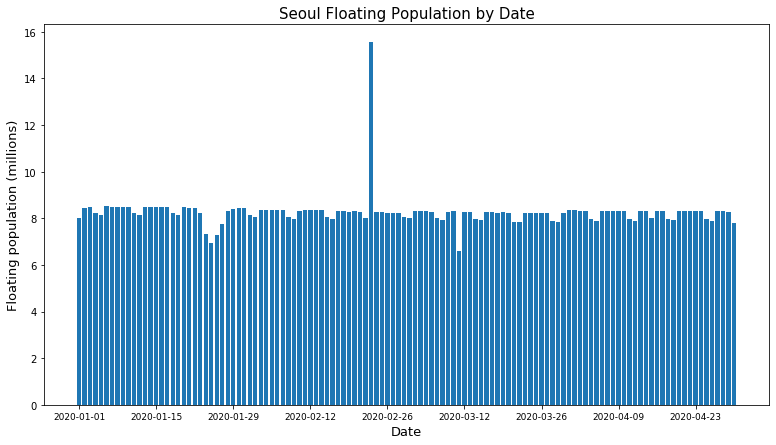

In [101]:


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Seoul Floating Population by Date', size=15)
plt.bar(df_float.date.unique()
       , date_average.fp_num.values)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

分析結果：從上面的柱狀圖我們可以觀察到首爾每日浮動人口波動的情形，並以兩週作為刻度。大約是一月二十七日的左右有一個下陷，可以解釋成韓國也有春節的活動，返鄉潮的關係讓非永久住民減少。其它的時段大致上都還算平穩，唯有約莫在二月二十幾號的時候出現了明顯不合理的異常值。若不是有什麼重大事件發生那就是資料有誤。下面將針對這點進行分析，並決定是要探索出意義或是試著將其修正。

**觀察異常值**

In [102]:
outlier = date_average[date_average['fp_num'] >= 12]
display(outlier)
print(f'異常日期：{outlier.index[0]}')

birth_year     fp_num
date                             
2020-02-23     13500.0  15.545315

異常日期：2020-02-23


birth_year    fp_num
hour                      
0         0.0135  15.86466
1         0.0135  15.83910
2         0.0135  15.80694
3         0.0135  15.76398
4         0.0135  15.72644
5         0.0135  15.69123
6         0.0135  15.65973
7         0.0135  15.66723
8         0.0135  15.73829
9         0.0135  15.79387
10        0.0135  15.84508
11        0.0135   7.92956
12        0.0135  15.79231
13        0.0135  15.83723
14        0.0135  15.86082
15        0.0135  15.89933
16        0.0135  15.95621
17        0.0135  16.01330
18        0.0135  16.06073
19        0.0135  16.08761
20        0.0135  16.09614
21        0.0135  16.08371
22        0.0135  16.05435
23        0.0135  16.01970

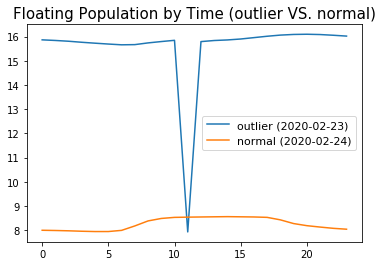

In [103]:
error_table = span_table.loc['2020-02-23'] / 1000000
display(error_table)

plt.title('Floating Population by Time (outlier VS. normal)', size=15)
outlier = error_table.fp_num
                                                    
normal_table = span_table.loc['2020-02-24'] / 1000000
normal = normal_table.fp_num

plt.plot(outlier)
plt.plot(normal)
ax.set_xlabel('Hour of day', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.legend(['outlier (2020-02-23)', 'normal (2020-02-24)'], fontsize=11, loc='center right')
plt.show()

分析結果：查出發生異常的日期是2月23日後，我們觀察他與隔一天每小時浮動人口的變化，結果發現2月23日唯一與其它不同的量值與看起來比較正常的翌日相差無幾。再透過上面的表格，我們可以大膽的假設除了11點是正確的，其它值都被錯誤的放大了兩倍。必須進行修正，否則其它的分析將受到干擾。

**異常值修正**

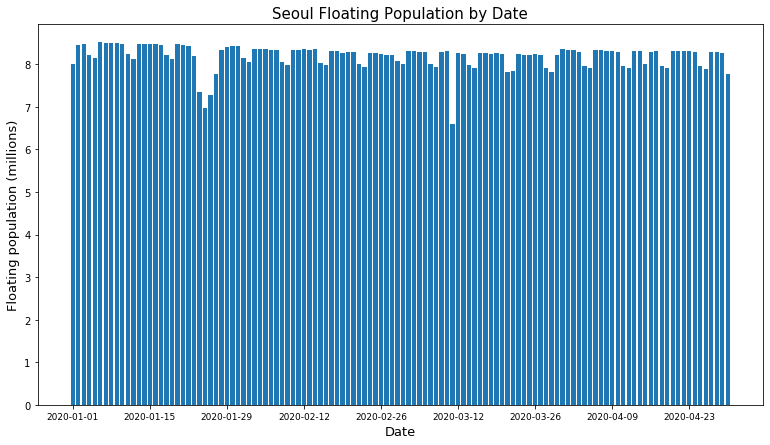

In [104]:
df_float.loc[(df_float.date=='2020-02-23') & (df_float.hour!=11), 'fp_num' ] /= 2
span_table = df_float.groupby(['date', 'hour']).sum()
date_average = span_table.groupby(['date']).mean()
date_average['fp_num'] = date_average['fp_num'].apply(lambda x: x / 1000000)

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Seoul Floating Population by Date', size=15)
plt.bar(df_float.date.unique()
       , date_average.fp_num.values)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

birth_year    fp_num
hour                      
0         0.0135  7.932330
1         0.0135  7.919550
2         0.0135  7.903470
3         0.0135  7.881990
4         0.0135  7.863220
5         0.0135  7.845615
6         0.0135  7.829865
7         0.0135  7.833615
8         0.0135  7.869145
9         0.0135  7.896935
10        0.0135  7.922540
11        0.0135  7.929560
12        0.0135  7.896155
13        0.0135  7.918615
14        0.0135  7.930410
15        0.0135  7.949665
16        0.0135  7.978105
17        0.0135  8.006650
18        0.0135  8.030365
19        0.0135  8.043805
20        0.0135  8.048070
21        0.0135  8.041855
22        0.0135  8.027175
23        0.0135  8.009850

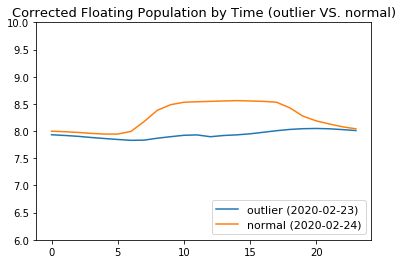

In [105]:
error_table = span_table.loc['2020-02-23'] / 1000000
display(error_table)

plt.title('Corrected Floating Population by Time (outlier VS. normal)', size=13)
outlier = error_table.fp_num
                                                    
normal_table = span_table.loc['2020-02-24'] / 1000000
normal = normal_table.fp_num

plt.plot(outlier)
plt.plot(normal)
ax.set_xlabel('Hour of day', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.ylim(6, 10)
plt.legend(['outlier (2020-02-23)', 'normal (2020-02-24)'], fontsize=11, loc='lower right')
plt.show()

### 浮動人口組成調查與比較

**性別層面**

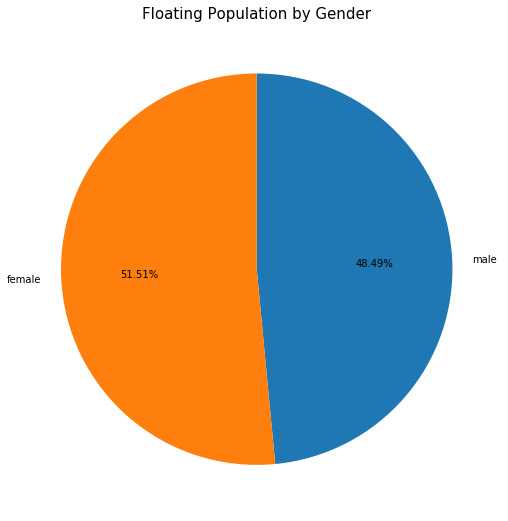

In [106]:
seoul_male = df_float[df_float.sex == 'male']
seoul_female = df_float[df_float.sex == 'female']

fig, ax = plt.subplots(figsize=(9, 9))
plt.title('Floating Population by Gender', size=15)
plt.pie([seoul_male.fp_num.sum()
         , seoul_female.fp_num.sum()]
        , labels=['male', 'female']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()


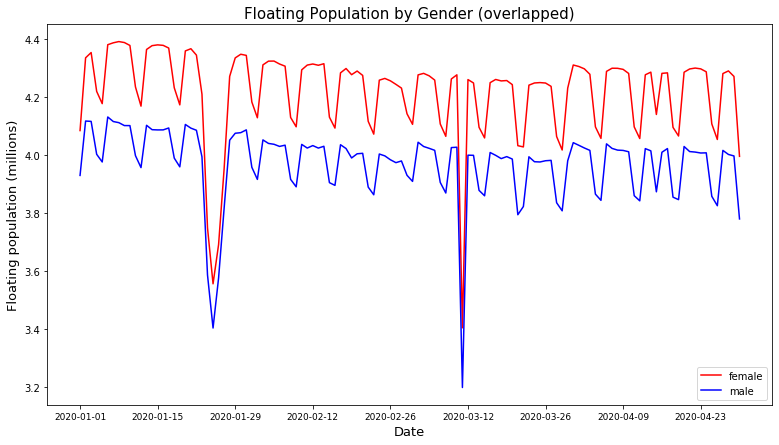

In [107]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Gender (overlapped)', size=15)
colors = [(1,0,0),(0,0,1)]

for sex, i in zip([seoul_female, seoul_male], range(2)):
    sns.lineplot(sex.date.unique() , sex.groupby(['date', 'hour']).sum()\
        .groupby('date').mean().apply(lambda x: x/1000000)\
        .fp_num.values, color=colors[i])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(['female', 'male'], loc='lower right')
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

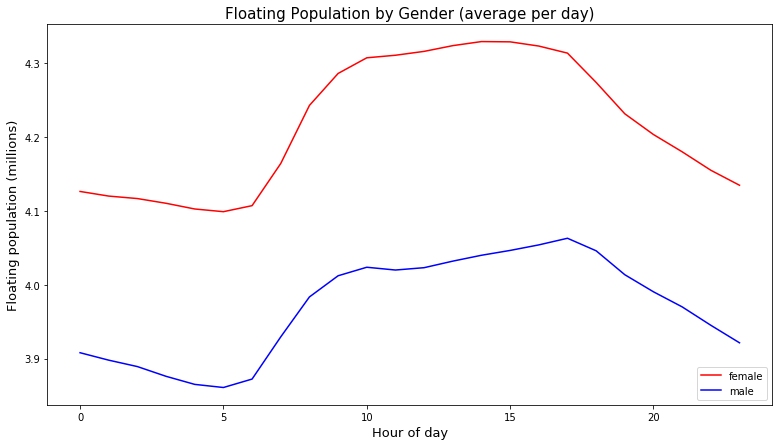

In [108]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Gender (average per day)', size=15)
plt.plot(seoul_female.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=colors[0])
plt.plot(seoul_male.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=colors[1])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(['female', 'male'], loc='lower right')
plt.show()

分析結果：在性別的組成方面顯示出了浮動人口中女性無時無刻的高於男性的這個事實。與整體的分析結果一致。且一天之中的變動趨勢是差不多的（都是在上班時間達到高峰）。

**年齡層面**

hour        fp_num
birth_year                       
30          1656000  4.804668e+09
40          1656000  4.797880e+09
50          1656000  4.495949e+09
20          1656000  4.297191e+09
60          1656000  2.950036e+09
70          1656000  2.233458e+09

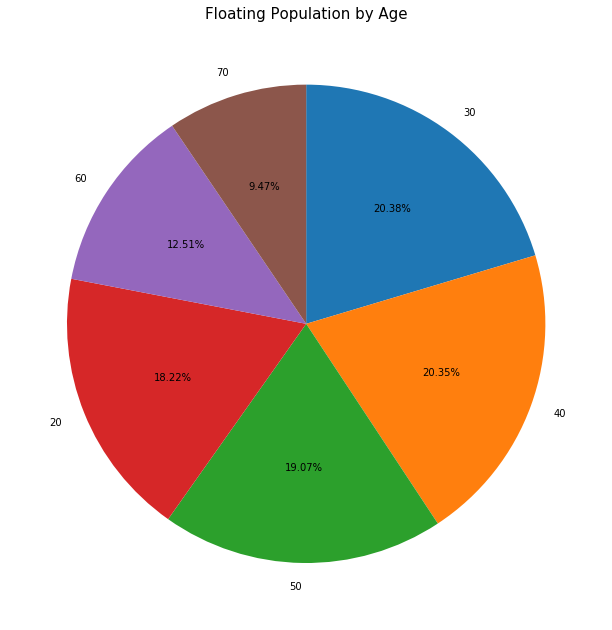

In [109]:
float_age_table = df_float.groupby('birth_year').sum().sort_values(by='fp_num',ascending=False)
float_age_order = list(float_age_table.index)
display(float_age_table)
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Floating Population by Age', size=15)
plt.pie(float_age_table.fp_num.values , labels=float_age_order , autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

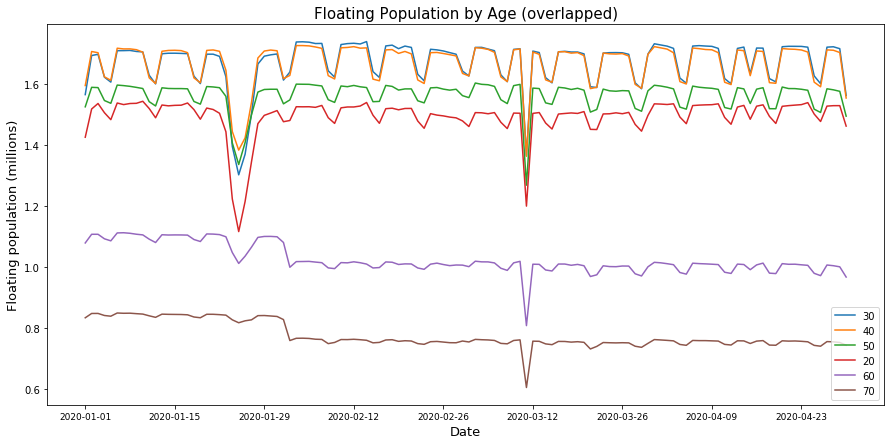

In [110]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Floating Population by Age (overlapped)', size=15)
for age, i in zip(float_age_order, range(len(float_age_order))):
    sns.lineplot(df_float.date.unique()
            , df_float[df_float.birth_year==age].groupby(['date', 'hour']).sum()\
            .groupby('date').mean().apply(lambda x: x/1000000)\
            .fp_num.values)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(float_age_order
           , loc='lower right'
          )
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

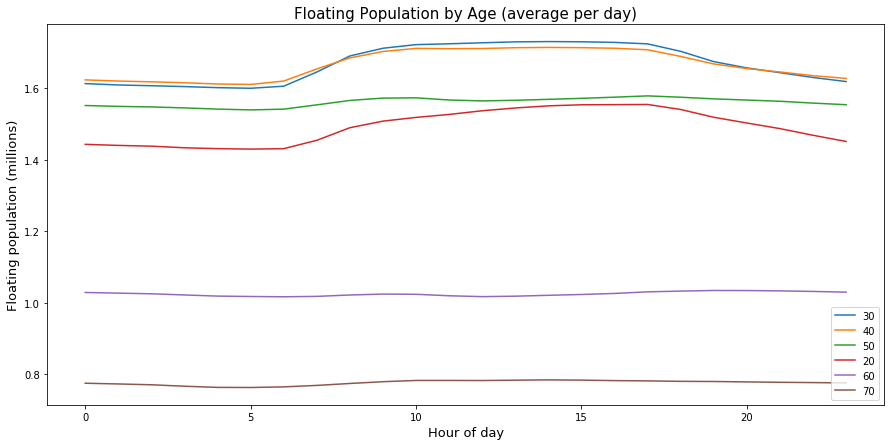

In [111]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Floating Population by Age (average per day)', size=15)

for age, i in zip(float_age_order, range(len(float_age_order))):
    sns.lineplot(df_float.hour.unique()
            , df_float[df_float.birth_year==age].groupby(['date', 'hour']).sum()\
            .groupby('hour').mean().apply(lambda x: x/1000000)\
            .fp_num)

ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(float_age_order, loc='lower right')
plt.show()

分析結果：由年齡組成有關的圖可以斷定首爾浮動人口的年輕人主要的主成份子是工作人口。原因是1/27號左右男女的下降都比較一致，而這一天中老年人(60歲+70歲)的波動幅度卻不如其他年齡的來得大。而一天的變動趨勢中，工作時段的年輕組有微微上揚，而老年組則一天的變化都很穩定。

**子區域層面**

In [112]:
float_area_table = df_float.groupby('city').sum().sort_values('fp_num', ascending=False)
float_area_table['ratio'] = float_area_table.fp_num.apply(lambda x: x / (df_float.fp_num.sum()) * 100)
display(float_area_table)
float_area_order = list(float_area_table.index)


hour  birth_year        fp_num     ratio
city                                                       
Gangnam-gu       397440     1555200  1.684455e+09  7.143822
Songpa-gu        397440     1555200  1.489581e+09  6.317355
Gangseo-gu       397440     1555200  1.268894e+09  5.381415
Seocho-gu        397440     1555200  1.177264e+09  4.992813
Nowon-gu         397440     1555200  1.139016e+09  4.830599
Gwanak-gu        397440     1555200  1.131892e+09  4.800385
Yeongdeungpo-gu  397440     1555200  1.130382e+09  4.793982
Guro-gu          397440     1555200  1.017553e+09  4.315471
Mapo-gu          397440     1555200  9.744652e+08  4.132735
Seongbuk-gu      397440     1555200  9.665831e+08  4.099307
Eunpyeong-gu     397440     1555200  9.628389e+08  4.083428
Gangdong-gu      397440     1555200  9.567419e+08  4.057570
Yangcheon-gu     397440     1555200  9.406061e+08  3.989138
Dongjag-gu       397440     1555200  8.948368e+08  3.795029
Jungnang-gu      397440     1555200  8.473197e+08  3.593507
Dongdaemun-gu    397440     1555200  8.318321e+08  3.527824
Gwangjin-gu      397440     1555200  8.183157e+08  3.470501
Seongdong-gu     397440     1555200  7.338540e+08  3.112296
Seodaemun-gu     397440     1555200  7.299863e+08  3.095893
Dobong-gu        397440     1555200  6.883253e+08  2.919208
Gangbuk-gu       397440     1555200  6.840740e+08  2.901178
Geumcheon-gu     397440     1555200  6.520085e+08  2.765187
Jung-gu          397440     1555200  6.325111e+08  2.682498
Jongno-gu        397440     1555200  6.157197e+08  2.611285
Yongsan-gu       397440     1555200  6.101287e+08  2.587574

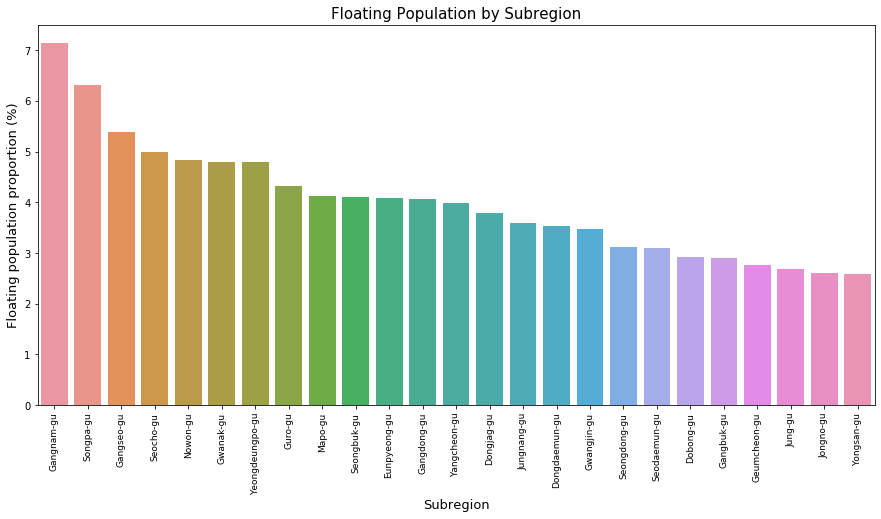

In [113]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Floating Population by Subregion', size=15)
sns.barplot(float_area_order
           , float_area_table['ratio'])
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Floating population proportion (%)', size=13)
plt.xticks(rotation=90, size=9)
plt.show()

分析結果：從這張圖看不出什麼，因此我們引入外部資料，探討各子區域人口以及確診數的關係。截至(4/27日)的各子區域的累績確認數來自於
Seoul COVID-19[http://www.seoul.go.kr/coronaV/coronaStatus.do]

**子區域人口與確診數之關聯性**

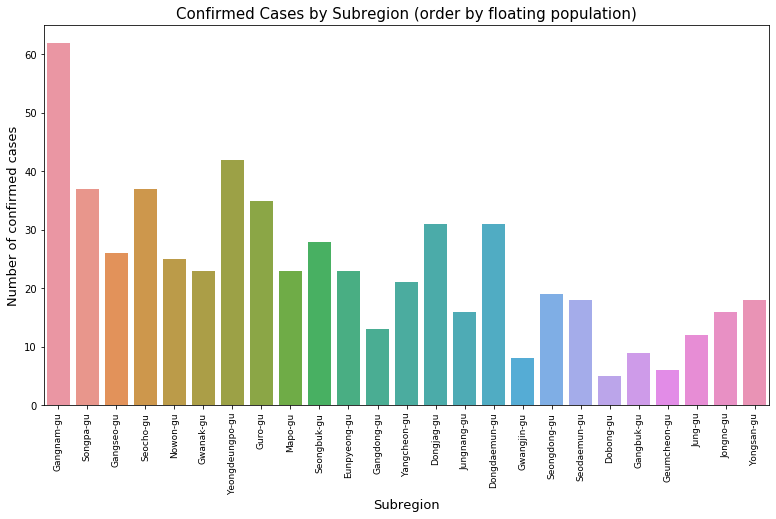

In [114]:
seoul_confirmed = [62, 37, 26, 37, 25
                   , 23, 42, 35, 23, 28
                   , 23, 13, 21, 31, 16
                   , 31, 8, 19, 18, 5
                   , 9, 6, 12, 16, 18]

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases by Subregion (order by floating population)', size=15)
sns.barplot(float_area_order
           , seoul_confirmed)
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Number of confirmed cases', size=13)
plt.xticks(rotation=90, size=9)
plt.show()

分析結果：圖形大致成正相關，即人口數越多確診案例也就越多。

### 變動量分析

**浮動人口之變化量**

首先將浮動人口變化量以及全部的每日確診變化量標準化，畫出變化趨勢並加以疊圖，觀察首爾市浮動人口的變化對於整體是否有指標性的意義。

In [115]:
date_average = date_average[19:]
display(date_average)

birth_year    fp_num
date                            
2020-01-20       13500  8.467384
2020-01-21       13500  8.462307
2020-01-22       13500  8.432982
2020-01-23       13500  8.206383
2020-01-24       13500  7.338105
...                ...       ...
2020-04-26       13500  7.881628
2020-04-27       13500  8.299862
2020-04-28       13500  8.295024
2020-04-29       13500  8.270830
2020-04-30       13500  7.777873

[101 rows x 2 columns]

In [116]:

date_average = span_table.groupby(['date']).mean()[19:]
data_average_describe = date_average.describe()
display(data_average_describe)
std = data_average_describe.at['std','fp_num']
mean = data_average_describe.at['mean','fp_num']
date_average['std_fp_num'] = date_average['fp_num'].apply(lambda x : (x - mean) / std)
display(date_average)

birth_year        fp_num
count       101.0  1.010000e+02
mean      13500.0  8.154222e+06
std           0.0  2.913612e+05
min       13500.0  6.605008e+06
25%       13500.0  8.015516e+06
50%       13500.0  8.264199e+06
75%       13500.0  8.318963e+06
max       13500.0  8.467384e+06

birth_year        fp_num  std_fp_num
date                                            
2020-01-20       13500  8.467384e+06    1.074824
2020-01-21       13500  8.462307e+06    1.057397
2020-01-22       13500  8.432982e+06    0.956752
2020-01-23       13500  8.206383e+06    0.179024
2020-01-24       13500  7.338105e+06   -2.801051
...                ...           ...         ...
2020-04-26       13500  7.881628e+06   -0.935589
2020-04-27       13500  8.299862e+06    0.499862
2020-04-28       13500  8.295024e+06    0.483254
2020-04-29       13500  8.270830e+06    0.400216
2020-04-30       13500  7.777873e+06   -1.291692

[101 rows x 3 columns]

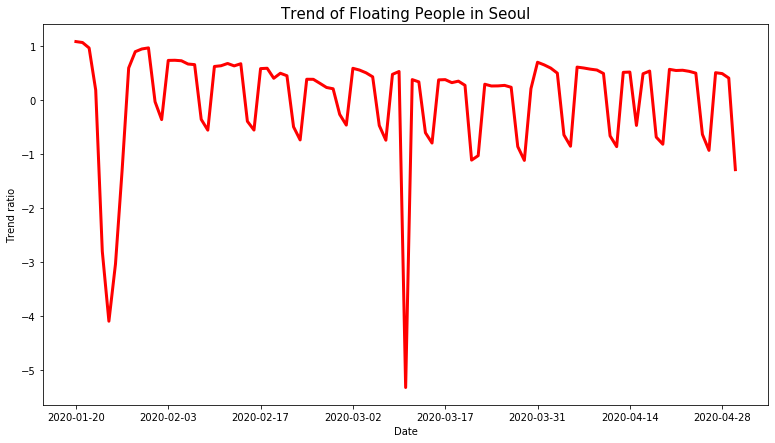

In [117]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Trend of Floating People in Seoul', size=15)
plt.plot(date_average.index.unique(), date_average.std_fp_num
         , color='red'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
plt.xlabel('Date')
plt.ylabel('Trend ratio')
plt.show()

分析結果：從趨勢圖可以更好的看見浮動人口的變化。除了兩個特殊事件外，大致是以七天為一個週期，在假日時進入波谷而在工作日回到大致算穩定的波峰。

**與整體確診趨勢圖之疊圖**

In [118]:
df_time = pd.read_csv(datasets[4])
df_float_time = df_time[:-14]
display(df_float_time.head(5).append(df_float_time.tail(5)))

date  time    test  negative  confirmed  released  deceased
0    2020-01-20    16       1         0          1         0         0
1    2020-01-21    16       1         0          1         0         0
2    2020-01-22    16       4         3          1         0         0
3    2020-01-23    16      22        21          1         0         0
4    2020-01-24    16      27        25          2         0         0
97   2020-04-26     0  598285    578558      10728      8717       242
98   2020-04-27     0  601660    582027      10738      8764       243
99   2020-04-28     0  608514    588559      10752      8854       244
100  2020-04-29     0  614197    595129      10761      8922       246
101  2020-04-30     0  619881    600482      10765      9059       247

In [119]:
#計算每日新增確診數
for index, row in df_float_time.iterrows():
    
    if index == 0:
        df_float_time.at[index,'new_confirmed'] = 1
    else:
        df_float_time.at[index,'new_confirmed'] = df_float_time.at[index,'confirmed'] - df_float_time.at[index - 1,'confirmed']
display(df_float_time.head(5).append(df_float_time.tail(5)))

date  time    test  negative  confirmed  released  deceased  \
0    2020-01-20    16       1         0          1         0         0   
1    2020-01-21    16       1         0          1         0         0   
2    2020-01-22    16       4         3          1         0         0   
3    2020-01-23    16      22        21          1         0         0   
4    2020-01-24    16      27        25          2         0         0   
97   2020-04-26     0  598285    578558      10728      8717       242   
98   2020-04-27     0  601660    582027      10738      8764       243   
99   2020-04-28     0  608514    588559      10752      8854       244   
100  2020-04-29     0  614197    595129      10761      8922       246   
101  2020-04-30     0  619881    600482      10765      9059       247   

     new_confirmed  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              1.0  
97            10.0  
98            10.0  
99            14.0  
100            9.0  
101            4.0

In [120]:
#正規化每日新增確診數
new_confirmed_describe = df_float_time['new_confirmed'].describe()
display(new_confirmed_describe)
mean = (new_confirmed_describe.loc['mean'])
std = (new_confirmed_describe.loc['std'])
df_float_time['std_new_confirmed'] = df_float_time['new_confirmed'].apply(lambda x : (x - mean) / std)
display(df_float_time.head(5).append(df_float_time.tail(5)))

count    102.000000
mean     105.539216
std      166.330023
min        0.000000
25%        2.250000
50%       31.000000
75%      109.250000
max      813.000000
Name: new_confirmed, dtype: float64

date  time    test  negative  confirmed  released  deceased  \
0    2020-01-20    16       1         0          1         0         0   
1    2020-01-21    16       1         0          1         0         0   
2    2020-01-22    16       4         3          1         0         0   
3    2020-01-23    16      22        21          1         0         0   
4    2020-01-24    16      27        25          2         0         0   
97   2020-04-26     0  598285    578558      10728      8717       242   
98   2020-04-27     0  601660    582027      10738      8764       243   
99   2020-04-28     0  608514    588559      10752      8854       244   
100  2020-04-29     0  614197    595129      10761      8922       246   
101  2020-04-30     0  619881    600482      10765      9059       247   

     new_confirmed  std_new_confirmed  
0              1.0          -0.628505  
1              0.0          -0.634517  
2              0.0          -0.634517  
3              0.0          -0.634517  
4              1.0          -0.628505  
97            10.0          -0.574395  
98            10.0          -0.574395  
99            14.0          -0.550347  
100            9.0          -0.580408  
101            4.0          -0.610468

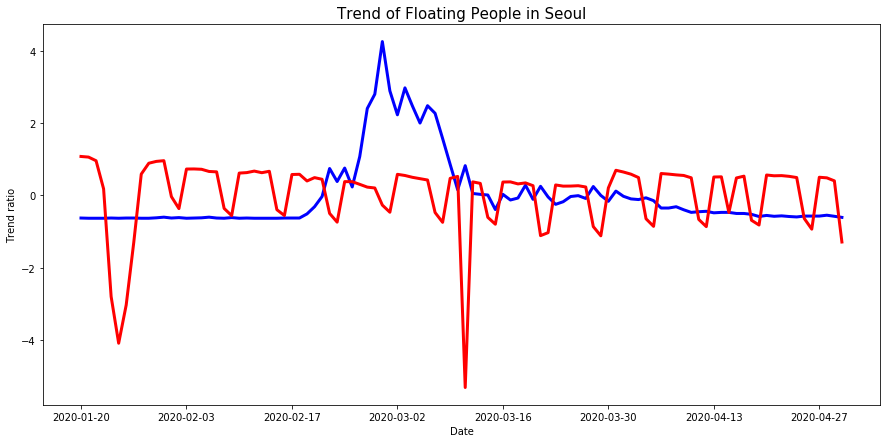

In [121]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Trend of Floating People in Seoul', size=15)
plt.plot(df_float_time['date'], df_float_time['std_new_confirmed']
         , color='blue'
         , lw=3)
plt.plot(date_average.index.unique(), date_average.std_fp_num
         , color='red'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
plt.xlabel('Date')
plt.ylabel('Trend ratio')
plt.show()

分析結果：將兩張趨勢圖進行疊圖後，大致可看出浮動人口的變化與確認數的變化基本上沒有關聯，浮動人口是按照它自己的週期在跳動了，只除了一點。3月10日那時候浮動人口急遽的下降，剛好是疫情的大爆發波峰剛過之際。推測是那時候首爾的情況也十分嚴重，人心惶惶造成浮動人口消退。

# PartIII 其它分析與未來確診數之預測
-----------------------------------
   ## 使用的資料集：
   
   
  ### Policy
  資料集說明：

- policy_id: 該項政策的流水編號
- type: 該項政策的類型
- gov_policy: 政策的粗略介紹
- detail: 政策的細節
- start_date: 該項政策啟用的時間
- end_date: 該項政策被廢止的時間
 
 
  ## 主要分析法：
 - 從政府對疫情的對應，從側面觀察當時疫情的嚴重性

### 3-1 政策層面分析

**基本調查**

In [122]:
display(policy.head(5).append(policy.tail(5)))

policy_id country            type                             gov_policy  \
0           1   Korea           Alert         Infectious Disease Alert Level   
1           2   Korea           Alert         Infectious Disease Alert Level   
2           3   Korea           Alert         Infectious Disease Alert Level   
3           4   Korea           Alert         Infectious Disease Alert Level   
4           5   Korea     Immigration          Special Immigration Procedure   
48         49   Korea      Technology                               Open API   
49         50   Korea      Technology                     Self-Diagnosis App   
50         51   Korea      Technology  Self-Quarantine Safety Protection App   
51         52   Korea      Technology                  Electronic Wristbands   
52         53   Korea  Administrative                   Close bars and clubs   

                                            detail  start_date    end_date  
0                                   Level 1 (Blue)  2020-01-03  2020-01-19  
1                                 Level 2 (Yellow)  2020-01-20  2020-01-27  
2                                 Level 3 (Orange)  2020-01-28  2020-02-22  
3                                    Level 4 (Red)  2020-02-23         NaN  
4                                       from China  2020-02-04         NaN  
48                   Public Mask Sales Information  2020-03-08         NaN  
49                                             NaN  2020-02-12         NaN  
50                                             NaN  2020-03-07         NaN  
51  on people who violate self-quarantine measures  2020-04-27         NaN  
52    administrative order to close bars and clubs  2020-05-08  2020-06-07

In [123]:

#統計每則政令發布日期
policy_num = pd.DataFrame()
count = policy.groupby('start_date').count()
display(count.policy_id)

start_date
2020-01-03    1
2020-01-20    2
2020-01-28    1
2020-02-04    2
2020-02-12    4
2020-02-23    1
2020-02-26    1
2020-02-27    3
2020-03-02    5
2020-03-04    1
2020-03-07    1
2020-03-08    1
2020-03-09    2
2020-03-12    2
2020-03-13    1
2020-03-15    5
2020-03-16    1
2020-03-19    1
2020-03-22    1
2020-04-01    1
2020-04-06    1
2020-04-09    2
2020-04-13    1
2020-04-16    7
2020-04-20    3
2020-04-27    1
2020-05-08    1
Name: policy_id, dtype: int64

分析結果：有多項現今仍沿用的政策，並且韓國政府最早從1月3日作出對應。4月16號時出現了異常值，標誌著大事件的發生。

**分布**

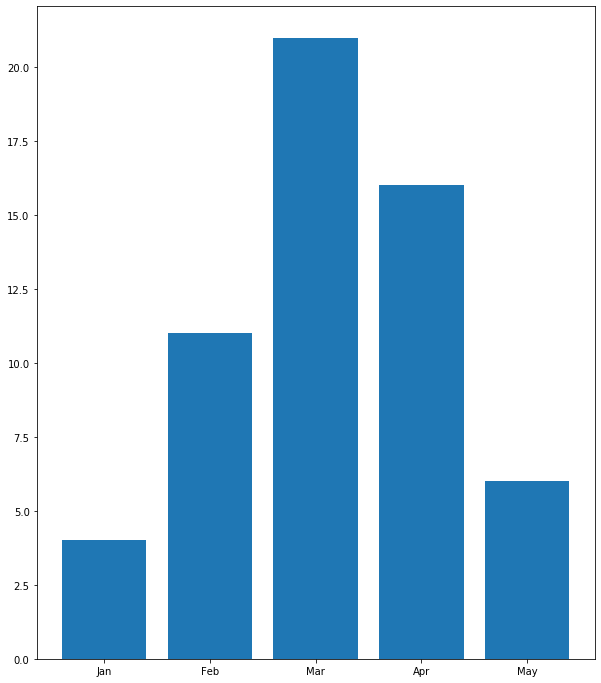

In [124]:
fig, ax = plt.subplots(figsize=(10,12))
month=['Jan','Feb','Mar','Apr','May']
policy_count=[4,11,21,16,6]
bar = ax.bar(month, policy_count)

分析結果：上圖中可看出政令發布數量最高的3,4月，是韓國疫情的高峰，推測政令發布頻率與疫情嚴重程度相關。

### 3-2 數值性預測

### 載入Ground Truth (資料來源：https://ourworldindata.org/coronavirus-testing)

In [125]:
df_ground = ground
df_ground = df_ground[df_ground.iso_code == 'KOR']
display(df_ground.head(5).append(df_ground.tail(5)))

iso_code continent     location        date  total_cases  new_cases  \
18985      KOR      Asia  South Korea  2019-12-31            0          0   
18986      KOR      Asia  South Korea  2020-01-01            0          0   
18987      KOR      Asia  South Korea  2020-01-02            0          0   
18988      KOR      Asia  South Korea  2020-01-03            0          0   
18989      KOR      Asia  South Korea  2020-01-04            0          0   
19142      KOR      Asia  South Korea  2020-06-05        11668         39   
19143      KOR      Asia  South Korea  2020-06-06        11719         51   
19144      KOR      Asia  South Korea  2020-06-07        11776         57   
19145      KOR      Asia  South Korea  2020-06-08        11814         38   
19146      KOR      Asia  South Korea  2020-06-09        11852         38   

       total_deaths  new_deaths  total_cases_per_million  \
18985             0           0                    0.000   
18986             0           0                    0.000   
18987             0           0                    0.000   
18988             0           0                    0.000   
18989             0           0                    0.000   
19142           273           0                  227.583   
19143           273           0                  228.578   
19144           273           0                  229.690   
19145           273           0                  230.431   
19146           274           1                  231.172   

       new_cases_per_million  ...  aged_65_older  aged_70_older  \
18985                  0.000  ...         13.914          8.622   
18986                  0.000  ...         13.914          8.622   
18987                  0.000  ...         13.914          8.622   
18988                  0.000  ...         13.914          8.622   
18989                  0.000  ...         13.914          8.622   
19142                  0.761  ...         13.914          8.622   
19143                  0.995  ...         13.914          8.622   
19144                  1.112  ...         13.914          8.622   
19145                  0.741  ...         13.914          8.622   
19146                  0.741  ...         13.914          8.622   

       gdp_per_capita  extreme_poverty  cvd_death_rate  diabetes_prevalence  \
18985       35938.374              0.2          85.998                  6.8   
18986       35938.374              0.2          85.998                  6.8   
18987       35938.374              0.2          85.998                  6.8   
18988       35938.374              0.2          85.998                  6.8   
18989       35938.374              0.2          85.998                  6.8   
19142       35938.374              0.2          85.998                  6.8   
19143       35938.374              0.2          85.998                  6.8   
19144       35938.374              0.2          85.998                  6.8   
19145       35938.374              0.2          85.998                  6.8   
19146       35938.374              0.2          85.998                  6.8   

       female_smokers  male_smokers handwashing_facilities  \
18985             6.2          40.9                    NaN   
18986             6.2          40.9                    NaN   
18987             6.2          40.9                    NaN   
18988             6.2          40.9                    NaN   
18989             6.2          40.9                    NaN   
19142             6.2          40.9                    NaN   
19143             6.2          40.9                    NaN   
19144             6.2          40.9                    NaN   
19145             6.2          40.9                    NaN   
19146             6.2          40.9                    NaN   

       hospital_beds_per_thousand  
18985                       12.27  
18986                       12.27  
18987                       12.27  
18988                       12.27  
18989                     

### 驗證外部資料集的正確性

**累積確診數**

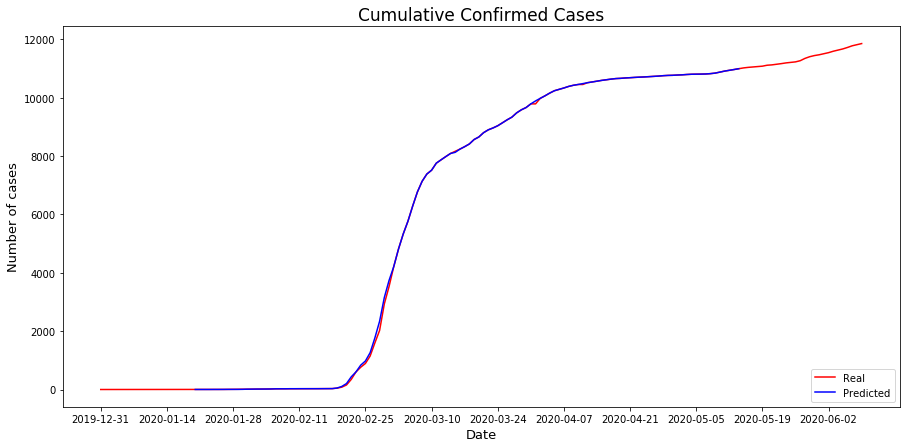

In [126]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)

plt.plot(df_ground.date.unique(), df_ground.total_cases , label='Real', color='red')
plt.plot(time.date.unique(), time.confirmed , label='Predicted', color='blue')
plt.legend(loc='lower right')
ax.set_xticks(ax.get_xticks()[::14])
plt.show()




**累積死亡數**

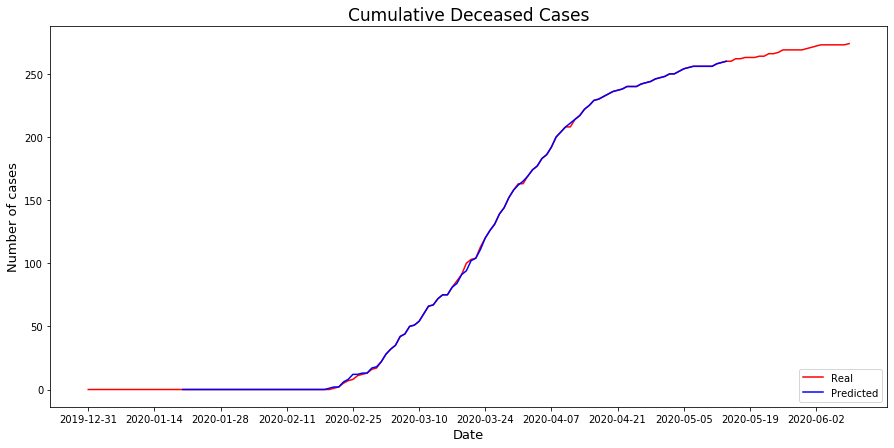

In [127]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)

plt.plot(df_ground.date.unique(), df_ground.total_deaths , label='Real', color='red')
plt.plot(time.date.unique(), time.deceased , label='Predicted', color='blue')
plt.legend(loc='lower right')
ax.set_xticks(ax.get_xticks()[::14])
plt.show()




分析結果：兩個資料集無論是確診數或死亡數都有些出入，但差距不大，不會影響我們對預測準確性的判斷。

**預測確診數**

In [128]:
%matplotlib inline
from fbprophet import Prophet
from sklearn import metrics

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

分析結果：疫情爆發前的零確診數會干擾模型的判斷，因此這裡先將其過濾掉。

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-04-14 00:00:00 and 2020-04-14 00:00:00


Text(0.5, 1, 'Predicted Confirmed Cases Range')

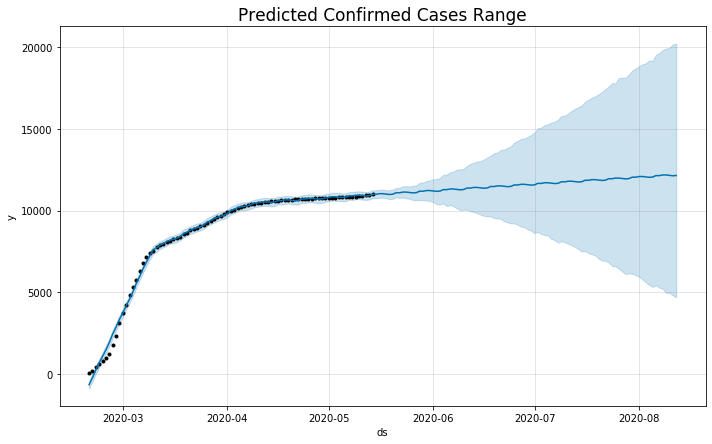

In [129]:
confirmed_time = time
confirmed_time['date'] = pd.to_datetime(confirmed_time['date'])
confirmed_time = confirmed_time[confirmed_time['date'] >= pd.datetime(2020,2,20)]
confirmed_time['ds'] = confirmed_time['date']
confirmed_time['y'] = confirmed_time['confirmed']
# 定義模型
model = Prophet().add_seasonality(name='daily',period=1,fourier_order=15
                                                  ).add_seasonality(name='weekly',period=7,fourier_order=20)
model.add_country_holidays(country_name='KR')
model.fit(confirmed_time)
future = model.make_future_dataframe(periods=90) #forecasting for 1 year from now.
forecast = model.predict(future)
df_cv = cross_validation(model, initial='50 days', period='15 days', horizon = '30 days')
model.plot(forecast)
plt.title('Predicted Confirmed Cases Range', fontsize=17)


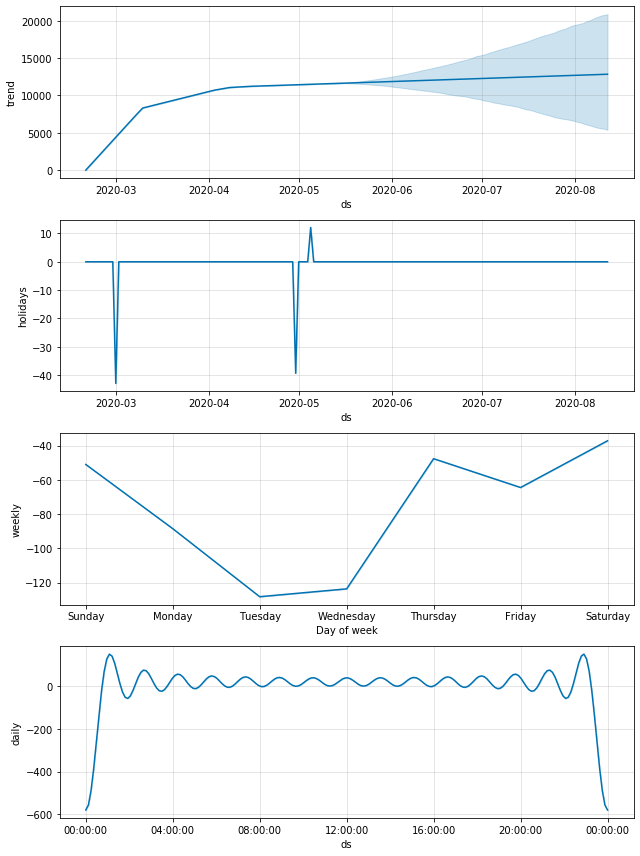

In [130]:
model.plot_components(forecast);

In [131]:
forecast = forecast[forecast['ds'] < '2020-6-11']
forecast = forecast[forecast['ds'] > '2020-5-14']
forecast['date'] = forecast['ds'].apply(lambda x : x.date().strftime("%Y-%m-%d"))
#forecast['date'] = pd.to_datetime(forecast['date'],format="%Y-%m-%d")

display(forecast.tail(5).T)
forecast.dtypes

107                  108  \
ds                                 2020-06-06 00:00:00  2020-06-07 00:00:00   
trend                                          11934.8              11948.4   
yhat_lower                                     10346.9              10257.9   
yhat_upper                                     12351.8                12381   
trend_lower                                    10948.1                10892   
trend_upper                                      12915              13006.7   
Buddha's Birthday                                    0                    0   
Buddha's Birthday_lower                              0                    0   
Buddha's Birthday_upper                              0                    0   
Children's Day                                       0                    0   
Children's Day_lower                                 0                    0   
Children's Day_upper                                 0                    0   
Christmas Day                                        0                    0   
Christmas Day_lower                                  0                    0   
Christmas Day_upper                                  0                    0   
Chuseok                                              0                    0   
Chuseok_lower                                        0                    0   
Chuseok_upper                                        0                    0   
Hangeul Proclamation Day                             0                    0   
Hangeul Proclamation Day_lower                       0                    0   
Hangeul Proclamation Day_upper                       0                    0   
Independence Movement Day                            0                    0   
Independence Movement Day_lower                      0                    0   
Independence Movement Day_upper                      0                    0   
Liberation Day                                       0                    0   
Liberation Day_lower                                 0                    0   
Liberation Day_upper                                 0                    0   
Memorial Day                              -1.70878e-10                    0   
Memorial Day_lower                        -1.70878e-10                    0   
Memorial Day_upper                        -1.70878e-10                    0   
National Foundation Day                              0                    0   
National Foundation Day_lower                        0                    0   
National Foundation Day_upper                        0                    0   
New Year's Day                                       0                    0   
New Year's Day_lower                                 0                    0   
New Year's Day_upper                                 0                    0   
New Year's Day by the Lunar                          0                    0   
New Year's Day by the Lunar_lower                    0                    0   
New Year's Day by the Lunar_upper                    0                    0   
additive_terms                                -616.634             -630.433   
additive_terms_lower                          -616.634             -630.433   
additive_terms_upper                          -616.634             -630.433   
daily                                         -579.388             -579.388   
daily_lower                                   -579.388             -579.388   
daily_upper                                   -579.388             -579.388   
holidays                                  -1.70878e-10                    0   
holidays_lower                            -1.70878e-10                    0   
holidays_upper                            -1.70878e-10                    0   
weekly                                        -37.2461             -51.0452   
weekly_lower                                  -37.2461             -51.0452   
weekly_upper          

ds                                   datetime64[ns]
trend                                       float64
yhat_lower                                  float64
yhat_upper                                  float64
trend_lower                                 float64
trend_upper                                 float64
Buddha's Birthday                           float64
Buddha's Birthday_lower                     float64
Buddha's Birthday_upper                     float64
Children's Day                              float64
Children's Day_lower                        float64
Children's Day_upper                        float64
Christmas Day                               float64
Christmas Day_lower                         float64
Christmas Day_upper                         float64
Chuseok                                     float64
Chuseok_lower                               float64
Chuseok_upper                               float64
Hangeul Proclamation Day                    float64
Hangeul Proc

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

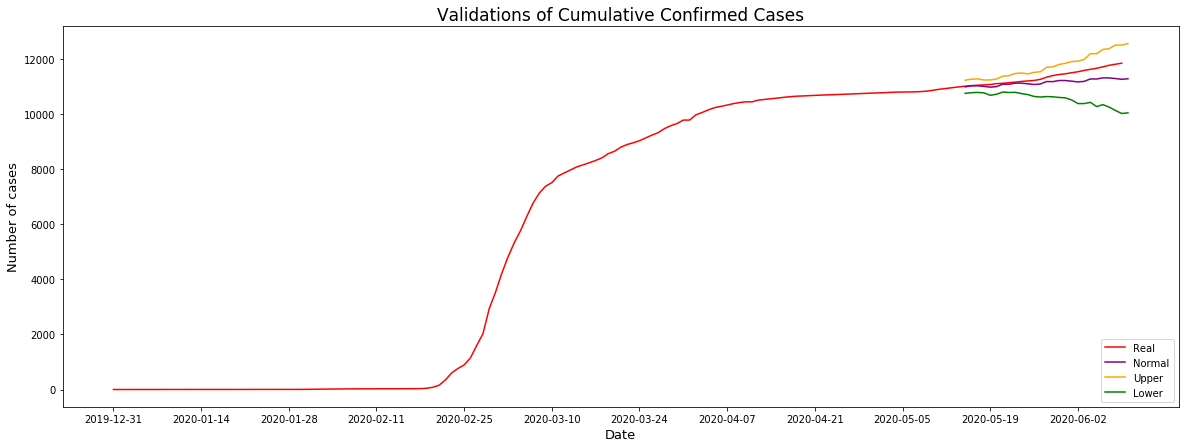

In [132]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.title('Validations of Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(df_ground.date.unique(), df_ground.total_cases , label='Real', color='red')
plt.plot(forecast.date, forecast.yhat , label='Normal', color='purple')
plt.plot(forecast.date, forecast.yhat_upper , label='Upper', color='orange')
plt.plot(forecast.date, forecast.yhat_lower , label='Lower', color='green')
#plt.plot(time.date.unique(), time.confirmed, label='Predicted', color='blue')
plt.legend(loc='lower right')

ax.set_xticks(ax.get_xticks()[::14])
plt.show()

分析結果：根據這個簡單的Prophet模型，確診數的確診數仍在上升中，一開始還算符合預測的結果但有往上界靠攏的傾向，是疫情即將再度升溫的警訊。

   horizon      mape
0   3 days  0.008181
1   4 days  0.012111
2   5 days  0.015032
3   6 days  0.018807
4   7 days  0.020519
5   8 days  0.023282
6   9 days  0.026603
7  10 days  0.030100
8  11 days  0.035180
9  12 days  0.038754
10 13 days  0.042768
11 14 days  0.044317
12 15 days  0.047039
13 16 days  0.050352
14 17 days  0.053907
15 18 days  0.059102
16 19 days  0.062570
17 20 days  0.066636
18 21 days  0.068481
19 22 days  0.071825
20 23 days  0.075697
21 24 days  0.079351
22 25 days  0.084007
23 26 days  0.086235
24 27 days  0.088256
25 28 days  0.087671
26 29 days  0.088478
27 30 days  0.089873


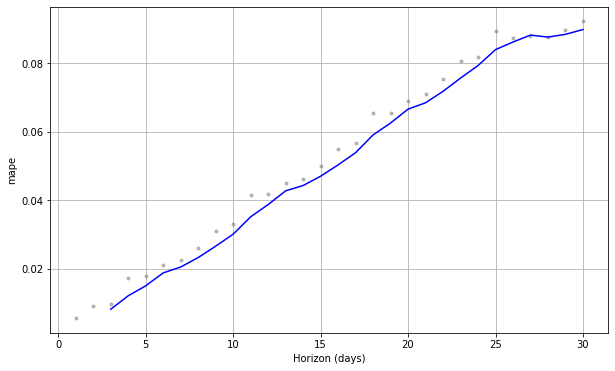

In [133]:
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mape']])
fig = plot_cross_validation_metric(df_cv, metric='mape')

分析結果:點為每次驗證結果的absolute percent error，線為平均絕對百分比誤差(MAPE, Mean absolute percentage error)。預測誤差隨著時間逐漸變大，代表現階段雖然病情平穩，但若不繼續維持警慎態度，也有可能預測失準，病情會再度失控。

**預測死亡數**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-04-14 00:00:00 and 2020-04-14 00:00:00


Text(0.5, 1, 'Predicted Deceased Cases Range')

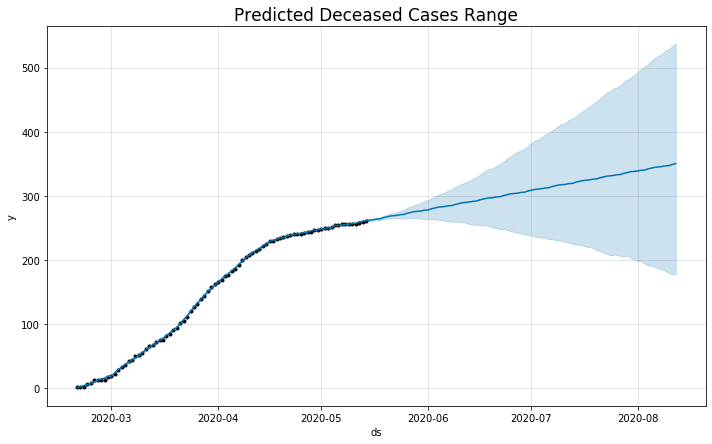

In [134]:
deceased_time = time
deceased_time['date'] = pd.to_datetime(deceased_time['date'])
deceased_time = deceased_time[deceased_time['date'] >= pd.datetime(2020,2,20)]
deceased_time['ds'] = deceased_time['date']
deceased_time['y'] = deceased_time['deceased']
# 定義模型
model = Prophet().add_seasonality(name='daily',period=1,fourier_order=15
                                                  ).add_seasonality(name='weekly',period=7,fourier_order=20)
model.add_country_holidays(country_name='KR')
model.fit(deceased_time)
future = model.make_future_dataframe(periods=90) #forecasting for 1 year from now.
forecast = model.predict(future)
df_cv = cross_validation(model, initial='50 days', period='15 days', horizon = '30 days')
model.plot(forecast)
plt.title('Predicted Deceased Cases Range', fontsize=17)


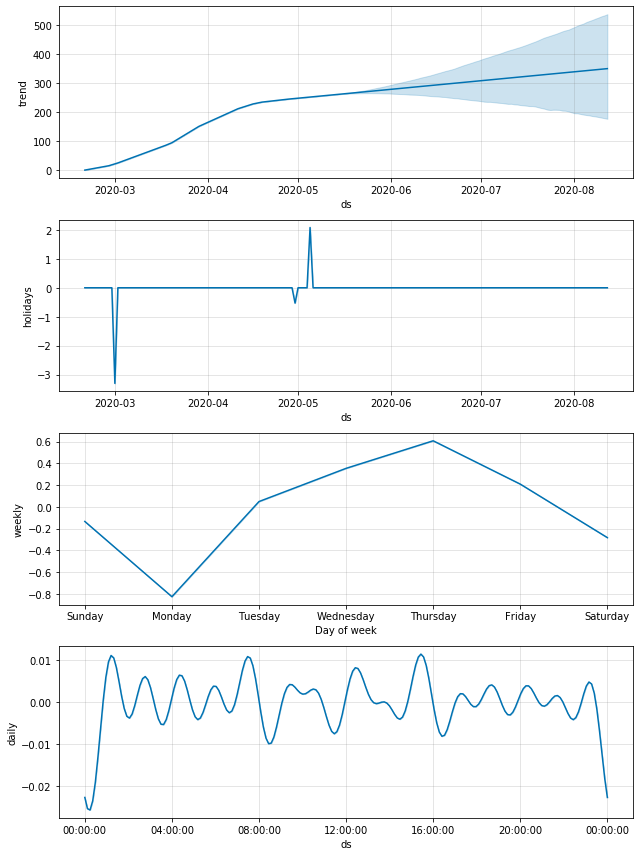

In [135]:
model.plot_components(forecast);

In [136]:
forecast = forecast[forecast['ds'] < '2020-6-11']
forecast = forecast[forecast['ds'] > '2020-5-14']
forecast['date'] = forecast['ds'].apply(lambda x : x.date().strftime("%Y-%m-%d"))
#forecast['date'] = pd.to_datetime(forecast['date'],format="%Y-%m-%d")

display(forecast.tail(5).T)
forecast.dtypes

107                  108  \
ds                                 2020-06-06 00:00:00  2020-06-07 00:00:00   
trend                                          283.558              284.547   
yhat_lower                                     261.064               260.01   
yhat_upper                                     305.597              308.412   
trend_lower                                    261.346              260.424   
trend_upper                                    306.194              308.519   
Buddha's Birthday                                    0                    0   
Buddha's Birthday_lower                              0                    0   
Buddha's Birthday_upper                              0                    0   
Children's Day                                       0                    0   
Children's Day_lower                                 0                    0   
Children's Day_upper                                 0                    0   
Christmas Day                                        0                    0   
Christmas Day_lower                                  0                    0   
Christmas Day_upper                                  0                    0   
Chuseok                                              0                    0   
Chuseok_lower                                        0                    0   
Chuseok_upper                                        0                    0   
Hangeul Proclamation Day                             0                    0   
Hangeul Proclamation Day_lower                       0                    0   
Hangeul Proclamation Day_upper                       0                    0   
Independence Movement Day                            0                    0   
Independence Movement Day_lower                      0                    0   
Independence Movement Day_upper                      0                    0   
Liberation Day                                       0                    0   
Liberation Day_lower                                 0                    0   
Liberation Day_upper                                 0                    0   
Memorial Day                               1.39054e-10                    0   
Memorial Day_lower                         1.39054e-10                    0   
Memorial Day_upper                         1.39054e-10                    0   
National Foundation Day                              0                    0   
National Foundation Day_lower                        0                    0   
National Foundation Day_upper                        0                    0   
New Year's Day                                       0                    0   
New Year's Day_lower                                 0                    0   
New Year's Day_upper                                 0                    0   
New Year's Day by the Lunar                          0                    0   
New Year's Day by the Lunar_lower                    0                    0   
New Year's Day by the Lunar_upper                    0                    0   
additive_terms                               -0.304987             -0.15646   
additive_terms_lower                         -0.304987             -0.15646   
additive_terms_upper                         -0.304987             -0.15646   
daily                                        -0.022627            -0.022627   
daily_lower                                  -0.022627            -0.022627   
daily_upper                                  -0.022627            -0.022627   
holidays                                   1.39054e-10                    0   
holidays_lower                             1.39054e-10                    0   
holidays_upper                             1.39054e-10                    0   
weekly                                        -0.28236            -0.133833   
weekly_lower                                  -0.28236            -0.133833   
weekly_upper          

ds                                   datetime64[ns]
trend                                       float64
yhat_lower                                  float64
yhat_upper                                  float64
trend_lower                                 float64
trend_upper                                 float64
Buddha's Birthday                           float64
Buddha's Birthday_lower                     float64
Buddha's Birthday_upper                     float64
Children's Day                              float64
Children's Day_lower                        float64
Children's Day_upper                        float64
Christmas Day                               float64
Christmas Day_lower                         float64
Christmas Day_upper                         float64
Chuseok                                     float64
Chuseok_lower                               float64
Chuseok_upper                               float64
Hangeul Proclamation Day                    float64
Hangeul Proc

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

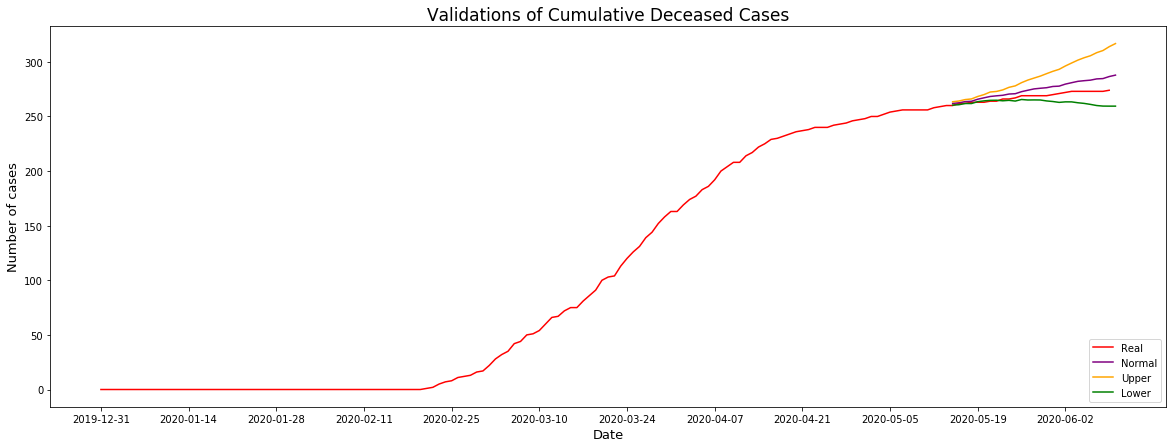

In [137]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.title('Validations of Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(df_ground.date.unique(), df_ground.total_deaths , label='Real', color='red')
plt.plot(forecast.date, forecast.yhat , label='Normal', color='purple')
plt.plot(forecast.date, forecast.yhat_upper , label='Upper', color='orange')
plt.plot(forecast.date, forecast.yhat_lower , label='Lower', color='green')
#plt.plot(time.date.unique(), time.deceased, label='Predicted', color='blue')
plt.legend(loc='lower right')

ax.set_xticks(ax.get_xticks()[::14])
plt.show()

分析結果：死亡率則在標準預測值及下界的中間，表示南韓現在的醫療措施作得不錯，但仍有進步的空間。

   horizon      mape
0   3 days  0.023546
1   4 days  0.032151
2   5 days  0.043394
3   6 days  0.051518
4   7 days  0.063133
5   8 days  0.076512
6   9 days  0.092019
7  10 days  0.106884
8  11 days  0.122050
9  12 days  0.136903
10 13 days  0.148683
11 14 days  0.160861
12 15 days  0.173288
13 16 days  0.187819
14 17 days  0.200227
15 18 days  0.211375
16 19 days  0.223894
17 20 days  0.233288
18 21 days  0.244564
19 22 days  0.254465
20 23 days  0.268049
21 24 days  0.282929
22 25 days  0.298344
23 26 days  0.315261
24 27 days  0.330826
25 28 days  0.344835
26 29 days  0.357408
27 30 days  0.370251


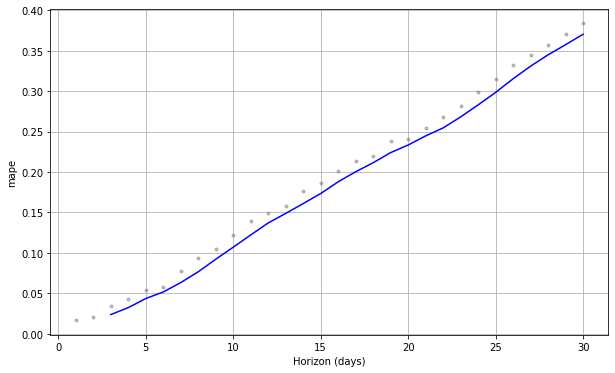

In [138]:
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mape']])
fig = plot_cross_validation_metric(df_cv, metric='mape')

分析結果:分析結果:點為每次驗證結果的absolute percent error，線為平均絕對百分比誤差(MAPE, Mean absolute percentage error)。同樣的預測誤差隨著時間逐漸變大，現階段死亡人數維持平穩，但時間越長預測越不可信。

# PartIV 結論
-----------------------------------
  
  ## 哪些人容易得病：
   - 容易確診：20歲到30歲的年輕人。女性。位於大邱及京畿道地區的居民。
   - 容易死亡：老人
   - 不容易確診： 幼兒及老人，住在偏鄉下地區的人。人口數越少越不容易確診。
   - 不容易死亡： 年輕人、幼兒
  
     
  ## 與疫情息息相關的因素：
   - 群聚事件（新天地）
   - 政府的政策發佈的數量
  
  
  ## 整體趨勢：
   - 3、4月是疫情高峰
   - 雖然因為群聚事件造成大爆發，在政府積極的作為下，已得到了控制。而疫情雖已平緩化但仍出現了升溫的警訊，仍然不能鬆懈
   
   
  ## 參考資料：
   - http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007
   - http://www.seoul.go.kr/coronaV/coronaStatus.do
   - http://www.koreaherald.com/view.php?ud=20191119000682
   - https://www.kaggle.com/dkjung/covid-19-eda-s-korea-forecasting-global
   - https://ourworldindata.org/coronavirus-testing
   - https://ithelp.ithome.com.tw/articles/10208534
   
  